In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
sns.set_style('white')


In [2]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [3]:
sns.set_context('poster')

In [4]:
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['P', 'X', 'h', '<','>']
apallete = ['#6dad36', '#c7e89f', '#f5c4e1', '#d5579d', '#8a0850']

aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']

In [5]:
meta_df = pd.read_excel('exp 6 transfer Apr2019.xlsx', sheet_name='sent for seq')
meta_df.rename(columns={'#': 'sample_number'}, inplace=True)
meta_df.sample_number = pd.to_numeric(meta_df.sample_number)

In [6]:
import json
with open(os.path.join('DNA','dnaseq', 'qualimap_multiqc_data','multiqc_data.json')) as fp:
    qualimap_json = json.load(fp)

In [7]:

qualimap_json.keys()

dict_keys(['report_data_sources', 'report_general_stats_data', 'report_general_stats_headers', 'report_multiqc_command', 'report_plot_data', 'report_saved_raw_data', 'config_analysis_dir_abs', 'config_analysis_dir', 'config_creation_date', 'config_git_hash', 'config_intro_text', 'config_report_comment', 'config_report_header_info', 'config_script_path', 'config_short_version', 'config_subtitle', 'config_title', 'config_version'])

In [8]:
qmap_titles = {i : qualimap_json['report_general_stats_headers'][0][i]['title'].replace('&ge;', '>')
 for i in qualimap_json['report_general_stats_headers'][0] }

In [9]:
len(qualimap_json['report_general_stats_data'])

1

In [10]:
def _item_to_dict(k,v):
    v['Key'] = k.split('|')[0]
    return v
bamqc_df = pd.DataFrame([_item_to_dict(k,v) for k,v in qualimap_json['report_general_stats_data'][0].items()])

In [11]:
bamqc_df.head()

total_reads  mapped_reads  percentage_aligned  general_error_rate  \
0     550761.0      134228.0           24.371370                0.44   
1      79690.0        9854.0           12.365416                3.72   
2     268388.0       54226.0           20.204331                0.18   
3     221198.0        1103.0            0.498648               11.42   
4     261903.0      251977.0           96.210047                0.28   

   mean_coverage             Key  median_coverage  median_insert_size  avg_gc  \
0         4.8599         12_1A3               NaN                 NaN     NaN   
1         0.3646          21_DE               NaN                 NaN     NaN   
2         4.9590     18_MIT0604               NaN                 NaN     NaN   
3         0.0442  17_Maricaulis               NaN                 NaN     NaN   
4         9.0282         06_1A3               NaN                 NaN     NaN   

   1_x_pc  5_x_pc  10_x_pc  30_x_pc  50_x_pc  
0     NaN     NaN      NaN      NaN      NaN  
1     NaN     NaN      NaN      NaN      NaN  
2     NaN     NaN      NaN      NaN      NaN  
3     NaN     NaN      NaN      NaN      NaN  
4     NaN     NaN      NaN      NaN      NaN

In [12]:
bamqc_df = bamqc_df.pivot_table(index='Key').reset_index()
bamqc_df = bamqc_df.loc[~bamqc_df.Key.isin(['08_1A3', '08_MIT9313'])]
bamqc_df[['sample_number', 'species']] = bamqc_df.Key.str.split('_', expand=True)
bamqc_df['sample_number'] = pd.to_numeric(bamqc_df['sample_number'])
bamqc_df = bamqc_df.loc[bamqc_df.sample_number != 8]

bamqc_df.head()


Key    10_x_pc     1_x_pc    30_x_pc    50_x_pc     5_x_pc  \
0         01_1A3   99.665126  99.986713  44.556351   2.066889  99.956183   
1          02_DE   99.530857  99.948538  42.842870   1.027107  99.871411   
2     03_MIT9313   99.511546  99.995106  49.137470   2.178381  99.926126   
3     04_MIT0604   99.686022  99.756750  73.074687  10.393352  99.751076   
4  04_Maricaulis    0.000000   0.853247   0.000000   0.000000   0.004720   

      avg_gc  general_error_rate  mapped_reads  mean_coverage  \
0  45.442369                0.30      818317.0        29.0857   
1  45.545246                0.52      741707.0        28.4919   
2  51.545547                0.21      544213.0        29.7018   
3  32.475995                0.19      366615.0        36.2127   
4  60.340426               11.37         404.0         0.0180   

   median_coverage  median_insert_size  percentage_aligned  total_reads  \
0             28.0               153.0           99.578719     821779.0   
1             28.0               156.0           98.530492     752769.0   
2             29.0               114.0           98.872316     550420.0   
3             36.0               160.0           68.248963     537173.0   
4              0.0               148.0            0.246791     163701.0   

   sample_number      species  
0              1         1A3   
1              2          DE   
2              3     MIT9313   
3              4     MIT0604   
4              4  Maricaulis

In [13]:
bamqc_df = pd.merge(bamqc_df, meta_df, on='sample_number', how='left')

In [14]:
bamqc_df.columns

Index(['Key', '10_x_pc', '1_x_pc', '30_x_pc', '50_x_pc', '5_x_pc', 'avg_gc',
       'general_error_rate', 'mapped_reads', 'mean_coverage',
       'median_coverage', 'median_insert_size', 'percentage_aligned',
       'total_reads', 'sample_number', 'species', 'sample', 'PRO', 'ALT',
       'exp', 'days', 'ng/ul', 'final volume'],
      dtype='object')

In [15]:
value_cols = ['sample', 'PRO', 'ALT',
       'exp', '5_x_pc', '10_x_pc', '30_x_pc', 'avg_gc',
       
         'percentage_aligned','median_coverage','mean_coverage','median_insert_size',
        'general_error_rate', 'mapped_reads', 'total_reads'
             ]
        
pct_cols = [ '5_x_pc', '10_x_pc', '30_x_pc', 'avg_gc',
         'percentage_aligned']
with pd.ExcelWriter('bamqc_stats.xlsx', engine='xlsxwriter') as writer:  
    workbook  = writer.book
    format1 = workbook.add_format({'num_format': '#,##0.00'})
    format2 = workbook.add_format({'num_format': '0%'})
    for i in bamqc_df.species.unique():
        bamqc_pdf = bamqc_df.loc[bamqc_df.species.isin([i])].pivot(index='sample_number', columns='species', 
                               values=value_cols)
        bamqc_pdf[pct_cols] = bamqc_pdf[pct_cols]/100
        bamqc_pdf.rename(columns=qmap_titles, inplace=True)
        sheetname = f'{i} bamqc'
        bamqc_pdf.to_excel(writer, sheet_name=sheetname)
        worksheet = writer.sheets[sheetname]
        worksheet.set_column('F:J', None, format2)
        worksheet.set_column('L:L', None, format1)
        
        
        worksheet.conditional_format(f'F1:H{bamqc_df.shape[0]+2}', {'type': 'data_bar'})
        worksheet.conditional_format(f'K1:L{bamqc_df.shape[0]+2}', {'type': 'data_bar', 'bar_color' : 'green'})
    



In [16]:
import json
with open(os.path.join('DNA','dnaseq_trimmed', 'multiqc_data.json')) as fp:
    qualimap_json = json.load(fp)

In [17]:
trimmed_titles = {i : qualimap_json['report_general_stats_headers'][0][i]['title'].replace('&ge;', '>')
 for i in qualimap_json['report_general_stats_headers'][0] }

In [18]:
len(qualimap_json['report_general_stats_data'])

4

In [19]:
def _item_to_dict(k,v):
    v['Key'] = k.split('|')[0]
    return v
trimmed_df = pd.DataFrame([
    _item_to_dict(k,v) 
    for d in qualimap_json['report_general_stats_data']
    for k,v in d.items()
])

In [20]:
trimmed_df.head()

total_reads  mapped_reads  percentage_aligned  general_error_rate  \
0     488749.0        8101.0            1.657497                2.13   
1      65170.0        7893.0           12.111401                2.10   
2     489657.0       15149.0            3.093798                2.02   
3     489977.0        1455.0            0.296953                3.89   
4     491414.0      420148.0           85.497768                0.09   

   mean_coverage  median_coverage  median_insert_size     avg_gc     1_x_pc  \
0         0.2863              0.0               154.0  45.754564  14.741716   
1         0.2794              0.0               154.0  45.670117  14.524395   
2         0.5048              0.0               155.0  45.738068  24.717820   
3         0.0886              0.0               128.0  53.353191   0.461617   
4        38.4190             38.0               153.0  32.643963  99.754840   

      5_x_pc  ...  forward_only_surviving_pct  reverse_only_surviving  \
0   0.159721  ...                         NaN                     NaN   
1   0.117342  ...                         NaN                     NaN   
2   0.413449  ...                         NaN                     NaN   
3   0.375300  ...                         NaN                     NaN   
4  99.705684  ...                         NaN                     NaN   

   reverse_only_surviving_pct dropped dropped_pct  percent_gc  \
0                         NaN     NaN         NaN         NaN   
1                         NaN     NaN         NaN         NaN   
2                         NaN     NaN         NaN         NaN   
3                         NaN     NaN         NaN         NaN   
4                         NaN     NaN         NaN         NaN   

   avg_sequence_length  total_sequences  percent_duplicates  percent_fails  
0                  NaN              NaN                 NaN            NaN  
1                  NaN              NaN                 NaN            NaN  
2                  NaN              NaN                 NaN            NaN  
3                  NaN              NaN                 NaN            NaN  
4                  NaN              NaN                 NaN            NaN  

[5 rows x 108 columns]

In [21]:
trimmed_df['Key'].unique()



array(['snippy_19_DE_all', 'snippy_19_DE_filtered', 'snippy_19_1A3_all',
       'snippy_19_MIT9313_all', 'snippy_19_MIT0604_all',
       'snippy_19_MIT0604_filtered', 'snippy_10_MIT9313_all',
       'snippy_10_MIT0604_filtered', 'snippy_10_MIT0604_all',
       'snippy_10_1A3_all', 'snippy_10_DE_all', 'snippy_10_1A3_filtered',
       'snippy_17_DE_filtered', 'snippy_17_DE_all',
       'snippy_17_MIT9313_all', 'snippy_17_MIT0604_filtered',
       'snippy_17_MIT0604_all', 'snippy_17_1A3_all',
       'snippy_13_MIT0604_all', 'snippy_13_MIT9313_all',
       'snippy_13_1A3_filtered', 'snippy_13_DE_all', 'snippy_13_1A3_all',
       'snippy_13_MIT0604_filtered', 'snippy_11_MIT0604_all',
       'snippy_11_1A3_all', 'snippy_11_MIT0604_filtered',
       'snippy_11_1A3_filtered', 'snippy_11_DE_all',
       'snippy_11_MIT9313_all', 'snippy_20_DE_filtered',
       'snippy_20_MIT0604_all', 'snippy_20_1A3_all',
       'snippy_20_MIT0604_filtered', 'snippy_20_DE_all',
       'snippy_20_MIT9313_all', 's

In [22]:
def _key_to_sample_species(x):
    mode = None
    if x.startswith('200219Seg_D20-16'):
        idx = x.replace('200219Seg_D20-', '').replace('_1_sequence','')
        sample_number = pd.to_numeric(idx) - 160000
        command = 'fastqc'
        species = None
    elif x.startswith('trim_200219Seg_D20'):
        idx = x.replace('trim_200219Seg_D20-', '').replace('_1_sequence_P','').replace('_2_sequence_P','')
        sample_number = pd.to_numeric(idx) - 160000
        command = 'trimmomatic'
        species = None
    elif x.startswith('freebayes_'):
        sample_number = None
        command = 'freebayes'
        species = x.replace('freebayes_', '')
    elif x.startswith('snippy_'):
        _, idx, species, mode = x.split('_')
        sample_number = pd.to_numeric(idx) 
        command = 'bamqc'
    return pd.Series({
        'species' : species,
         'mode' :mode,
        'sample_number' :sample_number,
        'command' : command,
    })

trimmed_df = pd.concat([trimmed_df, trimmed_df['Key'].apply(_key_to_sample_species)], axis=1)


In [23]:
trimmed_df = trimmed_df.loc[trimmed_df['sample_number'] != 8]

In [24]:
trimmed_df = pd.merge(trimmed_df, meta_df, on='sample_number', how='left')

In [25]:
trimmed_df['pair'] = trimmed_df['PRO'] + ',' + trimmed_df['ALT']

In [26]:
trimmed_df.columns

Index(['total_reads', 'mapped_reads', 'percentage_aligned',
       'general_error_rate', 'mean_coverage', 'median_coverage',
       'median_insert_size', 'avg_gc', '1_x_pc', '5_x_pc',
       ...
       'sample_number', 'command', 'sample', 'PRO', 'ALT', 'exp', 'days',
       'ng/ul', 'final volume', 'pair'],
      dtype='object', length=120)

In [27]:
trimmed_df.head()

total_reads  mapped_reads  percentage_aligned  general_error_rate  \
0     488749.0        8101.0            1.657497                2.13   
1      65170.0        7893.0           12.111401                2.10   
2     489657.0       15149.0            3.093798                2.02   
3     489977.0        1455.0            0.296953                3.89   
4     491414.0      420148.0           85.497768                0.09   

   mean_coverage  median_coverage  median_insert_size     avg_gc     1_x_pc  \
0         0.2863              0.0               154.0  45.754564  14.741716   
1         0.2794              0.0               154.0  45.670117  14.524395   
2         0.5048              0.0               155.0  45.738068  24.717820   
3         0.0886              0.0               128.0  53.353191   0.461617   
4        38.4190             38.0               153.0  32.643963  99.754840   

      5_x_pc  ...  sample_number  command  sample      PRO ALT  exp  days  \
0   0.159721  ...           19.0    bamqc     10B  MIT0604  DE    6   440   
1   0.117342  ...           19.0    bamqc     10B  MIT0604  DE    6   440   
2   0.413449  ...           19.0    bamqc     10B  MIT0604  DE    6   440   
3   0.375300  ...           19.0    bamqc     10B  MIT0604  DE    6   440   
4  99.705684  ...           19.0    bamqc     10B  MIT0604  DE    6   440   

   ng/ul  final volume        pair  
0   6.25           100  MIT0604,DE  
1   6.25           100  MIT0604,DE  
2   6.25           100  MIT0604,DE  
3   6.25           100  MIT0604,DE  
4   6.25           100  MIT0604,DE  

[5 rows x 120 columns]

In [28]:
bamqc_df.head()

Key    10_x_pc     1_x_pc    30_x_pc    50_x_pc     5_x_pc  \
0         01_1A3   99.665126  99.986713  44.556351   2.066889  99.956183   
1          02_DE   99.530857  99.948538  42.842870   1.027107  99.871411   
2     03_MIT9313   99.511546  99.995106  49.137470   2.178381  99.926126   
3     04_MIT0604   99.686022  99.756750  73.074687  10.393352  99.751076   
4  04_Maricaulis    0.000000   0.853247   0.000000   0.000000   0.004720   

      avg_gc  general_error_rate  mapped_reads  mean_coverage  ...  \
0  45.442369                0.30      818317.0        29.0857  ...   
1  45.545246                0.52      741707.0        28.4919  ...   
2  51.545547                0.21      544213.0        29.7018  ...   
3  32.475995                0.19      366615.0        36.2127  ...   
4  60.340426               11.37         404.0         0.0180  ...   

   total_reads  sample_number      species  sample      PRO     ALT exp days  \
0     821779.0              1         1A3   Axenic   Axenic     1A3   0    0   
1     752769.0              2          DE   Axenic   Axenic      DE   0    0   
2     550420.0              3     MIT9313   Axenic  MIT9313  Axenic   0    0   
3     537173.0              4     MIT0604   Axenic  MIT0604  Axenic   0    0   
4     163701.0              4  Maricaulis   Axenic  MIT0604  Axenic   0    0   

  ng/ul final volume  
0    30          100  
1    10          100  
2   0.6          100  
3     6          100  
4     6          100  

[5 rows x 23 columns]

In [29]:
trimmed_df.columns

Index(['total_reads', 'mapped_reads', 'percentage_aligned',
       'general_error_rate', 'mean_coverage', 'median_coverage',
       'median_insert_size', 'avg_gc', '1_x_pc', '5_x_pc',
       ...
       'sample_number', 'command', 'sample', 'PRO', 'ALT', 'exp', 'days',
       'ng/ul', 'final volume', 'pair'],
      dtype='object', length=120)

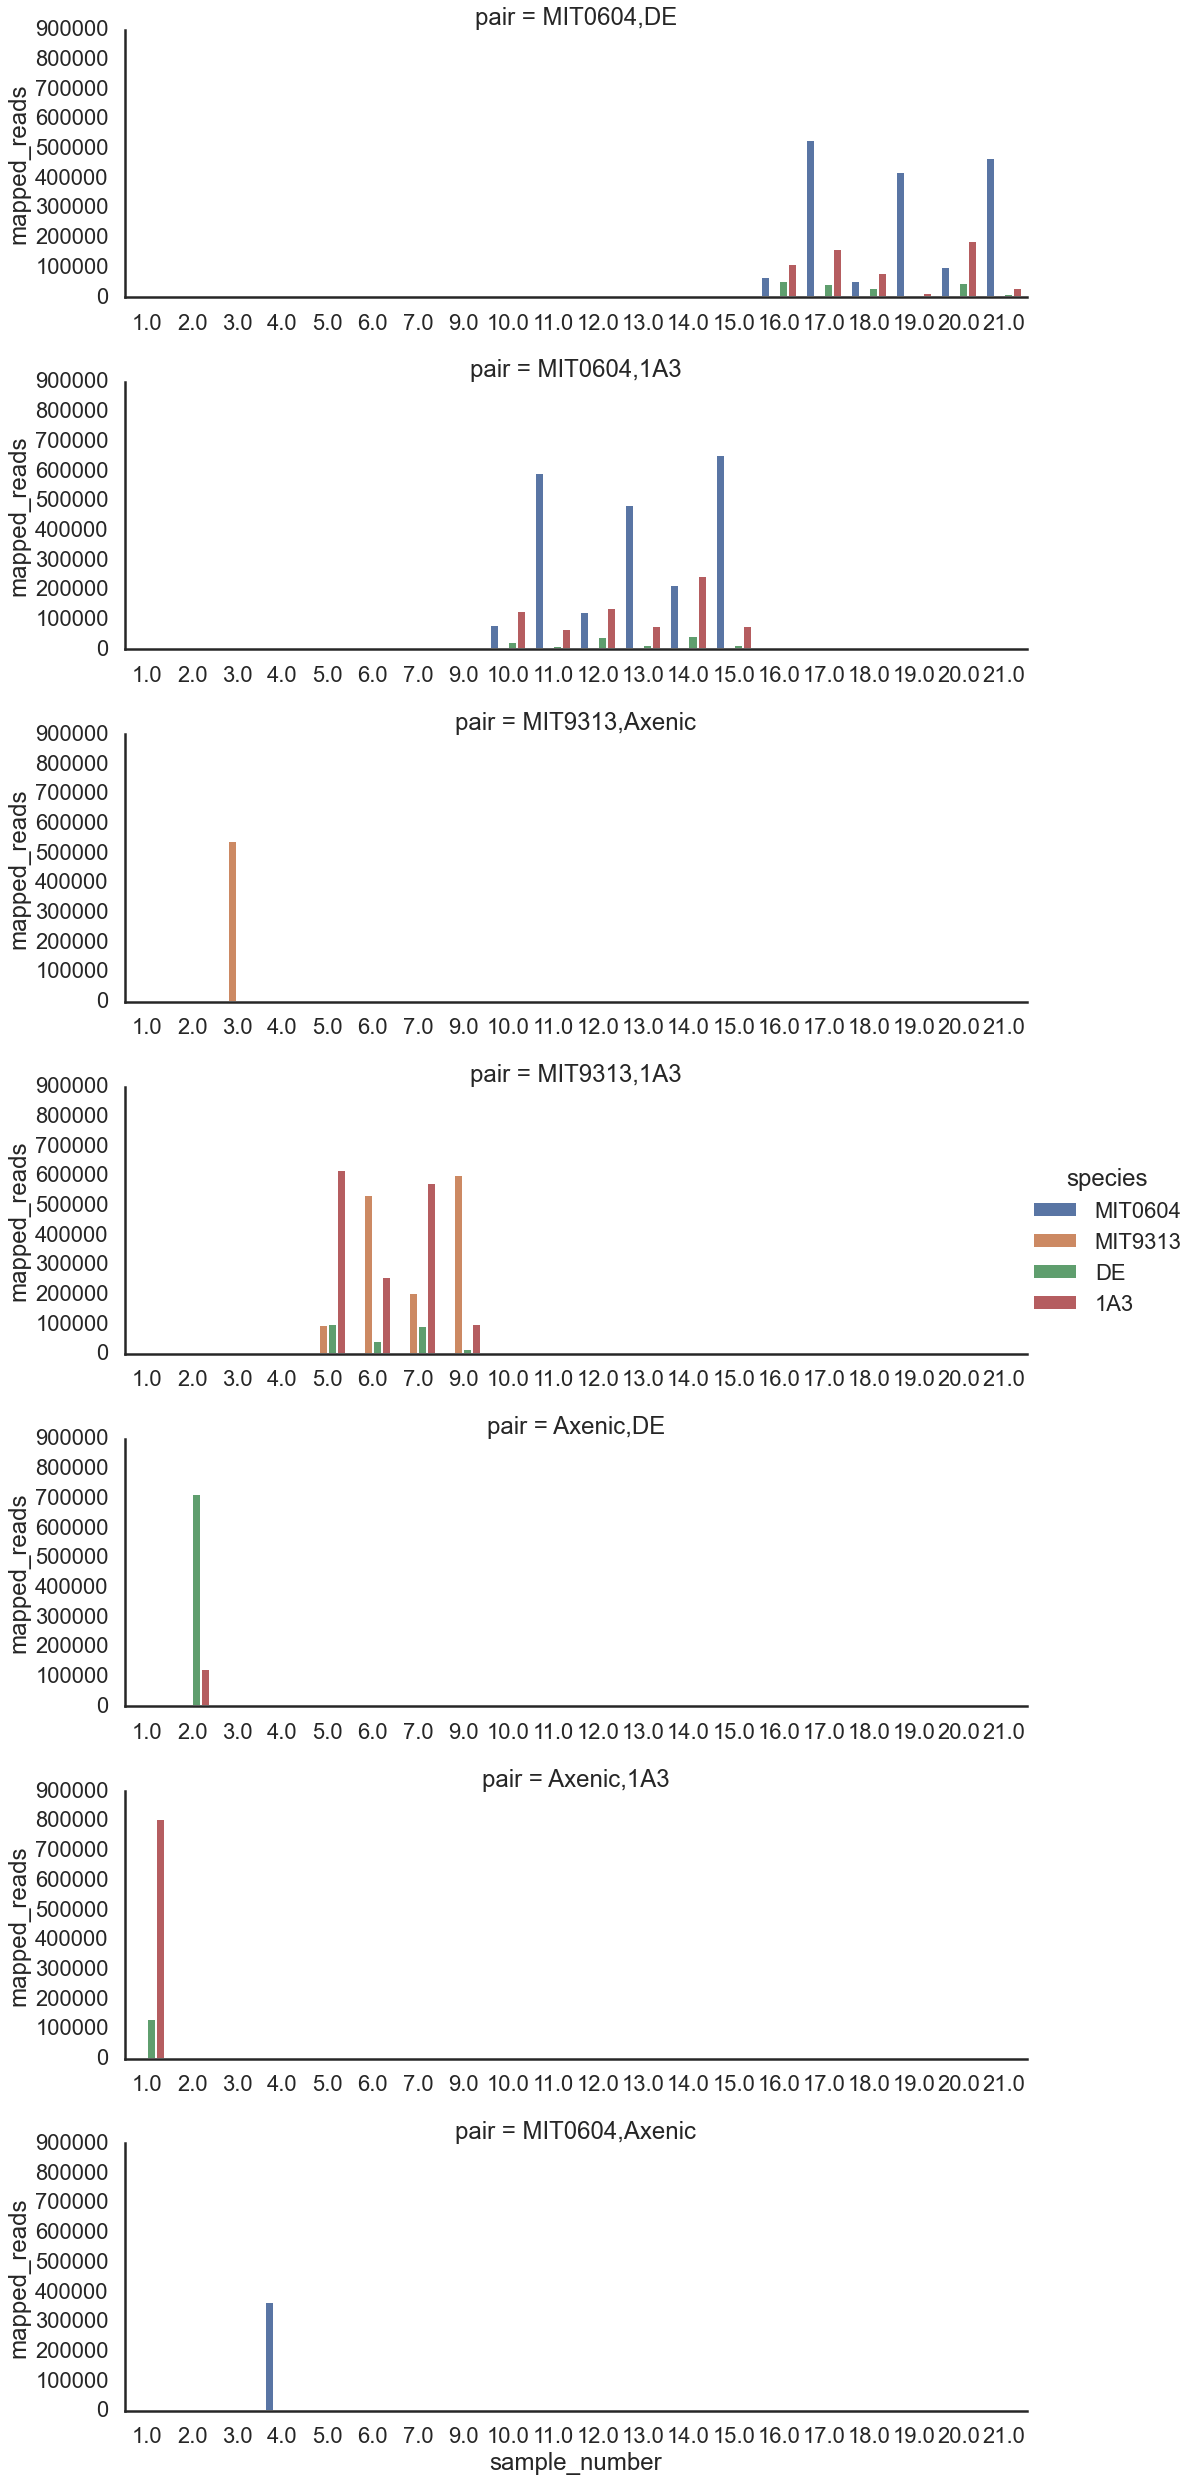

In [30]:
#for i in trimmed_df['pair'].dropna().unique():
sns.catplot(data=trimmed_df.loc[(trimmed_df['command'] == 'bamqc') & (trimmed_df['mode'] == 'all')
 #                                   & (trimmed_df['pair'] == i)
                                   ],
                x='sample_number', y='mapped_reads', 
               hue='species', hue_order=['MIT0604', 'MIT9313', 'DE', '1A3'],
                row='pair', sharex=False,
               aspect=3, kind='bar')
#plt.title(i)

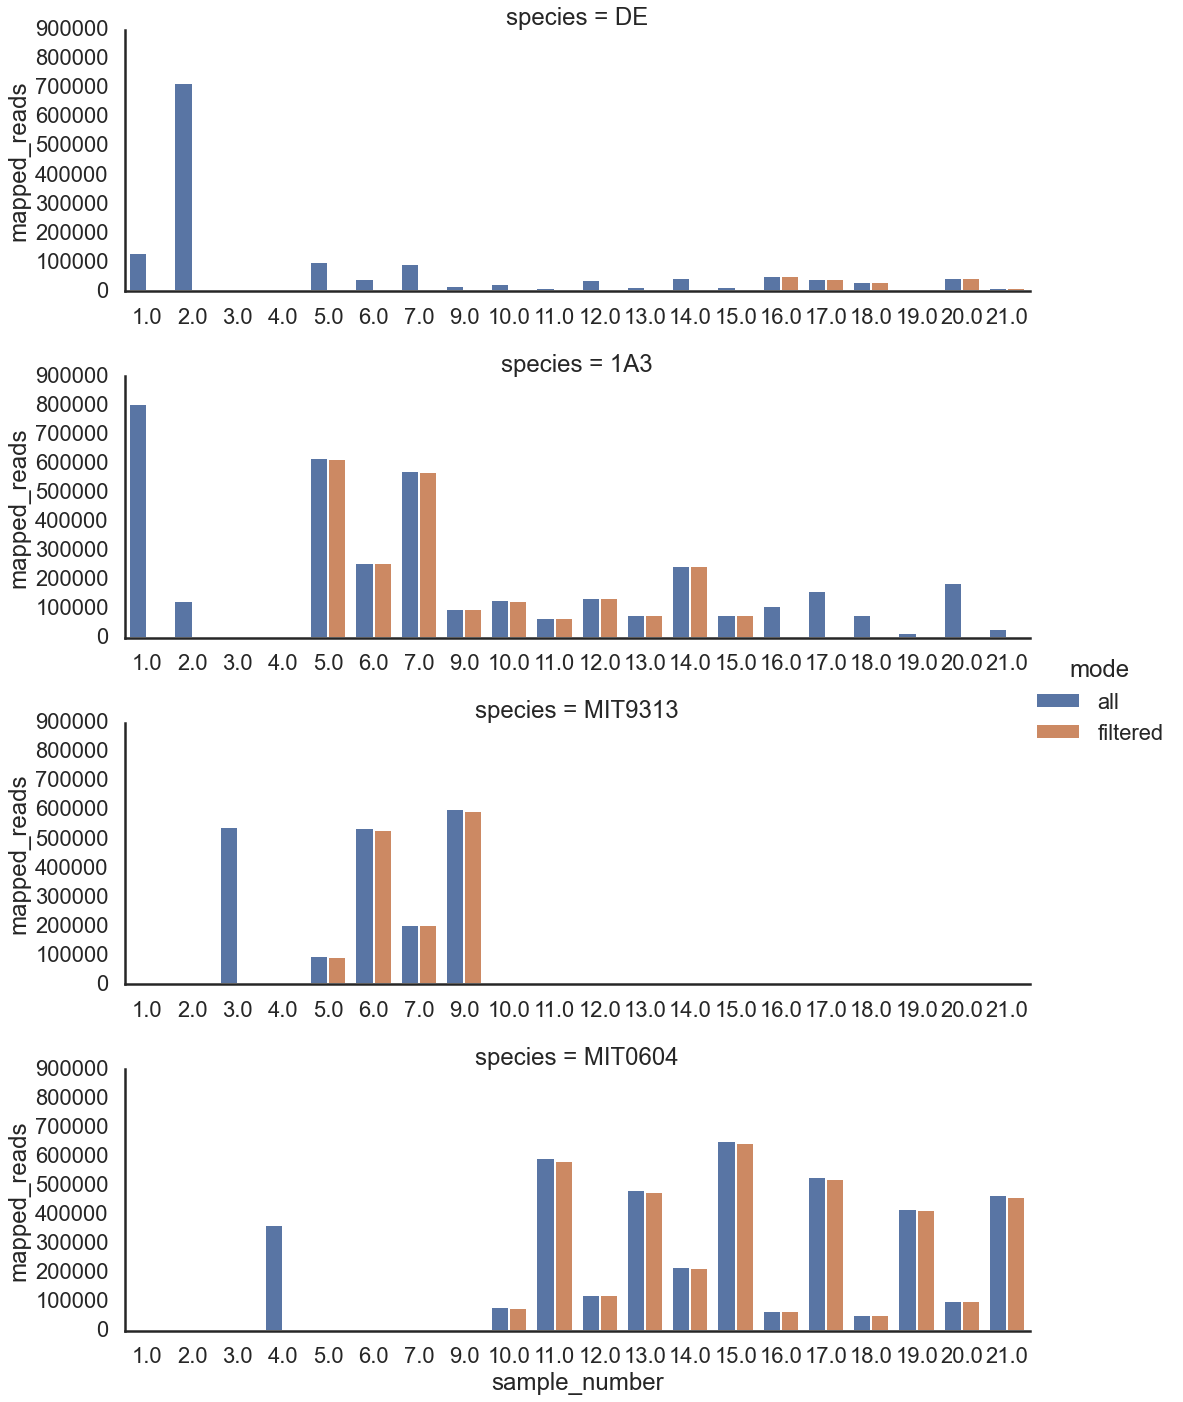

In [31]:
# pd.options.display.float_format = '{:d}'.format
sns.catplot(data=trimmed_df.loc[(trimmed_df['command'] == 'bamqc')],
            x='sample_number', y='mapped_reads', 
           row='species', hue='mode', sharex=False,
           aspect=3, kind='bar')

In [32]:
 trimmed_df.sample_number.dtypes

dtype('float64')

In [33]:
bamqc_df['trim'] = 'adapter'
trimmed_df['trim'] = 'Q>20'
pd.options.display.float_format = '{:.0f}'.format

merged_stat_df = pd.concat([
    bamqc_df.loc[~bamqc_df.species.isin(['Maricaulis '])], 
    trimmed_df.loc[
        (trimmed_df['command'] == 'bamqc') & 
        ((trimmed_df['mode'] == 'filtered') |
         ((trimmed_df['sample_number'] < 5)  & 
          (trimmed_df.PRO == trimmed_df.species) | (trimmed_df.ALT == trimmed_df.species)))
                                            ] 
                                            ],
        )

C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [34]:
merged_stat_df.species = merged_stat_df.species.str.strip()

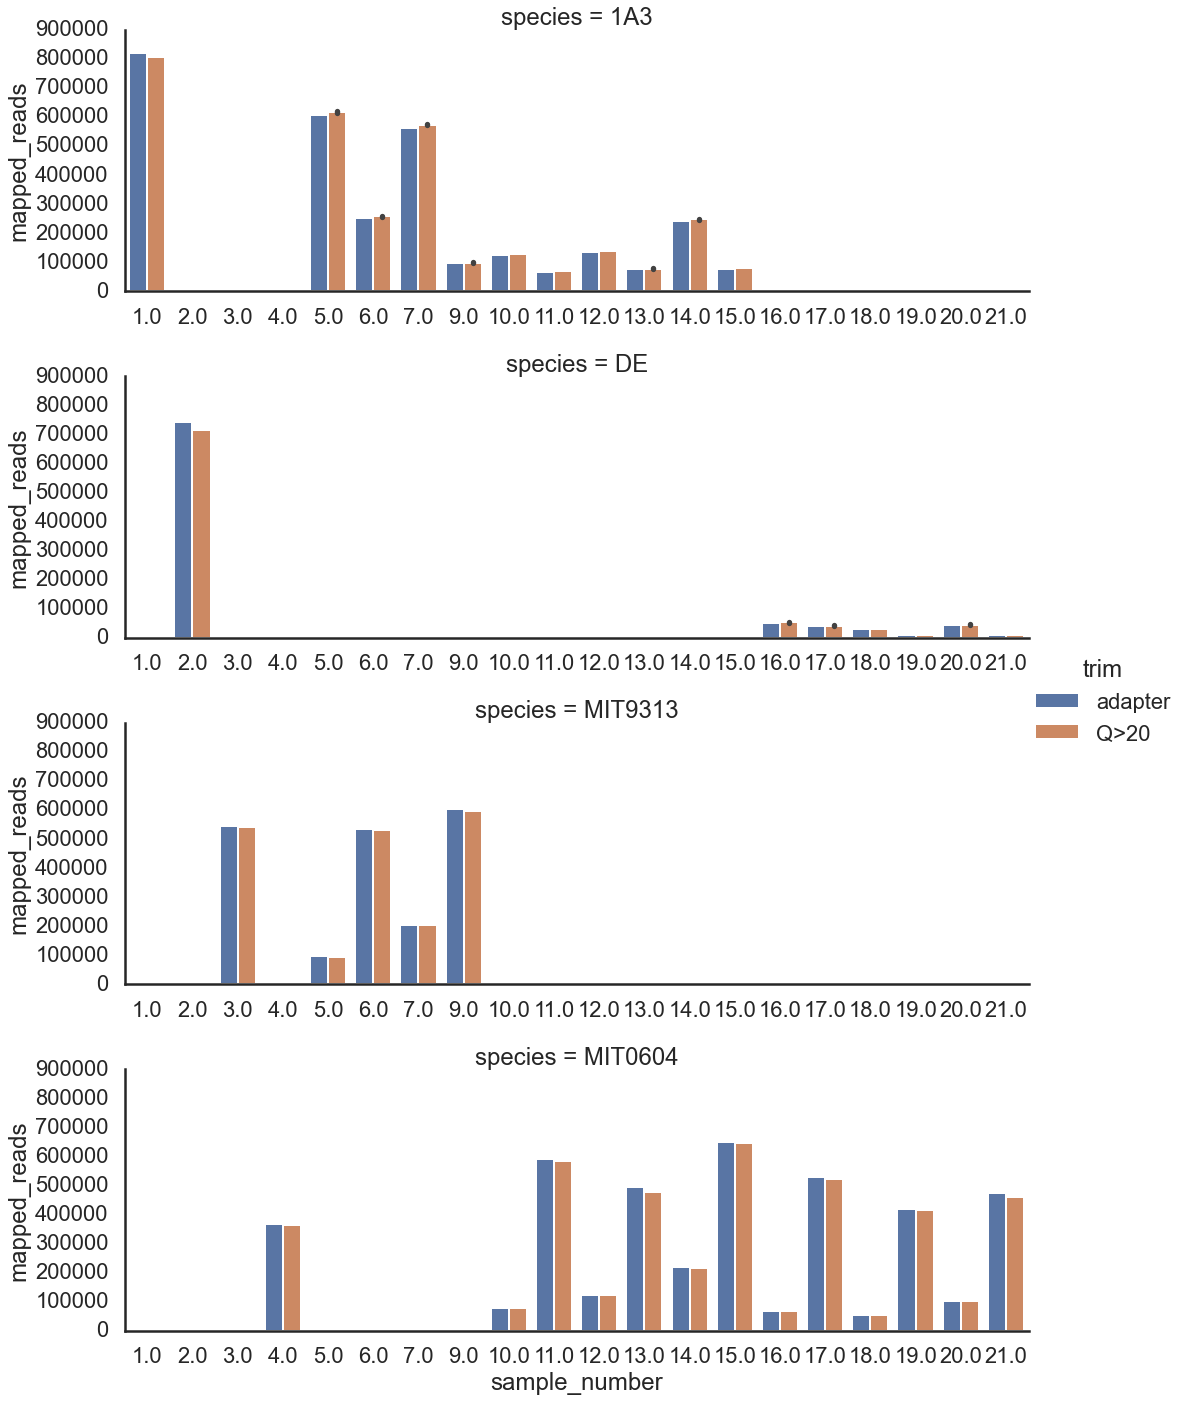

In [35]:
sns.catplot(data=merged_stat_df,
            x='sample_number', y='mapped_reads', 
           row='species', hue='trim', sharex=False,
           aspect=3, kind='bar')

Text(0.5, 1, 'mapped reads')

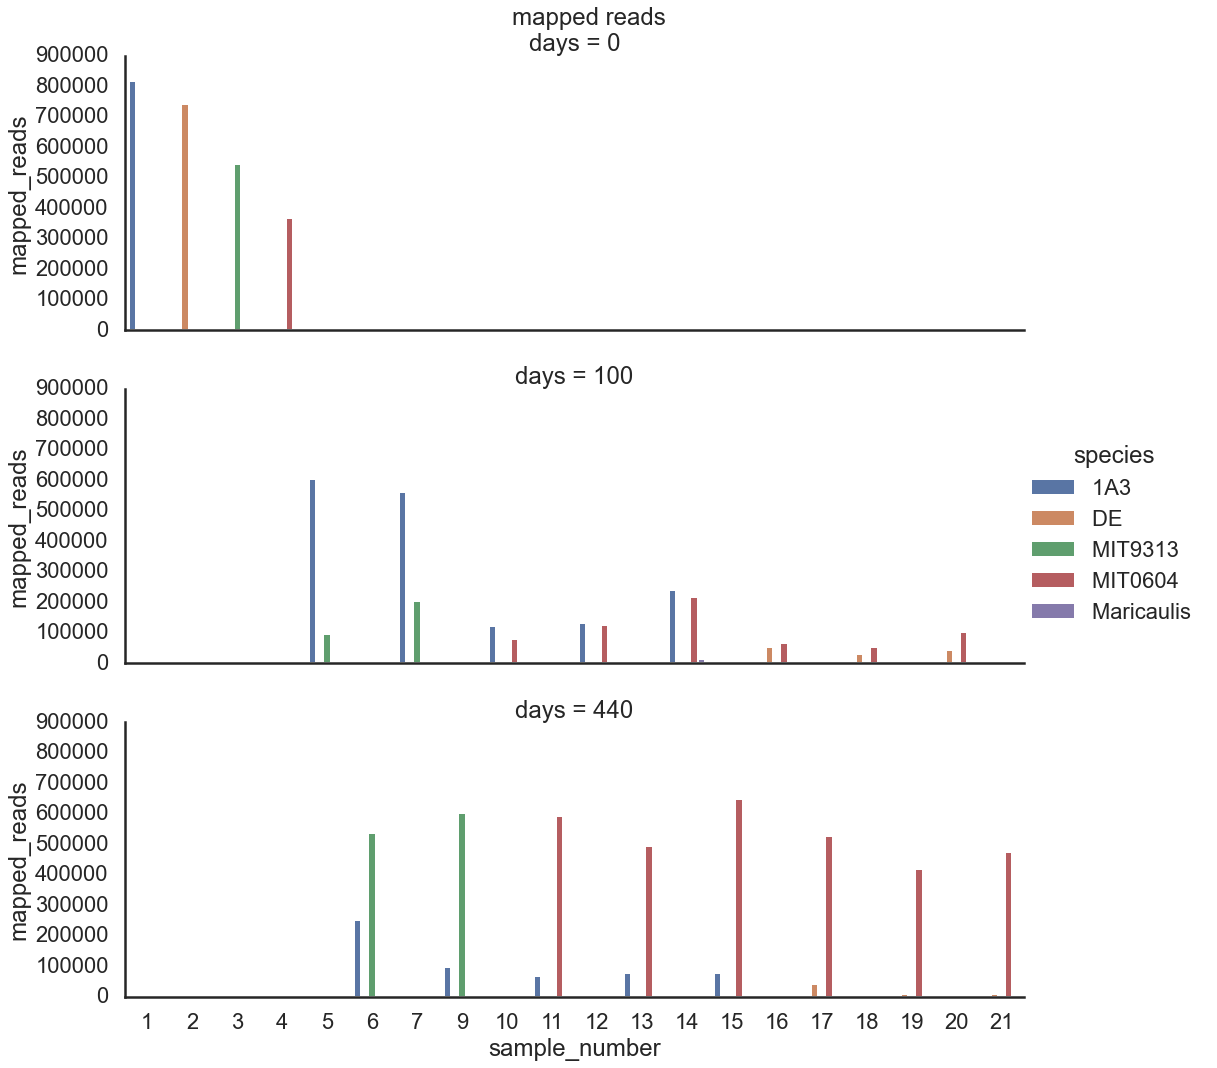

In [36]:
sns.set_style('white')
sns.set_context('poster')
sns.catplot(data=bamqc_df, x='sample_number', y='mapped_reads',hue='species', row='days', 
            kind='bar', aspect=3)
plt.suptitle('mapped reads', y=1)

Text(0.5, 1, '% cov > 10x')

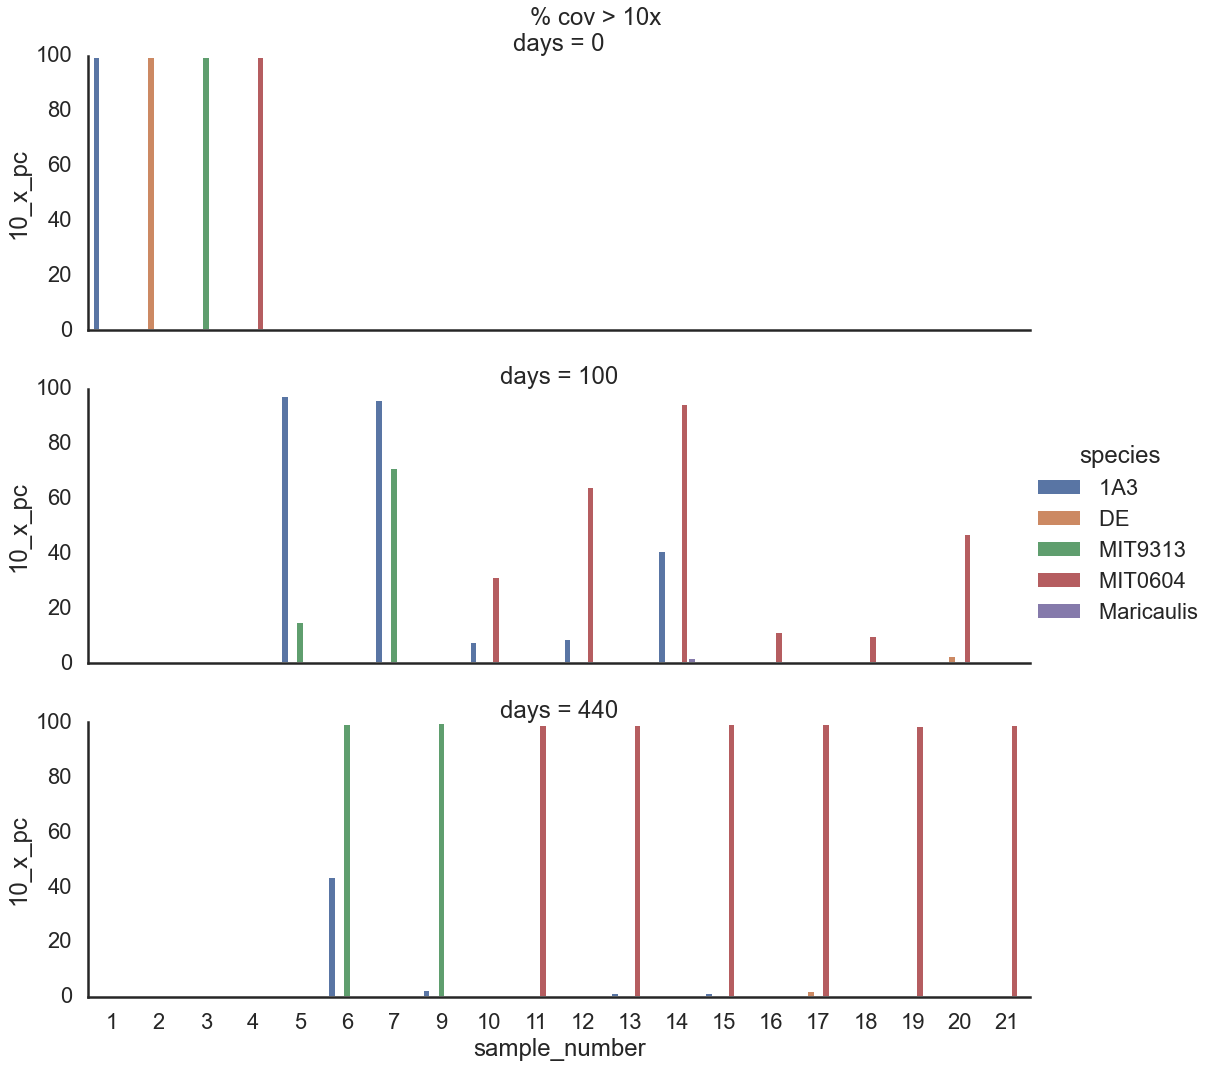

In [37]:
sns.set_style('white')
#sns.set_context('paper')
sns.catplot(data=bamqc_df, x='sample_number', y='10_x_pc',hue='species', row='days', 
            kind='bar', aspect=3)
plt.suptitle('% cov > 10x', y=1)

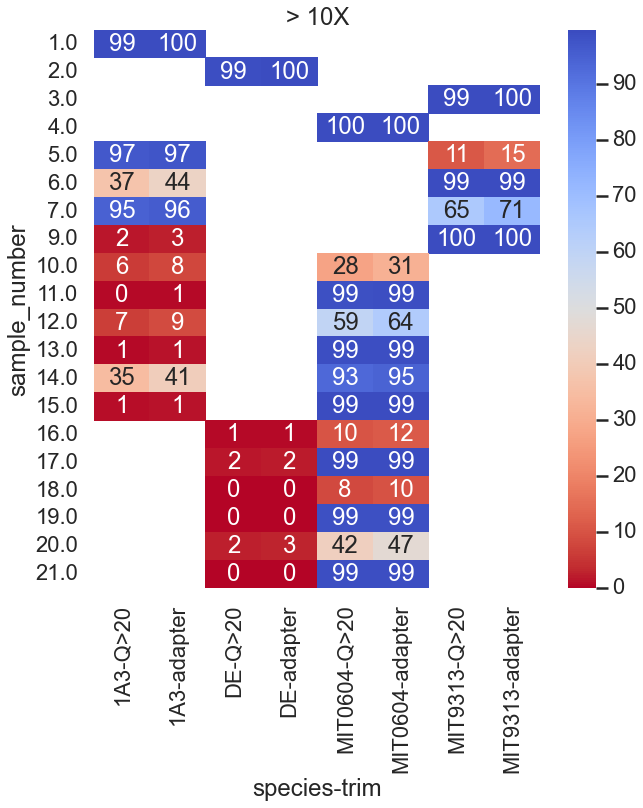

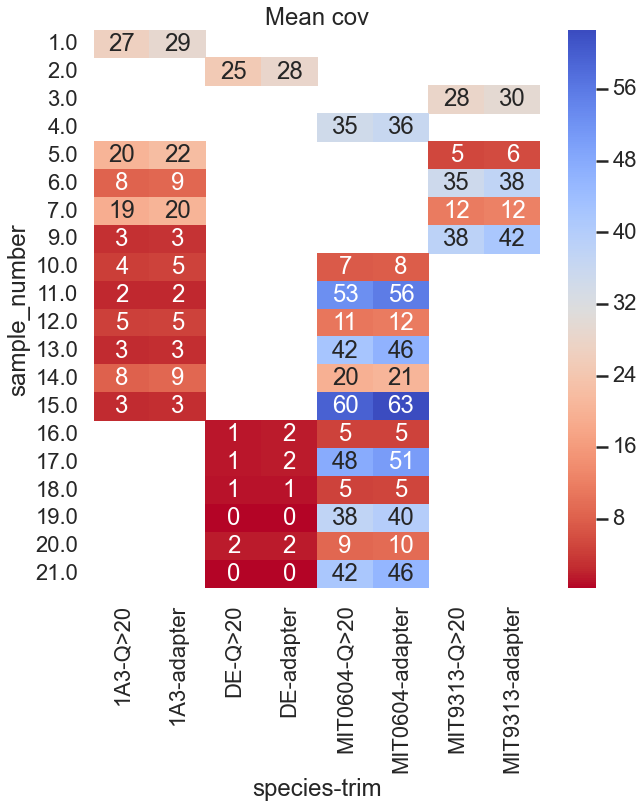

In [38]:
sns.set_context('poster')
value_cols = [  '10_x_pc',
         'mean_coverage',
              #'mapped_reads'
             ]

for v in value_cols:
    # 'sample', 'PRO', 'ALT', 'exp',
    plt.figure(figsize=(10,10))
    
    bamqc_pdf = merged_stat_df.pivot_table(index='sample_number', columns=['species', 'trim'], 
                           values=[v]).droplevel(level=0, axis='columns')
    #bamqc_pdf[pct_cols] = bamqc_pdf[pct_cols]/100
    #bamqc_pdf.rename(columns=qmap_titles, inplace=True)
    sns.heatmap(bamqc_pdf, cmap='coolwarm_r',
                  annot=True, fmt='.0f')
    plt.title(qmap_titles[v])
    plt.show()

In [39]:
#from glob import glob
#data_dpath = os.path.join('DNA','freebayes')
data_dpath = os.path.join('DNA','dnaseq_trimmed')
# ##INFO=<ID=ANN,Number=.,Type=String,
#Description="Functional annotations: 'Allele | Annotation | Annotation_Impact | 
#            Gene_Name | Gene_ID | Feature_Type | Feature_ID | Transcript_BioType | 
#              Rank | HGVS.c | HGVS.p | 
# cDNA.pos / cDNA.length | CDS.pos / CDS.length | AA.pos / AA.length | Distance | ERRORS / WARNINGS / INFO' ">
def _parse_csv(t):
    ANN_columns = [
        'Allele', 'Annotation',  'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
        'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p', 'cDNA.pos',  'CDS.pos', 
        'AA.pos', 'Distance', 'ERRORS'
    ]
    #idx = 160000+i
    #dname = f'D20-{idx}-4500T'
    #glob(os.path.join(data_dpath, dname,'**', '*.csv'), recursive=True)
    fpath = os.path.join(data_dpath, #f'freebayes_{t}',
                         f'freebayes_{t}.tab')
    df =  pd.read_csv(fpath, sep='\t') 
    df['species'] = t
    df.ANN = df.ANN.str.split(',')
    df = df.apply( pd.Series.explode )


    df[ANN_columns] = df['ANN'].str.split('|', expand=True)
    df = df.drop('ANN', axis=1)
    return df

df_MIT9313 = _parse_csv('MIT9313') 
df_MIT0604 = _parse_csv('MIT0604') 
df_DE = _parse_csv('DE') 
df_1A3 = _parse_csv('1A3') 


In [40]:
def parse_freebayes(genome):
    df_s =  _parse_csv(genome) 
    id_vars=['CHROM', 'POS', 'TYPE', 'REF', 'ALT', 
       'species', 'Allele', 'Annotation', 'Impact', 'Gene_Name', 'Gene_ID',
       'Feature_Type', 'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c',
       'HGVS.p', 'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS']


    d = df_s.melt(id_vars=id_vars)
    d['variable'] = d['variable'].str.replace('D20-1600', '')
    d[['sample_number', 'variable']] = d['variable'].str.split('.',expand=True)
    d['sample_number'] = pd.to_numeric(d['sample_number'])

    pdf = d.pivot_table(index=(id_vars+['sample_number']), columns=['variable'], aggfunc='first', #values='value',
                   ).droplevel(level=0, axis='columns').reset_index() 
    
    pdf['good_call'] = (pdf.DP > 10) & (pdf.GQ > 20)
    mask = (~pdf.AO.astype(str).str.contains(',', na=False, regex=False) & 
            ~pdf.DP.astype(str).str.contains(',', na=False, regex=False) &
            (pdf['DP'] != 0) & pdf['good_call'])
    try: 
        pdf.loc[mask, 'fraction_Alt'] = pdf.loc[mask, 'AO'] / pdf.loc[mask, 'DP']
    except Exception:
        pdf['fraction_Alt'] = ''

    
    pdf['culture'] = 'Co_Culture'
    pdf.loc[pdf['sample_number']<=4, 'culture'] = 'Axenic'
    
    df_genome = pd.read_feather(os.path.join('DNA', 'genomes',f'{genome}.ncbi.gb.feather.gz'))
    #df_DE_MIT9313 = pd.read_excel(os.path.join('DNA', 'genomes','41396_2016_BFismej201670_MOESM46_ESM.xlsx'),
    #                          sheet_name='9313+1A3')
    genome_cols = ['gene_id', 'pmt_id', 'type',  'strand', 
       'product', 'protein_id']
    mpdf = pd.merge(pdf, 
                    df_genome[genome_cols], left_on='Gene_Name', right_on='gene_id', 
                    how='left'
                   )
    #mpdf[['PMTID1', 'PMTID2']] = mpdf.pmt_id.str.split(',', expand=True)
    mpdf = pd.merge(mpdf, meta_df, on='sample_number', how='left')
    mpdf['good_call'] = (mpdf.DP > 10) & (mpdf.GQ > 20)
    mpdf.loc[mpdf.good_call & (mpdf.ALT_x == mpdf.GT), 'call'] = 1
    mpdf.loc[mpdf.good_call & (mpdf.REF == mpdf.GT), 'call'] = 0
    mpdf.loc[mpdf.good_call & (mpdf.REF != mpdf.GT) & (mpdf.ALT_x != mpdf.GT), 'call'] = -1
    return mpdf

In [41]:
genome='MIT9313'
df_genome = pd.read_feather(os.path.join('DNA', 'genomes',f'{genome}.ncbi.gb.feather.gz'))
df_genome.columns

C:\Users\wosnat\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Index(['contig_id', 'gene_id', 'pmt_id', 'type', 'location', 'strand', 'start',
       'stop', 'left', 'right', 'function', 'genome', 'old_locus_tag',
       'product', 'db_xref', 'protein_id', 'figfam', 'nucleotide_sequence',
       'aa_sequence'],
      dtype='object')

In [42]:
dfs = dict()
for s in ['MIT0604', 'MIT9313', 'DE', '1A3']:
    dfs[s] = parse_freebayes(s)


In [43]:
df_DE_MIT9313 = pd.read_excel(os.path.join('DNA', 'genomes','41396_2016_BFismej201670_MOESM46_ESM.xlsx'),
                              sheet_name='9313+1A3')
df_DE_MIT9313.rename(columns={'log 2 fold change coculture/axenic' : 'log Fold Change'}, inplace=True)
de_cols = ['Synonym', 'q Value ', 'log Fold Change']
dfs['MIT9313'][['PMTID1', 'PMTID2']] = dfs['MIT9313'].pmt_id.str.split(',', expand=True)

dfs['MIT9313'] = pd.merge(dfs['MIT9313'], 
                df_DE_MIT9313[de_cols], left_on='PMTID1', right_on='Synonym', 
                how='left'
               )


In [44]:
all_cols = ['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'species', 'Allele',
       'Annotation', 'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
       'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p',
       'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS', 'sample_number',
       'AO', 'DP', 'RO', 'fraction_Alt', 'culture', 'gene_id', 'pmt_id',
       'type', 'strand', 'product', 'pmt_id', 'PMTID2', 'Synonym', 'q Value ',
       'log Fold Change', 'sample', 'PRO', 'ALT_y', 'exp',
       'days', 'ng/ul', 'final volume']
 

index_cols = ['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'Annotation', 'Impact',
              'HGVS.p', 'HGVS.c', 'CDS.pos', 'AA.pos',
              'gene_id', 'pmt_id', 'type', 'strand', 'product']
additional_index_cols = ['q Value ', 'log Fold Change',]

column_cols = ['PRO', 'ALT_y', 'days','sample', ]
value_cols = ['call', 'fraction_Alt', 'DP', 'AO', 'RO','GQ','GT',  ]
species= 'MIT9313'


condition_format_cols = {
    'MIT9313' : ['T7:X10000', 'Y7:AC10000' ],
    'MIT0604' : ['R7:AD10000', 'AE7:AQ10000' ],
    '1A3' : ['R7:AB10000', 'AC7:AM10000' ],
    'DE' : ['R7:X20000', 'Y7:AE10000' ],
    
}  
fraction_cols = {
    'MIT9313' :  'Y:AC',
    'MIT0604' :  'AE:AQ',
    '1A3' : 'AC:AM' ,
    'DE' :  'Y:AE' ,
    
}  


#agg_f = lambda x : ' | '.join(x.unique())
with pd.ExcelWriter('var_calls_5x5_MIT9313.xlsx', engine='xlsxwriter') as writer:  
    workbook  = writer.book
    format1 = workbook.add_format({'num_format': '#,##0.00'})
    format2 = workbook.add_format({'num_format': '0%'})
    for species, col in zip(['MIT9313', 'MIT0604', '1A3', 'DE'], ['PRO', 'PRO', 'ALT_y', 'ALT_y']):
        actual_index_cols = index_cols
        if species == 'MIT9313':
            actual_index_cols = index_cols + additional_index_cols
        excel_pdf = dfs[species].loc[dfs[species]['type'].isin(['CDS'])].fillna('').pivot_table(
            index=actual_index_cols, columns=column_cols,
            aggfunc='first', margins=False, values=value_cols,
            fill_value='',
        ).reindex(columns=value_cols, level=0,
        ).reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',
        ).reindex(columns=['Axenic', 'MIT9313', 'MIT0604'], level='PRO',).reset_index()
        excel_pdf = excel_pdf.loc[excel_pdf['call'].replace('',np.NaN).std(axis=1) != 0]
        sheetname = f'{species} calls'
        excel_pdf.to_excel(writer, sheet_name=sheetname)
        worksheet = writer.sheets[sheetname]
        worksheet.set_column(fraction_cols[species], None, format1)
        if species == 'MIT9313':
            worksheet.set_column('R:S', None, format1)
        worksheet.set_column('Q:Q', 30)  # Col 1 has format1.
        worksheet.set_column('G:G', 12)  # Col 1 has format1.
                
        worksheet.conditional_format(condition_format_cols[species][0], 
                                     {'type': '2_color_scale',                               
                                      'min_color': '#b7efcd', 
                                    #  'mid_color': 'yellow', 
                                      'max_color': '#ffbcbc'
                                     })
        worksheet.conditional_format(condition_format_cols[species][1],  
                                     {'type': '2_color_scale',                               
                                      'min_color': 'white', 
                                    #  'mid_color': 'yellow', 
                                      'max_color': '#f69e7b'
                                     })
        #worksheet.conditional_format(f'K1:L{bamqc_df.shape[0]+2}', {'type': 'data_bar', 'bar_color' : 'green'})


In [45]:
dfs[species].columns

Index(['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'species', 'Allele',
       'Annotation', 'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
       'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p',
       'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS', 'sample_number',
       'AO', 'DP', 'GQ', 'GT', 'RO', 'good_call', 'fraction_Alt', 'culture',
       'gene_id', 'pmt_id', 'type', 'strand', 'product', 'protein_id',
       'sample', 'PRO', 'ALT_y', 'exp', 'days', 'ng/ul', 'final volume',
       'call'],
      dtype='object')

Text(0.5, 1.0, 'MIT9313 calls')

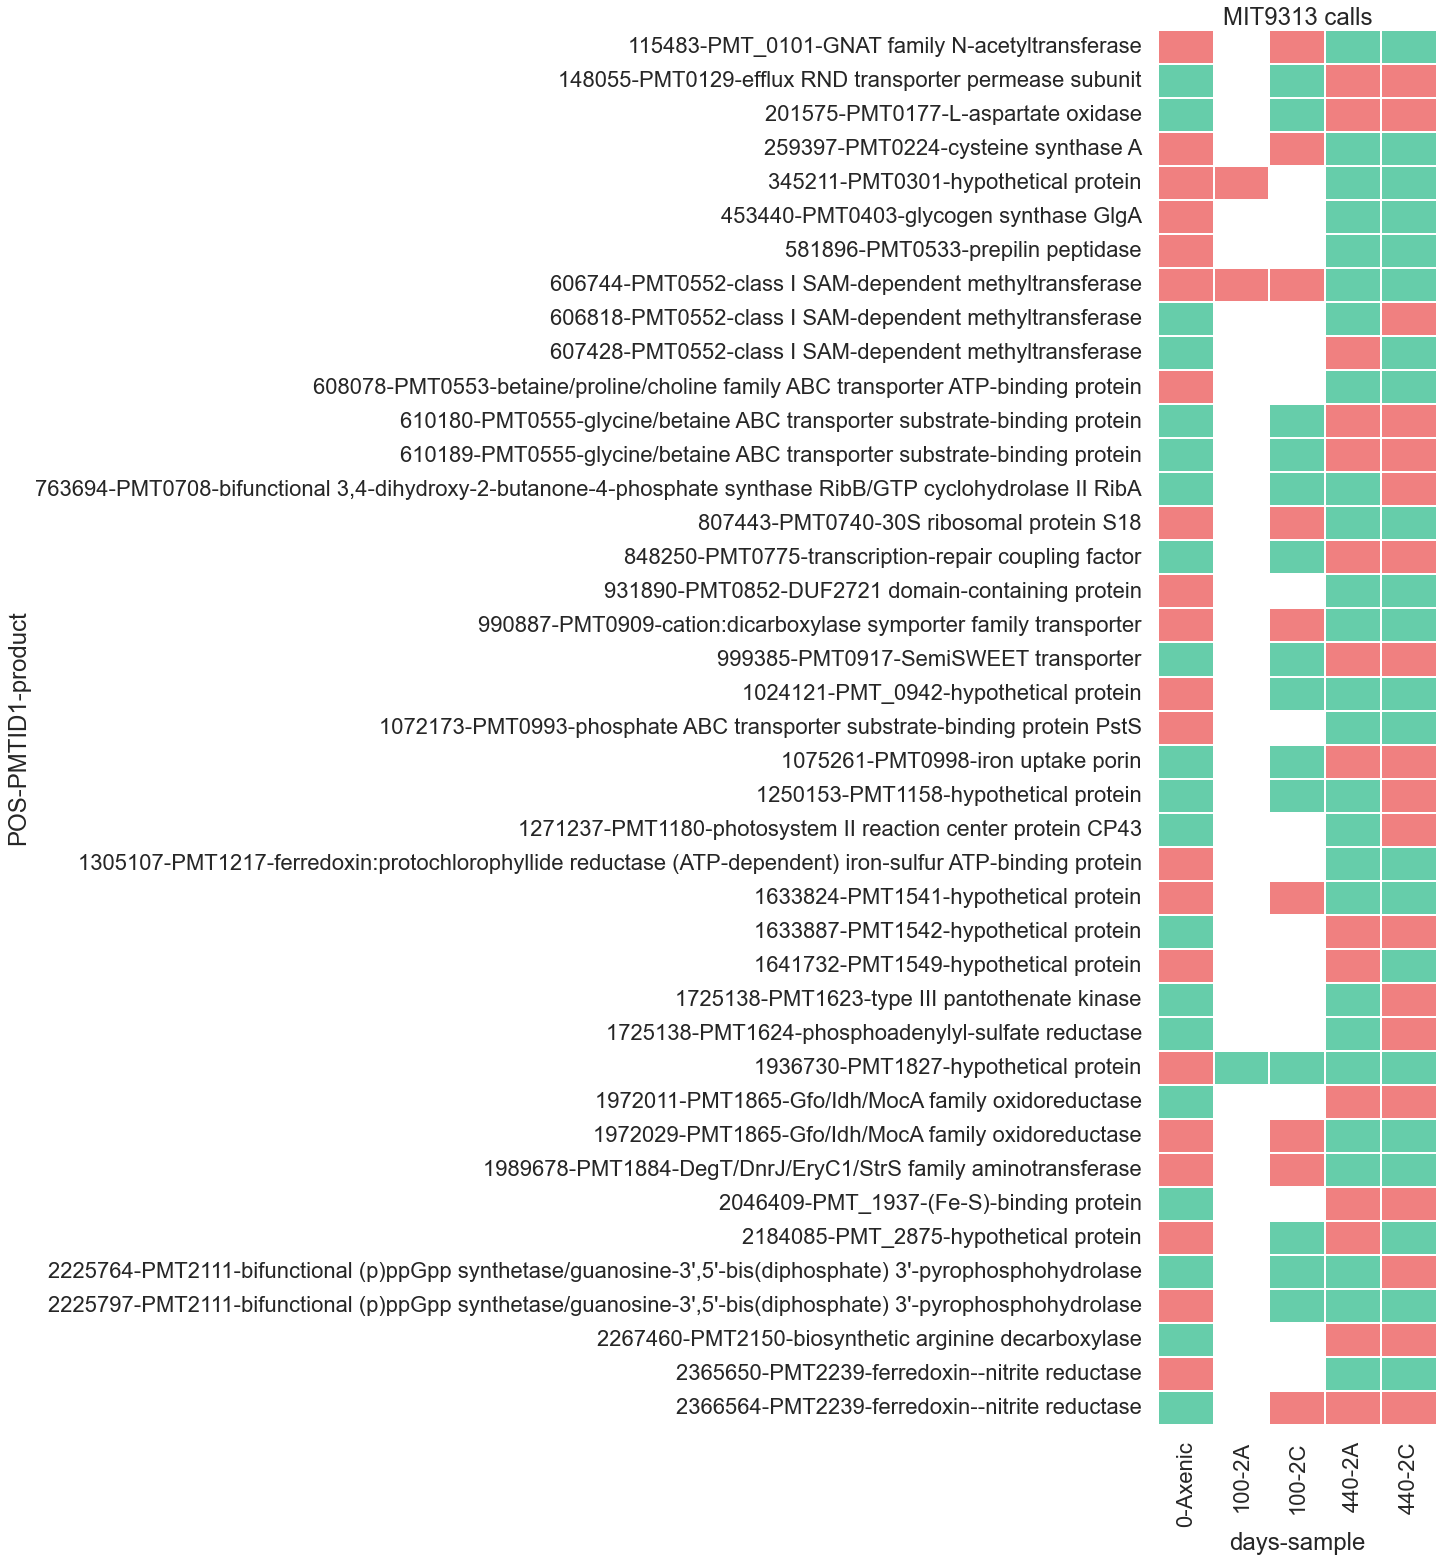

In [46]:
species = 'MIT9313'
plt.figure(figsize=(5,25))
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['POS', 'PMTID1', 'product',], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1], #.sort_values((  0, 'Axenic')),
            cmap=['MediumAquamarine', 'lightcoral'],
            linewidths=1, linecolor='white', cbar=False)
plt.title(f'{species} calls')

In [47]:
species = 'MIT9313'
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['protein_id', 'gene_id', 'product'], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
pvdf = pvdf.reset_index()
pvdf.loc[pvdf.std(axis=1) > 1e-1]
good_call_gene_ids = pvdf.loc[pvdf.std(axis=1) > 1e-1, 'gene_id']
dfs[species]['diff_snp'] = False
dfs[species].loc[dfs[species]['gene_id'].isin(good_call_gene_ids), 'diff_snp'] = True



In [48]:
dfs[species].head()

CHROM    POS   TYPE REF ALT_x  species Allele          Annotation  \
0  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
1  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
2  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
3  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
4  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   

  Impact      Gene_Name  ...   days  ng/ul final volume call   PMTID1  \
0   HIGH  AKG35_RS00340  ...      0      1          100    1  PMT0064   
1   HIGH  AKG35_RS00340  ...    100      1          100  nan  PMT0064   
2   HIGH  AKG35_RS00340  ...    440      1          100    1  PMT0064   
3   HIGH  AKG35_RS00340  ...    100      2          100  nan  PMT0064   
4   HIGH  AKG35_RS00340  ...  empty  empty        empty  nan  PMT0064   

     PMTID2  Synonym q Value  log Fold Change diff_snp  
0  PMT_0064  PMT0064        1              -1    False  
1  PMT_0064  PMT0064        1              -1    False  
2  PMT_0064  PMT0064        1              -1    False  
3  PMT_0064  PMT0064        1              -1    False  
4  PMT_0064  PMT0064        1              -1    False  

[5 rows x 51 columns]

Text(0.5, 1.0, 'MIT0604 calls')

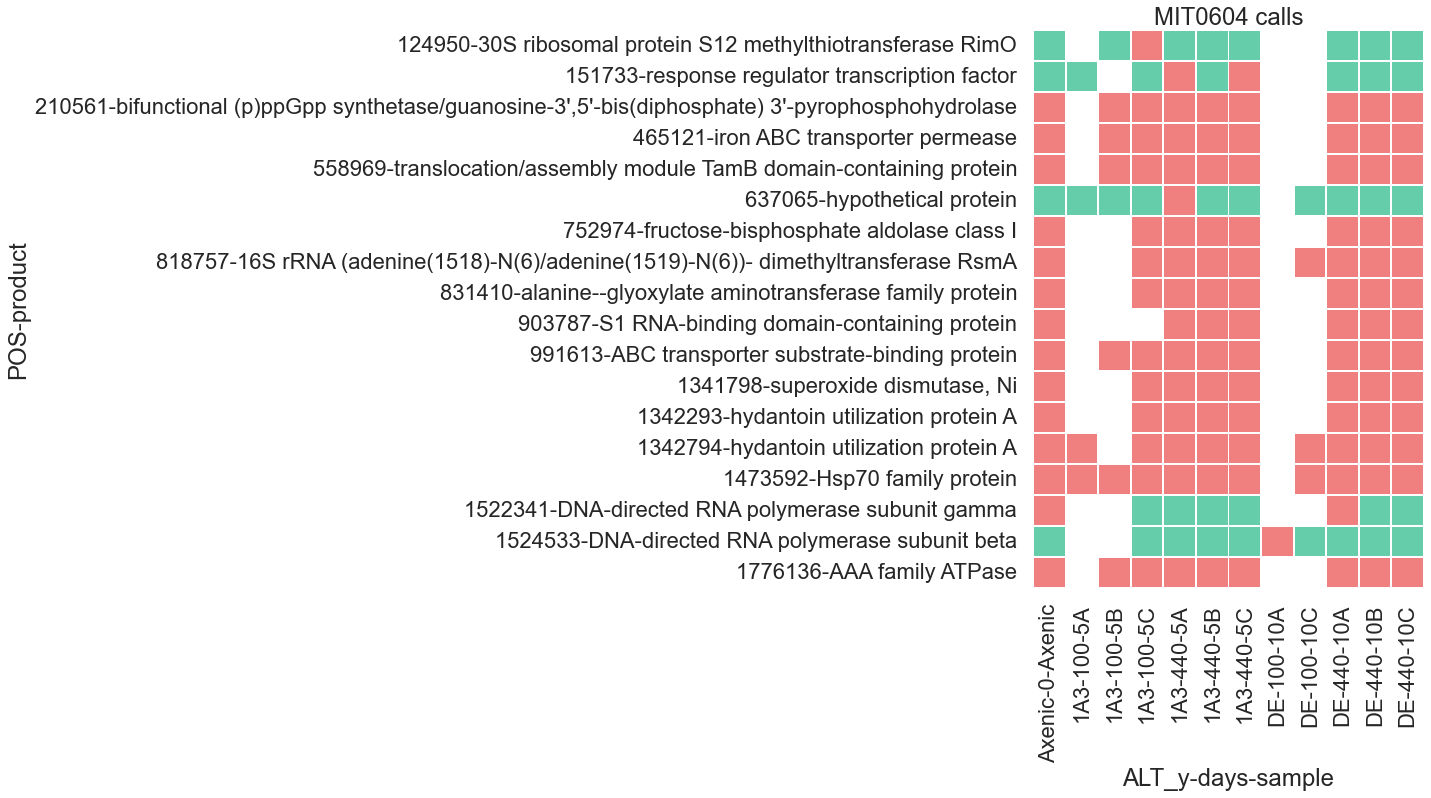

In [49]:
species = 'MIT0604'
plt.figure(figsize=(7,10))
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=[ 'POS', 'product',], 
                                                columns=[ 'ALT_y', 'days','sample'], 
                                                                values='call', aggfunc='first')
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
sns.heatmap(pvdf, #.loc[pvdf.std(axis=1) > 1e-1], #.sort_values(( 0, 'Axenic','Axenic', )),
            cmap=['MediumAquamarine', 'lightcoral'],
            linewidths=1, linecolor='white', cbar=False)
plt.title(f'{species} calls')

Text(0.5, 1.0, 'MIT0604 calls')

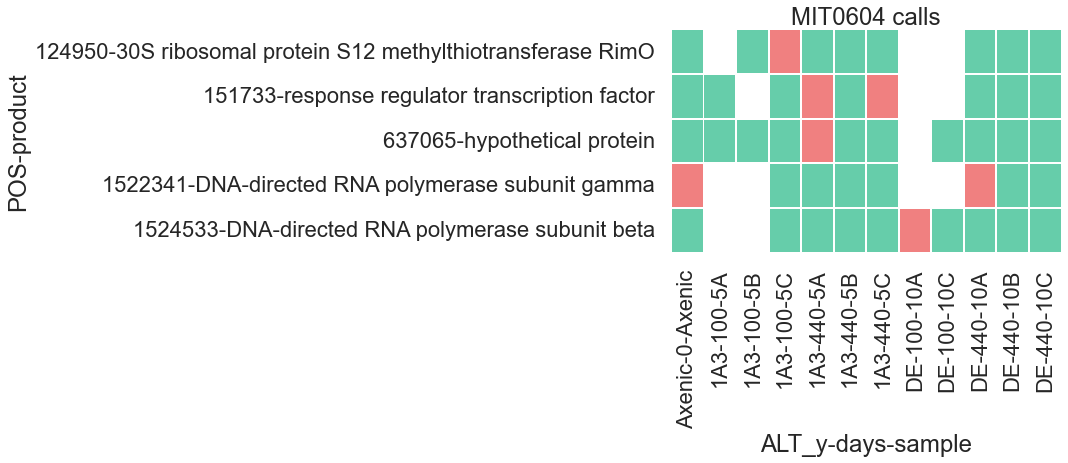

In [50]:
species = 'MIT0604'
plt.figure(figsize=(7,4))
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=[ 'POS','product',], 
                                                columns=[ 'ALT_y', 'days','sample'], 
                                                                values='call', aggfunc='first')
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1], #.sort_values(( 0, 'Axenic','Axenic', )),
            cmap=['MediumAquamarine', 'lightcoral'],
            linewidths=1, linecolor='white', cbar=False)
plt.title(f'{species} calls')

Text(0.5, 1.0, 'Fraction of Alternate Allele')

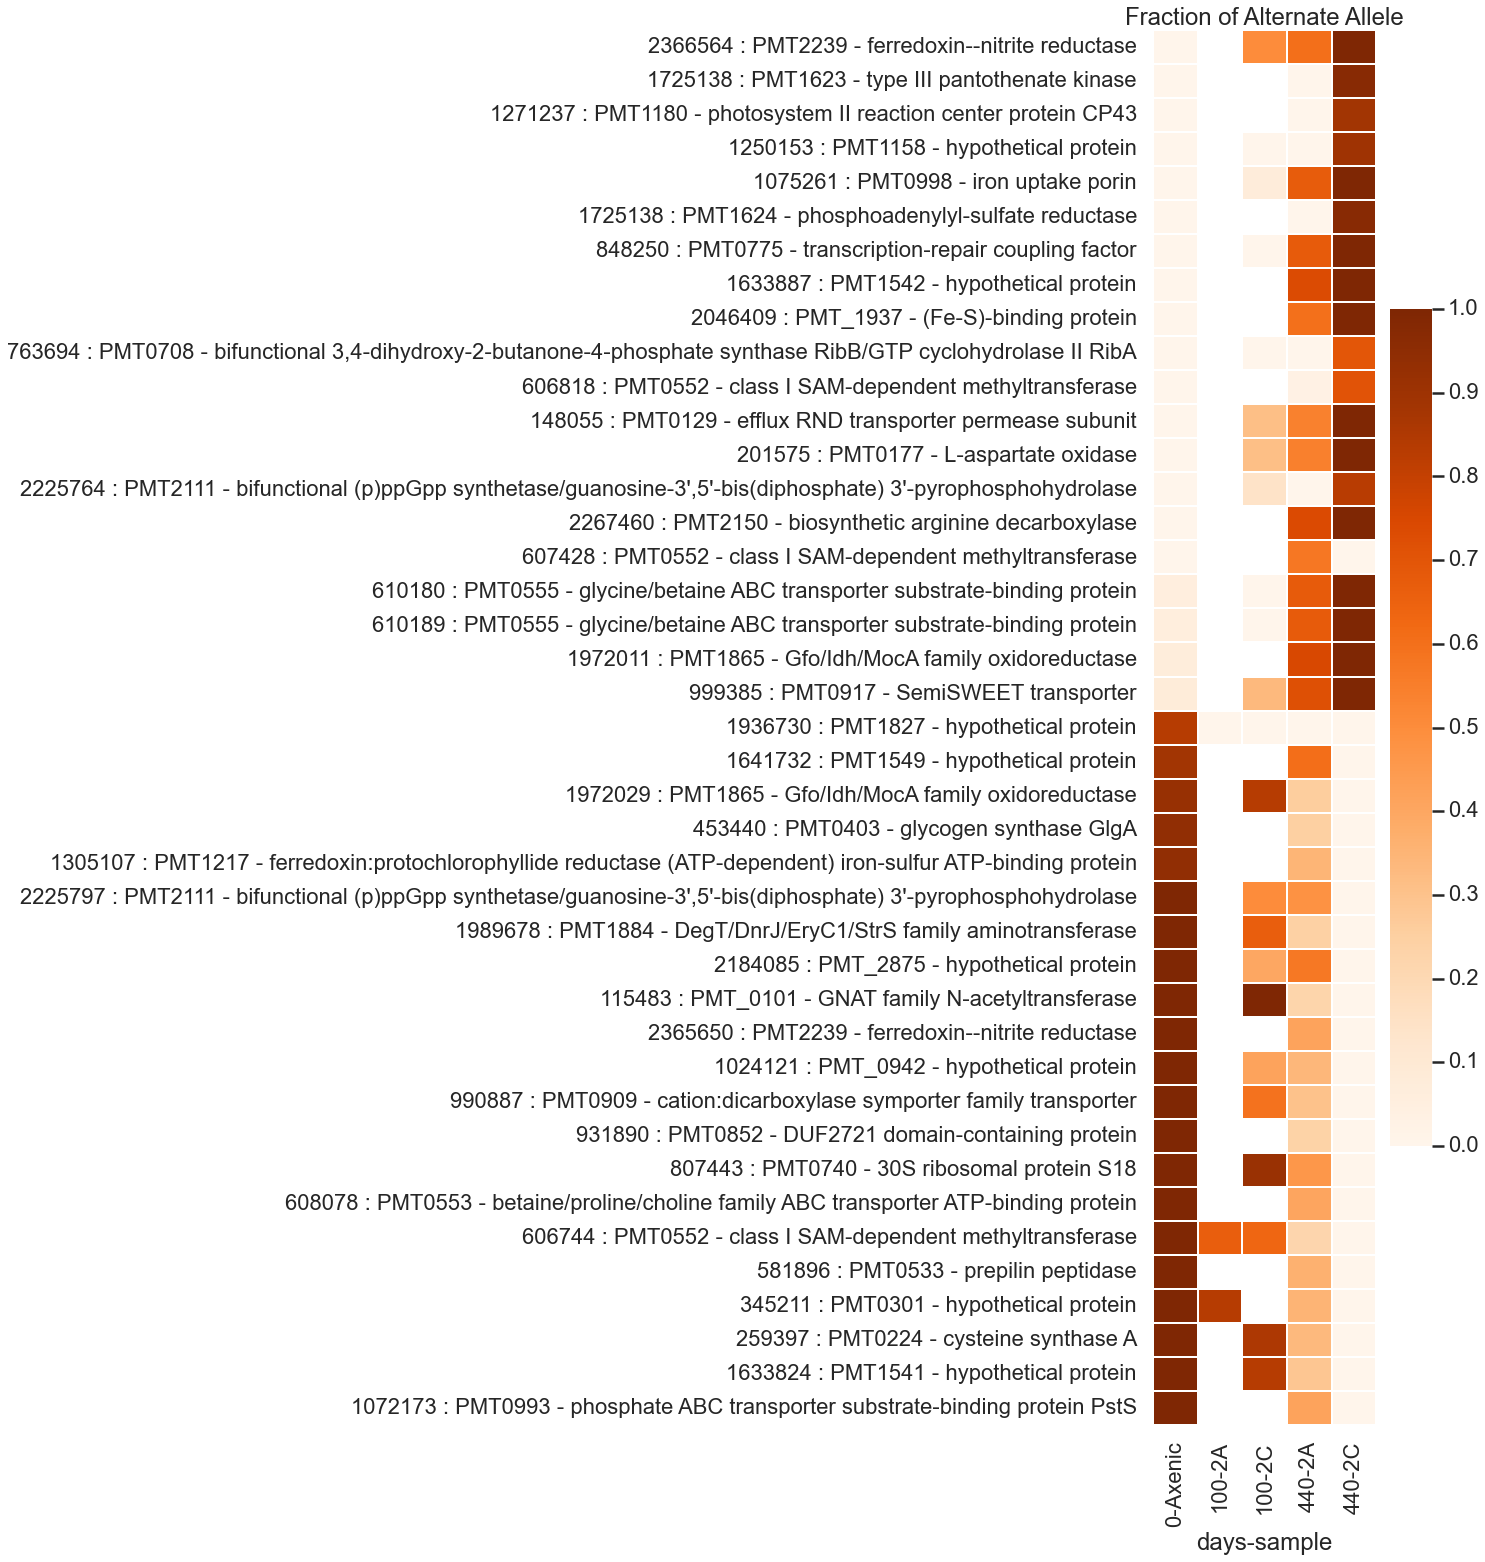

In [51]:
species = 'MIT9313'
plt.figure(figsize=(5,25))
pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].good_call)
               ].pivot_table(index=[ 'POS', 'PMTID1', 'product',], 
                                                columns=[ 'days','sample',], values='fraction_Alt', aggfunc='first')
pvdf.index = [f'{col[0]} : {col[1]} - {col[2]}' for col in pvdf.index.values]
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1].sort_values((  0, 'Axenic')),
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
           )
plt.title('Fraction of Alternate Allele')

Text(0.5, 1.0, 'MIT0604: fraction of Alternate Allele')

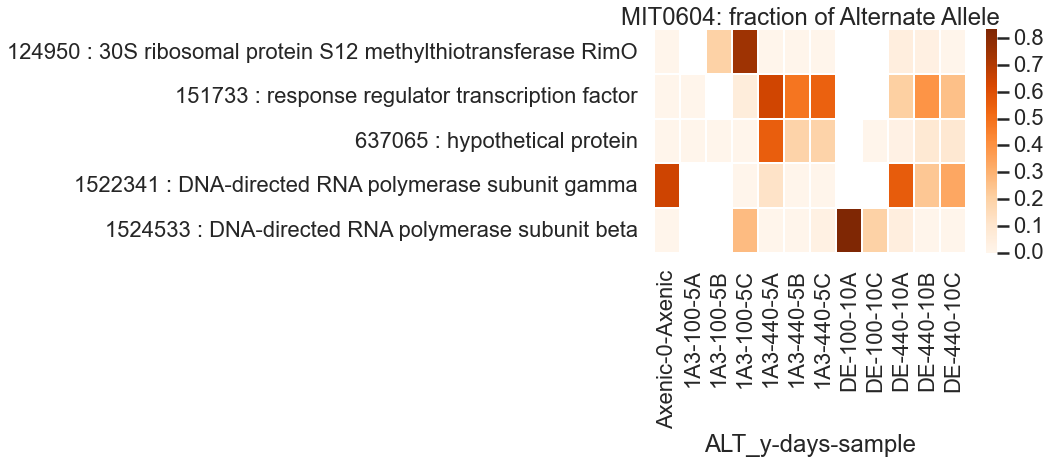

In [52]:
species = 'MIT0604'
plt.figure(figsize=(7,4))
pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].good_call)
               ].pivot_table(index=[ 'POS', 'product',], 
                                                columns=[ 'ALT_y', 'days','sample',], values='fraction_Alt', aggfunc='first')
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
pvdf.index = [f'{col[0]} : {col[1]}' for col in pvdf.index.values]
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1], #.sort_values((  0, 'Axenic')),
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
           )
plt.title(f'{species}: fraction of Alternate Allele')

Text(0.5, 1.0, 'MIT0604: fraction of Alternate Allele')

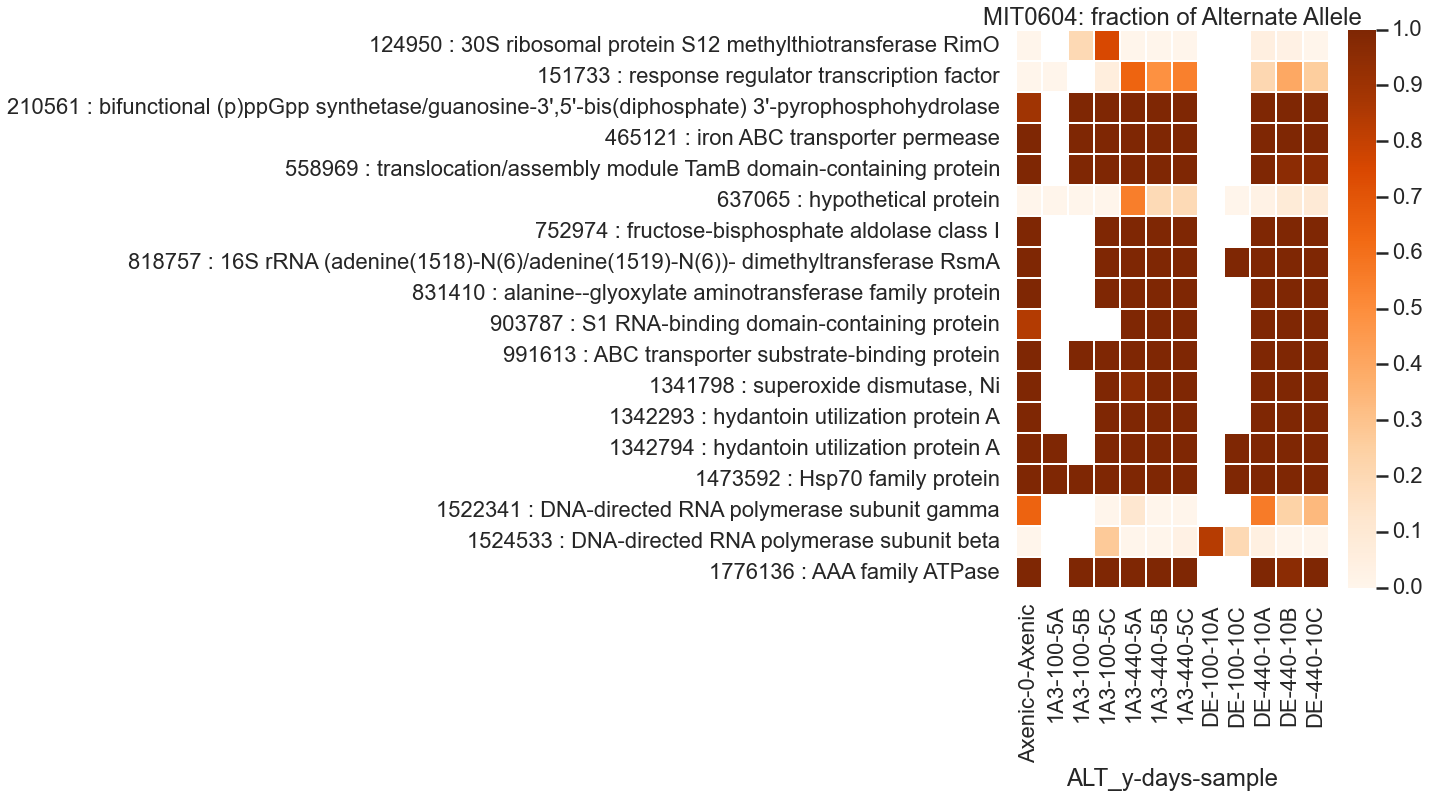

In [53]:
species = 'MIT0604'
plt.figure(figsize=(7,10))
pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & 
                         dfs[species].good_call & 
                        (dfs[species].PRO == species)
               ].pivot_table(index=[ 'POS', 'product',], 
                             columns=[ 'ALT_y', 'days','sample',], 
                             values='fraction_Alt', aggfunc='first', #dropna=False
                            )
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
pvdf.index = [f'{col[0]} : {col[1]}' for col in pvdf.index.values]
sns.heatmap(pvdf, #.loc[pvdf.std(axis=1) > 1e-1], #.sort_values((  0, 'Axenic')),
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
           )
plt.title(f'{species}: fraction of Alternate Allele')

In [54]:
pvdf.head()

ALT_y                                              Axenic 1A3                \
days                                                  0   100        440      
sample                                             Axenic  5A  5B 5C  5A 5B   
124950 : 30S ribosomal protein S12 methylthiotr...      0 nan   0  1   0  0   
151733 : response regulator transcription factor        0   0 nan  0   1  0   
210561 : bifunctional (p)ppGpp synthetase/guano...      1 nan   1  1   1  1   
465121 : iron ABC transporter permease                  1 nan   1  1   1  1   
558969 : translocation/assembly module TamB dom...      1 nan   1  1   1  1   

ALT_y                                                  DE                  
days                                                  100     440          
sample                                             5C 10A 10C 10A 10B 10C  
124950 : 30S ribosomal protein S12 methylthiotr...  0 nan nan   0   0   0  
151733 : response regulator transcription factor    1 nan nan   0   0   0  
210561 : bifunctional (p)ppGpp synthetase/guano...  1 nan nan   1   1   1  
465121 : iron ABC transporter permease              1 nan nan   1   1   1  
558969 : translocation/assembly module TamB dom...  1 nan nan   1   1   1

In [55]:
import urllib.parse
import urllib.request
import io

import requests, sys
# go terms for all mit9313 genes
url = 'https://www.uniprot.org/uniprot/'
columns =  ['id','entry name','protein names','genes','organism','length',
            'go(biological process)','go(cellular component)',
    'go(molecular function)']

params = {
    'query' : 'taxonomy:74547',
    'format' : 'tab',
    'columns' : ','.join(columns),
    'compress' : 'no',
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
mit9313_go_df1 = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [56]:
mit9313_go_df1.shape

(2834, 9)

In [57]:
mmit9313_go_df1 = mit9313_go_df1.melt(
    id_vars=['Entry', 'Entry name', 'Protein names', 'Gene names', 'Organism', 'Length'],
    value_name='GO term',
    var_name='GO aspect',
).dropna(subset=['GO term'],axis=0).reset_index(drop=True)

In [58]:
s = mmit9313_go_df1['GO term'].str.split('; ', expand=True).stack()
i = s.index.get_level_values(0)
df3 = mmit9313_go_df1.loc[i].copy()
df3["GO term"] = s.values
df3[["GO term", 'GOid']] = df3["GO term"].str.split(r' \[G', expand=True)
df3['GOid'] = df3['GOid'].str.replace(']', '')
df3['GOid'] = df3['GOid'].str.replace('O:', 'GO:')

In [59]:
import requests, sys
import json
goterms = df3['GOid'].unique().tolist()
json_rec = list()
step=500
for i in range(0,len(goterms)-1,step):
    termsstr = ','.join(goterms[i:i+step])
    requestURL = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{termsstr}/ancestors?relations=is_a%2Cpart_of%2Coccurs_in%2Cregulates"
    r = requests.get(requestURL, headers={ "Accept" : "application/json"})
    if not r.ok:
      r.raise_for_status()
    responseBody = r.text
    #print(responseBody)
    json_rec.append(json.loads(responseBody))

len(json_rec)

3

In [60]:
len(goterms)

1161

In [61]:
ancestor_ids = {j for l in json_rec for i in l['results'] for j in i.get('ancestors', [])}


In [62]:
len(ancestor_ids)

2417

In [63]:
import requests, sys

ancestor_ids = list(ancestor_ids)
ancestor_json_rec = list()
step=500
for i in range(0,len(ancestor_ids)-1,step):
    ancestorsstr = ','.join(ancestor_ids[i:i+step])
    requestURL = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{ancestorsstr}"

    r = requests.get(requestURL, headers={ "Accept" : "application/json"})

    if not r.ok:
      r.raise_for_status()

    responseBody = r.text
    ancestor_json_rec.append(json.loads(responseBody))
ancestor_names = {i['id'] : i['name'] for l in ancestor_json_rec for i in l['results'] }


In [64]:
ancestors = [
    {'GOid': i['id'],
     'ancestorID': j,
     'ancestor GO term' : ancestor_names.get(j,np.NaN)
    } 
    for l in json_rec for i in l['results'] for j in i.get('ancestors', [])]



In [65]:
df3 = pd.merge(df3, pd.DataFrame(ancestors), on='GOid', how='left')

In [66]:
all_go_df = df3

In [67]:
species = 'MIT9313'
protein_ids = dfs[species].loc[dfs[species].type == 'CDS','protein_id'].unique()


In [68]:
len(protein_ids)

61

In [69]:
pstr = ' '.join([p for p in protein_ids.tolist() if p != ''])

In [70]:
import urllib.parse
import urllib.request
import io

url = 'https://www.uniprot.org/uploadlists/'

params = {
'from': 'P_REFSEQ_AC',
'to': 'ACC',
'format': 'tab',
'query': pstr
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
pid2unip_df = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [71]:
import urllib.parse
import urllib.request
import io

url = 'https://www.uniprot.org/uploadlists/'

params = {
'from': 'UPARC',
'to': 'ACC',
'format': 'tab',
'query': '\n'.join(pid2unip_df.To.unique().tolist())
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
acc2id_df = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [72]:
acc2id_df.index = acc2id_df.From
pid2unip_df.loc[pid2unip_df.To.isin(acc2id_df.From), 'To'] = \
    pid2unip_df.loc[pid2unip_df.To.isin(acc2id_df.From), 'To'].map(acc2id_df.To)


In [73]:
pid2unip_df.shape

(73, 2)

In [74]:
unip_lst = 'accession:' + ' OR accession:'.join(pid2unip_df.To.unique().tolist())
unip_lst

'accession:Q7V968 OR accession:Q7V957 OR accession:Q7V933 OR accession:Q7V8Z3 OR accession:A0A163EME4 OR accession:A0A163S2P6 OR accession:A0A163VMQ3 OR accession:Q7V8V1 OR accession:Q7V8S5 OR accession:Q7V8S4 OR accession:Q7V8R1 OR accession:Q7V8N6 OR accession:A0A162E0T5 OR accession:Q7V8K6 OR accession:Q7V8J9 OR accession:Q7V8F0 OR accession:Q7V8D1 OR accession:Q7V861 OR accession:Q7V840 OR accession:Q7V822 OR accession:UPI0002DC8400 OR accession:UPI0012FE9E81 OR accession:UPI00059C8F3B OR accession:Q7TV00 OR accession:UPI0012FF35DC OR accession:A0A0A2CGP8 OR accession:A0A162DVP7 OR accession:A0A163D3F3 OR accession:A0A163D7F0 OR accession:A0A163Q2W7 OR accession:A0A163UPZ6 OR accession:Q7TUZ8 OR accession:Q7V7H1 OR accession:Q7V7G6 OR accession:Q7V7E4 OR accession:UPI0012FF138F OR accession:Q7V7A2 OR accession:Q7V749 OR accession:UPI00059D92E7 OR accession:Q7V721 OR accession:Q7V6Y4 OR accession:Q7V6Y2 OR accession:B9ES17 OR accession:Q7V6K1 OR accession:Q7V6H9 OR accession:Q7V6E7 

In [75]:
url = 'https://www.uniprot.org/uniprot/'
columns =  ['id','entry name','protein names','genes','organism','length',
            'go(biological process)','go(cellular component)',
    'go(molecular function)']

params = {
    'query' : unip_lst,
    'format' : 'tab',
    'columns' : ','.join(columns),
    'compress' : 'no',
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
uni2go_df = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [76]:
uni2go_df.shape

(64, 9)

In [77]:
uni2go_df = uni2go_df.loc[uni2go_df['Organism'].isin(['Prochlorococcus marinus (strain MIT 9313)'])]

uni2go_df.columns

Index(['Entry', 'Entry name', 'Protein names', 'Gene names', 'Organism',
       'Length', 'Gene ontology (biological process)',
       'Gene ontology (cellular component)',
       'Gene ontology (molecular function)'],
      dtype='object')

In [78]:
uni2go_df.shape

(50, 9)

In [79]:
# todo think about merging with these additional go terms
additional_goterms = pd.read_excel(os.path.join('DNA', 'genomes', 'MIT93913_uniparc2go.xlsx'))

In [80]:
mdf = uni2go_df.melt(
    id_vars=['Entry', 'Entry name', 'Protein names', 'Gene names', 'Organism', 'Length'],
    value_name='GO term',
    var_name='GO aspect',
).dropna(subset=['GO term'],axis=0).reset_index(drop=True)

In [81]:
mdf.head()

Entry  Entry name                                      Protein names  \
0  Q7V4J7  PSAC_PROMM  Photosystem I iron-sulfur center (EC 1.97.1.12...   
1  Q7TUJ9  SPEA_PROMM  Biosynthetic arginine decarboxylase (ADC) (EC ...   
2  Q7V6E7  CHLL_PROMM  Light-independent protochlorophyllide reductas...   
3  Q7TUZ8  RS18_PROMM                          30S ribosomal protein S18   
4  Q7V5P1  RPOB_PROMM  DNA-directed RNA polymerase subunit beta (RNAP...   

            Gene names                                   Organism  Length  \
0        psaC PMT_1954  Prochlorococcus marinus (strain MIT 9313)      81   
1        speA PMT_2150  Prochlorococcus marinus (strain MIT 9313)     648   
2        chlL PMT_1217  Prochlorococcus marinus (strain MIT 9313)     296   
3  rpsR rps18 PMT_0740  Prochlorococcus marinus (strain MIT 9313)      73   
4        rpoB PMT_1507  Prochlorococcus marinus (strain MIT 9313)    1097   

                            GO aspect  \
0  Gene ontology (biological process)   
1  Gene ontology (biological process)   
2  Gene ontology (biological process)   
3  Gene ontology (biological process)   
4  Gene ontology (biological process)   

                                             GO term  
0  photosynthetic electron transport in photosyst...  
1  arginine catabolic process [GO:0006527]; sperm...  
2  light-independent chlorophyll biosynthetic pro...  
3                           translation [GO:0006412]  
4          transcription, DNA-templated [GO:0006351]

In [82]:
s = mdf['GO term'].str.split('; ', expand=True).stack()
i = s.index.get_level_values(0)
df2 = mdf.loc[i].copy()
df2["GO term"] = s.values
df2[["GO term", 'GOid']] = df2["GO term"].str.split(r' \[', expand=True)
df2['GOid'] = df2['GOid'].str.replace(']', '')

In [83]:
import requests, sys
import json
goterms = df2['GOid'].unique().tolist()
termsstr = ','.join(goterms)

requestURL = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{termsstr}/ancestors?relations=is_a%2Cpart_of%2Coccurs_in%2Cregulates"

r = requests.get(requestURL, headers={ "Accept" : "application/json"})

if not r.ok:
  r.raise_for_status()
  sys.exit()

responseBody = r.text
#print(responseBody)
json_rec = json.loads(responseBody)


In [84]:
ancestor_ids = {j for i in json_rec['results']for j in i['ancestors'] }

In [85]:
len(ancestor_ids)

488

In [86]:
import requests, sys

ancestorsstr = ','.join(ancestor_ids)
requestURL = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{ancestorsstr}"

r = requests.get(requestURL, headers={ "Accept" : "application/json"})

if not r.ok:
  r.raise_for_status()
  sys.exit()

responseBody = r.text
ancestor_json_rec = json.loads(responseBody)
ancestor_json_rec
ancestor_names = []
ancestor_names = {i['id'] : i['name'] for i in ancestor_json_rec['results'] }


In [87]:
ancestors = [
    {'GOid': i['id'],
     'ancestorID': j,
     'ancestor GO term' : ancestor_names[j]
    } for i in json_rec['results']for j in i['ancestors'] ]



In [88]:
df2.head()

Entry  Entry name                                      Protein names  \
0  Q7V4J7  PSAC_PROMM  Photosystem I iron-sulfur center (EC 1.97.1.12...   
1  Q7TUJ9  SPEA_PROMM  Biosynthetic arginine decarboxylase (ADC) (EC ...   
1  Q7TUJ9  SPEA_PROMM  Biosynthetic arginine decarboxylase (ADC) (EC ...   
2  Q7V6E7  CHLL_PROMM  Light-independent protochlorophyllide reductas...   
2  Q7V6E7  CHLL_PROMM  Light-independent protochlorophyllide reductas...   

      Gene names                                   Organism  Length  \
0  psaC PMT_1954  Prochlorococcus marinus (strain MIT 9313)      81   
1  speA PMT_2150  Prochlorococcus marinus (strain MIT 9313)     648   
1  speA PMT_2150  Prochlorococcus marinus (strain MIT 9313)     648   
2  chlL PMT_1217  Prochlorococcus marinus (strain MIT 9313)     296   
2  chlL PMT_1217  Prochlorococcus marinus (strain MIT 9313)     296   

                            GO aspect  \
0  Gene ontology (biological process)   
1  Gene ontology (biological process)   
1  Gene ontology (biological process)   
2  Gene ontology (biological process)   
2  Gene ontology (biological process)   

                                             GO term        GOid  
0  photosynthetic electron transport in photosyst...  GO:0009773  
1                         arginine catabolic process  GO:0006527  
1                    spermidine biosynthetic process  GO:0008295  
2  light-independent chlorophyll biosynthetic pro...  GO:0036068  
2                      photosynthesis, dark reaction  GO:0019685

In [89]:
df2 = pd.merge(df2, pd.DataFrame(ancestors), on='GOid', how='left')

In [90]:
df2.drop_duplicates(['Entry name', 'GO aspect', 'GO term']).groupby(['GO aspect', 'GO term'])['Entry'].count().reset_index().nlargest(10, 'Entry')

GO aspect  \
35  Gene ontology (cellular component)   
34  Gene ontology (cellular component)   
43  Gene ontology (molecular function)   
80  Gene ontology (molecular function)   
42  Gene ontology (molecular function)   
17  Gene ontology (biological process)   
29  Gene ontology (biological process)   
33  Gene ontology (cellular component)   
38  Gene ontology (cellular component)   
41  Gene ontology (cellular component)   

                                           GO term  Entry  
35                  integral component of membrane     11  
34                                       cytoplasm      7  
43                                     ATP binding      5  
80                               metal ion binding      5  
42                4 iron, 4 sulfur cluster binding      3  
17                                     methylation      2  
29                                     translation      2  
33  ATP-binding cassette (ABC) transporter complex      2  
38                                 plasma membrane      2  
41                              thylakoid membrane      2

In [91]:
df2.drop_duplicates(['Entry name', 'GO aspect',  'ancestor GO term']).groupby(['GO aspect',  'ancestor GO term'])['Entry'].count().reset_index().nlargest(60, 'Entry')

GO aspect  \
446  Gene ontology (molecular function)   
30   Gene ontology (biological process)   
367  Gene ontology (molecular function)   
284  Gene ontology (cellular component)   
71   Gene ontology (biological process)   
130  Gene ontology (biological process)   
283  Gene ontology (cellular component)   
65   Gene ontology (biological process)   
350  Gene ontology (molecular function)   
352  Gene ontology (molecular function)   
171  Gene ontology (biological process)   
139  Gene ontology (biological process)   
201  Gene ontology (biological process)   
429  Gene ontology (molecular function)   
31   Gene ontology (biological process)   
54   Gene ontology (biological process)   
291  Gene ontology (cellular component)   
439  Gene ontology (molecular function)   
169  Gene ontology (biological process)   
286  Gene ontology (cellular component)   
290  Gene ontology (cellular component)   
419  Gene ontology (molecular function)   
467  Gene ontology (molecular function)   
572  Gene ontology (molecular function)   
68   Gene ontology (biological process)   
175  Gene ontology (biological process)   
287  Gene ontology (cellular component)   
384  Gene ontology (molecular function)   
51   Gene ontology (biological process)   
66   Gene ontology (biological process)   
109  Gene ontology (biological process)   
168  Gene ontology (biological process)   
173  Gene ontology (biological process)   
256  Gene ontology (biological process)   
344  Gene ontology (molecular function)   
370  Gene ontology (molecular function)   
441  Gene ontology (molecular function)   
64   Gene ontology (biological process)   
128  Gene ontology (biological process)   
145  Gene ontology (biological process)   
381  Gene ontology (molecular function)   
556  Gene ontology (molecular function)   
285  Gene ontology (cellular component)   
357  Gene ontology (molecular function)   
471  Gene ontology (molecular function)   
475  Gene ontology (molecular function)   
476  Gene ontology (molecular function)   
511  Gene ontology (molecular function)   
26   Gene ontology (biological process)   
62   Gene ontology (biological process)   
92   Gene ontology (biological process)   
107  Gene ontology (biological process)   
126  Gene ontology (biological process)   
166  Gene ontology (biological process)   
451  Gene ontology (molecular function)   
458  Gene ontology (molecular function)   
460  Gene ontology (molecular function)   
519  Gene ontology (molecular function)   
521  Gene ontology (molecular function)   
522  Gene ontology (molecular function)   

                                     ancestor GO term  Entry  
446                                molecular_function     36  
30                                 biological_process     27  
367                                catalytic activity     26  
284                                cellular_component     24  
71                                   cellular process     23  
130                                 metabolic process     23  
283                        cellular anatomical entity     23  
65                         cellular metabolic process     20  
350                                           binding     20  
352                                biological_process     19  
171               organic substance metabolic process     18  
139               nitrogen compound metabolic process     17  
201                         primary metabolic process     17  
429                                       ion binding     16  
31                               biosynthetic process     15  
54                      cellular biosynthetic process     15  
291                                          membrane     15  
439                                 metabolic process     15  
169            organic substance biosynthetic process     14  
286                    integral component of membrane     13  
290                   intrinsic component of membrane     13  
419                 

In [92]:
species = 'MIT9313'
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['protein_id', 'gene_id', 'product'], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
pvdf = pvdf.reset_index()
pvdf['actual_snp'] = pvdf.std(axis=1) > 1e-1



In [93]:
go_df = pd.merge(pid2unip_df, df2, left_on='To', right_on='Entry', how='right')

In [94]:
go_df = pd.merge(pvdf.droplevel(axis=1, level=1), go_df, left_on='protein_id', right_on='From', how='left')

In [95]:
# remove pseudo genes
go_df = go_df.loc[go_df.protein_id != '']
go_df.head(10)

protein_id        gene_id                                  product  0  \
7   WP_011129469.1  AKG35_RS00470                     hypothetical protein  1   
8   WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
9   WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
10  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
11  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
12  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
13  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
14  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
15  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
16  WP_011129508.1  AKG35_RS00645  efflux RND transporter permease subunit  0   

    100  100  440  440  actual_snp            From  ...    Entry name  \
7   nan    1    1    1       False             NaN  ...           NaN   
8   nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
9   nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
10  nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
11  nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
12  nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
13  nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
14  nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
15  nan    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
16  nan    0    1    1        True  WP_011129508.1  ...  Q7V933_PROMM   

                                       Protein names Gene names  \
7                                                NaN        NaN   
8                                  Acetyltransferase   PMT_0101   
9                                  Acetyltransferase   PMT_0101   
10                                 Acetyltransferase   PMT_0101   
11                                 Acetyltransferase   PMT_0101   
12                                 Acetyltransferase   PMT_0101   
13                                 Acetyltransferase   PMT_0101   
14                                 Acetyltransferase   PMT_0101   
15                                 Acetyltransferase   PMT_0101   
16  Putative RND family multidrug efflux transporter   PMT_0129   

                                     Organism Length  \
7                                         NaN    nan   
8   Prochlorococcus marinus (strain MIT 9313)    179   
9   Prochlorococcus marinus (strain MIT 9313)    179   
10  Prochlorococcus marinus (strain MIT 9313)    179   
11  Prochlorococcus marinus (strain MIT 9313)    179   
12  Prochlorococcus marinus (strain MIT 9313)    179   
13  Prochlorococcus marinus (strain MIT 9313)    179   
14  Prochlorococcus marinus (strain MIT 9313)    179   
15  Prochlorococcus marinus (strain MIT 9313)    179   
16  Prochlorococcus marinus (strain MIT 9313)   1086   

                             GO aspect                         GO term  \
7                                  NaN                             NaN   
8   Gene ontology (molecular function)    N-acetyltransferase activity   
9   Gene ontology (molecular function)    N-acetyltransferase activity   
10  Gene ontology (molecular function)    N-acetyltransferase activity   
11  Gene ontology (molecular function)    N-acetyltransferase activity   
12  Gene ontology (molecular function)    N-acetyltransferase activity   
13  Gene ontology (molecular function)    N-acetyltransferase activity   
14  Gene ontology (molecular function)    N-acetyltransferase activity   
15  Gene ontology (molecular function)    N-acetyltransferase activity   
16  Gene ontology (cellular component)  integral component of membrane   

          GOid  ancestorID                                   ancestor GO term  
7          NaN         NaN                                    

In [96]:
go_df.loc[go_df['Entry name'].isna()
          , ['protein_id', 'gene_id', 'product']]
#print('\n'.join(go_df.loc[go_df['Entry name'].isna() , ]['protein_id'].unique().tolist()))

protein_id        gene_id  \
7     WP_011129469.1  AKG35_RS00470   
247   WP_011129680.1  AKG35_RS01605   
1402  WP_011130908.1  AKG35_RS08200   
1403  WP_011130909.1  AKG35_RS08205   
1409  WP_011130986.1  AKG35_RS08630   
1672  WP_011131506.1  AKG35_RS11410   
1778  WP_041375225.1  AKG35_RS09985   
1779  WP_041384309.1  AKG35_RS02915   
1780  WP_041384560.1  AKG35_RS07800   
1781  WP_041384967.1  AKG35_RS03695   
1782  WP_041385020.1  AKG35_RS04825   
1783  WP_041385260.1  AKG35_RS11050   
1784  WP_157859810.1  AKG35_RS04360   
1785  WP_157859846.1  AKG35_RS06170   
1786  WP_157859934.1  AKG35_RS02925   
1787  WP_157859940.1  AKG35_RS03835   
1788  WP_157859964.1  AKG35_RS08240   

                                                product  
7                                  hypothetical protein  
247                                hypothetical protein  
1402                               hypothetical protein  
1403                               hypothetical protein  
1409                               hypothetical protein  
1672                               hypothetical protein  
1778                 Gfo/Idh/MocA family oxidoreductase  
1779  betaine/proline/choline family ABC transporter...  
1780                                      NAD+ synthase  
1781  bifunctional 3,4-dihydroxy-2-butanone-4-phosph...  
1782                              SemiSWEET transporter  
1783                               hypothetical protein  
1784                               hypothetical protein  
1785                               hypothetical protein  
1786  glycine/betaine ABC transporter substrate-bind...  
1787                             DUF3370 family protein  
1788                               hypothetical protein

In [97]:
print( 'Total number of genes with SNP')
go_df[['gene_id','protein_id', 'To', 'Entry name', 'actual_snp']
     ].drop_duplicates(['gene_id','actual_snp']).groupby('actual_snp')['gene_id'].count()

Total number of genes with SNP


actual_snp
False    25
True     35
Name: gene_id, dtype: int64

In [98]:
print('Genes with SNP, that have uniprot and go terms')
go_df[['gene_id','protein_id', 'To', 'Entry name', 'actual_snp']
     ].drop_duplicates(['gene_id', 'actual_snp']).groupby('actual_snp')['To'].count()

Genes with SNP, that have uniprot and go terms


actual_snp
False    18
True     25
Name: To, dtype: int64

In [99]:
go_df.drop_duplicates(['Entry name', 'GO aspect', 'GO term', 'actual_snp']
                   ).pivot_table(index=['GO aspect', 'GO term', ], columns=['actual_snp',], 
                                 values=['Entry'], aggfunc='count').reset_index().nlargest(10, ('Entry', True))

GO aspect  \
actual_snp                                       
35          Gene ontology (cellular component)   
34          Gene ontology (cellular component)   
80          Gene ontology (molecular function)   
43          Gene ontology (molecular function)   
17          Gene ontology (biological process)   
42          Gene ontology (molecular function)   
1           Gene ontology (biological process)   
3           Gene ontology (biological process)   
4           Gene ontology (biological process)   
5           Gene ontology (biological process)   

                                      GO term Entry       
actual_snp                                    False True  
35             integral component of membrane     4    7  
34                                  cytoplasm     3    4  
80                          metal ion binding     1    4  
43                                ATP binding     2    3  
17                                methylation   nan    2  
42           4 iron, 4 sulfur cluster binding     1    2  
1                    NAD biosynthetic process   nan    1  
3                  arginine catabolic process   nan    1  
4           aspartate transmembrane transport   nan    1  
5                      carbohydrate transport   nan    1

In [100]:
go_df.drop_duplicates(['Entry name', 'GO aspect', 'ancestor GO term', 'actual_snp']
                   ).pivot_table(index=['GO aspect', 'ancestor GO term', ], columns=['actual_snp',], 
                                 values=['Entry'], aggfunc='count').reset_index().nlargest(15, ('Entry', True))

GO aspect  \
actual_snp                                       
446         Gene ontology (molecular function)   
30          Gene ontology (biological process)   
367         Gene ontology (molecular function)   
71          Gene ontology (biological process)   
130         Gene ontology (biological process)   
283         Gene ontology (cellular component)   
284         Gene ontology (cellular component)   
65          Gene ontology (biological process)   
352         Gene ontology (molecular function)   
171         Gene ontology (biological process)   
31          Gene ontology (biological process)   
54          Gene ontology (biological process)   
201         Gene ontology (biological process)   
139         Gene ontology (biological process)   
169         Gene ontology (biological process)   

                                  ancestor GO term Entry       
actual_snp                                         False True  
446                             molecular_function    14   22  
30                              biological_process    10   17  
367                             catalytic activity    11   15  
71                                cellular process     9   14  
130                              metabolic process     9   14  
283                     cellular anatomical entity    10   13  
284                             cellular_component    11   13  
65                      cellular metabolic process     8   12  
352                             biological_process     7   12  
171            organic substance metabolic process     7   11  
31                            biosynthetic process     5   10  
54                   cellular biosynthetic process     5   10  
201                      primary metabolic process     7   10  
139            nitrogen compound metabolic process     8    9  
169         organic substance biosynthetic process     5    9

In [101]:
go_df.head()

protein_id        gene_id                          product  0  100  \
7   WP_011129469.1  AKG35_RS00470             hypothetical protein  1  nan   
8   WP_011129480.1  AKG35_RS12145  GNAT family N-acetyltransferase  1  nan   
9   WP_011129480.1  AKG35_RS12145  GNAT family N-acetyltransferase  1  nan   
10  WP_011129480.1  AKG35_RS12145  GNAT family N-acetyltransferase  1  nan   
11  WP_011129480.1  AKG35_RS12145  GNAT family N-acetyltransferase  1  nan   

    100  440  440  actual_snp            From  ...    Entry name  \
7     1    1    1       False             NaN  ...           NaN   
8     1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
9     1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
10    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   
11    1    0    0        True  WP_011129480.1  ...  Q7V957_PROMM   

        Protein names Gene names                                   Organism  \
7                 NaN        NaN                                        NaN   
8   Acetyltransferase   PMT_0101  Prochlorococcus marinus (strain MIT 9313)   
9   Acetyltransferase   PMT_0101  Prochlorococcus marinus (strain MIT 9313)   
10  Acetyltransferase   PMT_0101  Prochlorococcus marinus (strain MIT 9313)   
11  Acetyltransferase   PMT_0101  Prochlorococcus marinus (strain MIT 9313)   

   Length                           GO aspect                       GO term  \
7     nan                                 NaN                           NaN   
8     179  Gene ontology (molecular function)  N-acetyltransferase activity   
9     179  Gene ontology (molecular function)  N-acetyltransferase activity   
10    179  Gene ontology (molecular function)  N-acetyltransferase activity   
11    179  Gene ontology (molecular function)  N-acetyltransferase activity   

          GOid  ancestorID                                   ancestor GO term  
7          NaN         NaN                                                NaN  
8   GO:0008080  GO:0016746     transferase activity, transferring acyl groups  
9   GO:0008080  GO:0016747  transferase activity, transferring acyl groups...  
10  GO:0008080  GO:0016407                         acetyltransferase activity  
11  GO:0008080  GO:0003824                                 catalytic activity  

[5 rows x 22 columns]

In [102]:
go_df.columns

Index([      'protein_id',          'gene_id',          'product',
                        0,                100,                100,
                      440,                440,       'actual_snp',
                   'From',               'To',            'Entry',
             'Entry name',    'Protein names',       'Gene names',
               'Organism',           'Length',        'GO aspect',
                'GO term',             'GOid',       'ancestorID',
       'ancestor GO term'],
      dtype='object')

In [140]:
found_goterms =  go_df.loc[go_df.actual_snp].drop_duplicates(['protein_id', 'Entry name', 'GO term'])[
    ['Entry name',  'gene_id', 'product',  'GO aspect', 'GO term', 'GOid', ]].dropna()
found_ancestors_goterms =  go_df.loc[go_df.actual_snp].drop_duplicates(['protein_id', 'Entry name', 'ancestor GO term'])[
    ['Entry name', 'gene_id', 'product', 'GO aspect', 'ancestor GO term', 'ancestorID', ]].dropna()
all_goterms =  all_go_df.loc[~all_go_df['Entry name'].isin(go_df.loc[go_df.actual_snp, 'Entry name'])
                            ].drop_duplicates(['Entry name', 'GO term'])[
    ['Entry name', 'GO aspect', 'GO term', 'GOid', ]].dropna()
all_ancestors_goterms =  all_go_df.loc[~all_go_df['Entry name'].isin(go_df.loc[go_df.actual_snp, 'Entry name'])
                                      ].drop_duplicates(['Entry name', 'ancestor GO term'])[
    ['Entry name', 'GO aspect', 'ancestor GO term', 'ancestorID', ]].dropna()

In [141]:
found_goterms.columns, found_ancestors_goterms.columns

(Index(['Entry name', 'gene_id', 'product', 'GO aspect', 'GO term', 'GOid'], dtype='object'),
 Index(['Entry name', 'gene_id', 'product', 'GO aspect', 'ancestor GO term',
        'ancestorID'],
       dtype='object'))

In [142]:
found_ancestors_goterms.rename(columns={'ancestor GO term' : 'GO term', 'ancestorID': 'GOid'}, inplace=True)
all_ancestors_goterms.rename(columns={'ancestor GO term' : 'GO term', 'ancestorID': 'GOid'}, inplace=True)


In [143]:
found_goterms1 = pd.concat([found_goterms, found_ancestors_goterms]).drop_duplicates(['Entry name', 'GO term'])
all_goterms1 = pd.concat([all_goterms, all_ancestors_goterms]).drop_duplicates(['Entry name', 'GO term'])


In [144]:
found_goterms1.head()

Entry name        gene_id                                  product  \
8   Q7V957_PROMM  AKG35_RS12145          GNAT family N-acetyltransferase   
16  Q7V933_PROMM  AKG35_RS00645  efflux RND transporter permease subunit   
21  Q7V933_PROMM  AKG35_RS00645  efflux RND transporter permease subunit   
30  Q7V8Z3_PROMM  AKG35_RS00885                      L-aspartate oxidase   
69  Q7V8Z3_PROMM  AKG35_RS00885                      L-aspartate oxidase   

                             GO aspect                             GO term  \
8   Gene ontology (molecular function)        N-acetyltransferase activity   
16  Gene ontology (cellular component)      integral component of membrane   
21  Gene ontology (molecular function)  transmembrane transporter activity   
30  Gene ontology (biological process)            NAD biosynthetic process   
69  Gene ontology (cellular component)                           cytoplasm   

          GOid  
8   GO:0008080  
16  GO:0016021  
21  GO:0022857  
30  GO:0009435  
69  GO:0005737

In [145]:
total_snp_entries = found_goterms1.groupby(['GO aspect'])['Entry name'].nunique()
found_counts = found_goterms1.groupby(
    ['GO aspect', 'GO term', 'GOid']
)['Entry name'].count().reset_index().rename(columns={'Entry name': 'SNP count'})
found_counts['rest SNP count'] =found_counts['GO aspect'].map(total_snp_entries) - found_counts['SNP count'] 

In [146]:
total_all_entries = all_goterms1.groupby(['GO aspect'])['Entry name'].nunique()
all_counts = all_goterms1.groupby(
    ['GO aspect', 'GO term', 'GOid']
)['Entry name'].count().reset_index().rename(columns={'Entry name': 'all count'})
all_counts['rest all count'] =total_all_entries - all_counts['all count'] 
all_counts['rest all count'] =all_counts['GO aspect'].map(total_all_entries) - all_counts['all count'] 

In [147]:
go_stats_df = pd.merge(found_counts, all_counts, 
                       on=['GO aspect', 'GO term', 'GOid'],
                      how='left'
                      )

In [148]:
go_stats_df['all count'] = go_stats_df['all count'].fillna(value=0)
go_stats_df['rest all count'] =go_stats_df['GO aspect'].map(total_all_entries) - go_stats_df['all count'] 


In [149]:
go_stats_df.head()

GO aspect                     GO term        GOid  \
0  Gene ontology (biological process)  C4-dicarboxylate transport  GO:0015740   
1  Gene ontology (biological process)       DNA metabolic process  GO:0006259   
2  Gene ontology (biological process)                  DNA repair  GO:0006281   
3  Gene ontology (biological process)  L-serine metabolic process  GO:0006563   
4  Gene ontology (biological process)    NAD biosynthetic process  GO:0009435   

   SNP count  rest SNP count  all count  rest all count  
0          1              16        0.0           834.0  
1          1              16       51.0           783.0  
2          1              16       32.0           802.0  
3          1              16        4.0           830.0  
4          1              16        4.0           830.0

In [150]:
go_stats_df['GO aspect'].value_counts()

Gene ontology (biological process)    234
Gene ontology (molecular function)    118
Gene ontology (cellular component)     26
Name: GO aspect, dtype: int64

In [151]:
go_stats_df['SNP count'].value_counts()

1     259
2      47
3      30
4       9
6       7
5       5
8       4
9       3
10      3
7       2
13      2
14      2
17      1
11      1
12      1
15      1
22      1
Name: SNP count, dtype: int64

In [152]:
MF_stats_df  = go_stats_df.loc[
    go_stats_df['GO aspect'].isin(['Gene ontology (molecular function)']) #& 
    #(go_stats_df['SNP count'] > 2)
]

In [153]:
MF_stats_df.shape

(118, 7)

In [154]:
pd.reset_option('display.float_format')
def _runfisher(x):
    oddsratio, pvalue = stats.fisher_exact(
        [[x['SNP count'], x['all count']], 
         [x['rest SNP count'], x['rest all count']]],
    alternative='greater'
    )
    return pd.Series([oddsratio, pvalue ])
MF_stats_df[['oddsratio','pvalue']] =  MF_stats_df.apply(_runfisher, axis=1)


C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\frame.py:3489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [155]:
MF_stats_df.nsmallest(30, 'pvalue')

GO aspect  \
263  Gene ontology (molecular function)   
264  Gene ontology (molecular function)   
265  Gene ontology (molecular function)   
277  Gene ontology (molecular function)   
279  Gene ontology (molecular function)   
280  Gene ontology (molecular function)   
296  Gene ontology (molecular function)   
301  Gene ontology (molecular function)   
303  Gene ontology (molecular function)   
304  Gene ontology (molecular function)   
305  Gene ontology (molecular function)   
321  Gene ontology (molecular function)   
326  Gene ontology (molecular function)   
336  Gene ontology (molecular function)   
341  Gene ontology (molecular function)   
345  Gene ontology (molecular function)   
360  Gene ontology (molecular function)   
271  Gene ontology (molecular function)   
281  Gene ontology (molecular function)   
282  Gene ontology (molecular function)   
294  Gene ontology (molecular function)   
302  Gene ontology (molecular function)   
335  Gene ontology (molecular function)   
340  Gene ontology (molecular function)   
311  Gene ontology (molecular function)   
317  Gene ontology (molecular function)   
344  Gene ontology (molecular function)   
364  Gene ontology (molecular function)   
334  Gene ontology (molecular function)   
363  Gene ontology (molecular function)   

                                               GO term        GOid  SNP count  \
263                      L-amino-acid oxidase activity  GO:0001716          1   
264                       L-aspartate oxidase activity  GO:0008734          1   
265       L-aspartate:fumarate oxidoreductase activity  GO:0044318          1   
277                 alpha-1,4-glucan synthase activity  GO:0033201          1   
279                    arginine decarboxylase activity  GO:0008792          1   
280                         aspartate oxidase activity  GO:0015922          1   
296          diphosphoric monoester hydrolase activity  GO:0016794          1   
301              ferredoxin-nitrite reductase activity  GO:0048307          1   
303               glycine N-methyltransferase activity  GO:0017174          1   
304                glycogen (starch) synthase activity  GO:0004373          1   
305  guanosine-3',5'-bis(diphosphate) 3'-diphosphat...  GO:0008893          1   
321                         nitrite reductase activity  GO:0098809          1   
326                        nutrient reservoir activity  GO:0045735          1   
336  oxidoreductase activity, acting on other nitro...  GO:0016664          1   
341                       pantothenate kinase activity  GO:0004594          1   
345  phosphoadenylyl-sulfate reductase (thioredoxin...  GO:0004604          1   
360                           starch synthase activity  GO:0009011          1   
271                   UDP-glucosyltransferase activity  GO:0035251          1   
281               aspartic-type endopeptidase activity  GO:0004190          1   
282                   aspartic-type peptidase activity  GO:0070001          1   
294                         cysteine synthase activity  GO:0004124          1   
302                       glucosyltransferase activity  GO:0046527          1   
335  oxidoreductase activity, acting on other nitro...  GO:0016661          1   
340  oxidoreductase activity, acting on the CH-NH2 ...  GO:0016641          1   
311                        iron-sulfur cluster binding  GO:0051536          3   
317                              metal cluster binding  GO:0051540          3   
344                              phosphate ion binding  GO:0042301          1   
364                               tetrapyrrole binding  GO:0046906          2   
334  oxidoreductase activity, acting on iron-sulfur...  GO:0016730          1   
363                                 symporter activity  GO:0015293          1   

     rest SNP count  all count  rest all count  oddsratio    pvalue  
263              21        0.0          1210.0        inf  0.017857  
264              21        0.0          1210

In [156]:
BP_stats_df  = go_stats_df.loc[
    go_stats_df['GO aspect'].isin(['Gene ontology (biological process)']) #& 
    #(go_stats_df['SNP count'] > 2)
]

In [157]:
BP_stats_df.shape

(234, 7)

In [158]:
pd.reset_option('display.float_format')
def _runfisher(x):
    oddsratio, pvalue = stats.fisher_exact(
        [[x['SNP count'], x['all count']], 
         [x['rest SNP count'], x['rest all count']]],
    alternative='greater'
    )
    return pd.Series([oddsratio, pvalue ])
BP_stats_df[['oddsratio','pvalue']] =  BP_stats_df.apply(_runfisher, axis=1)


In [159]:
BP_stats_df.nlargest(20, 'SNP count')

GO aspect  \
23   Gene ontology (biological process)   
59   Gene ontology (biological process)   
104  Gene ontology (biological process)   
54   Gene ontology (biological process)   
135  Gene ontology (biological process)   
24   Gene ontology (biological process)   
44   Gene ontology (biological process)   
163  Gene ontology (biological process)   
108  Gene ontology (biological process)   
133  Gene ontology (biological process)   
139  Gene ontology (biological process)   
56   Gene ontology (biological process)   
55   Gene ontology (biological process)   
137  Gene ontology (biological process)   
214  Gene ontology (biological process)   
41   Gene ontology (biological process)   
90   Gene ontology (biological process)   
132  Gene ontology (biological process)   
20   Gene ontology (biological process)   
53   Gene ontology (biological process)   

                                             GO term        GOid  SNP count  \
23                                biological_process  GO:0008150         17   
59                                  cellular process  GO:0009987         14   
104                                metabolic process  GO:0008152         14   
54                        cellular metabolic process  GO:0044237         12   
135              organic substance metabolic process  GO:0071704         11   
24                              biosynthetic process  GO:0009058         10   
44                     cellular biosynthetic process  GO:0044249         10   
163                        primary metabolic process  GO:0044238         10   
108              nitrogen compound metabolic process  GO:0006807          9   
133           organic substance biosynthetic process  GO:1901576          9   
139        organonitrogen compound metabolic process  GO:1901564          8   
56      cellular nitrogen compound metabolic process  GO:0034641          7   
55   cellular nitrogen compound biosynthetic process  GO:0044271          6   
137     organonitrogen compound biosynthetic process  GO:1901566          6   
214                 small molecule metabolic process  GO:0044281          6   
41      cellular aromatic compound metabolic process  GO:0006725          5   
90                     heterocycle metabolic process  GO:0046483          5   
132        organic cyclic compound metabolic process  GO:1901360          5   
20            aromatic compound biosynthetic process  GO:0019438          4   
53          cellular macromolecule metabolic process  GO:0044260          4   

     rest SNP count  all count  rest all count  oddsratio    pvalue  
23                0      833.0             1.0        inf  0.980024  
59                3      743.0            91.0   0.571557  0.892092  
104               3      725.0           109.0   0.701609  0.825303  
54                5      651.0           183.0   0.674654  0.848853  
135               6      630.0           204.0   0.593651  0.901062  
24                7      442.0           392.0   1.266968  0.410928  
44                7      420.0           414.0   1.408163  0.328732  
163               7      524.0           310.0   0.845147  0.726916  
108               8      531.0           303.0   0.641949  0.876700  
133               8      429.0           405.0   1.062063  0.549390  
139               9      380.0           454.0   1.061988  0.546082  
56               10      408.0           426.0   0.730882  0.809397  
55               11      281.0           553.0   1.073439  0.536956  
137              11      306.0           528.0   0.941176  0.637323  
214              11      283.0           551.0   1.061998  0.545263  
41               12      338.0           496.0   0.611440  0.881611  
90               12      338.0           496.0   0.611440  0.881611  
132              12      348.0           486.0   0.581897  0.899983  
20               13      204.0           630.0   0.950226  0.628937  
53               13      248.0           586.0   0.727047  0.79092

In [160]:
BP_stats_df.nsmallest(30, 'pvalue')

GO aspect  \
16   Gene ontology (biological process)   
17   Gene ontology (biological process)   
116  Gene ontology (biological process)   
168  Gene ontology (biological process)   
204  Gene ontology (biological process)   
0    Gene ontology (biological process)   
7    Gene ontology (biological process)   
14   Gene ontology (biological process)   
15   Gene ontology (biological process)   
18   Gene ontology (biological process)   
21   Gene ontology (biological process)   
33   Gene ontology (biological process)   
34   Gene ontology (biological process)   
73   Gene ontology (biological process)   
82   Gene ontology (biological process)   
87   Gene ontology (biological process)   
123  Gene ontology (biological process)   
128  Gene ontology (biological process)   
130  Gene ontology (biological process)   
172  Gene ontology (biological process)   
218  Gene ontology (biological process)   
219  Gene ontology (biological process)   
227  Gene ontology (biological process)   
228  Gene ontology (biological process)   
232  Gene ontology (biological process)   
233  Gene ontology (biological process)   
96   Gene ontology (biological process)   
88   Gene ontology (biological process)   
91   Gene ontology (biological process)   
92   Gene ontology (biological process)   

                                               GO term        GOid  SNP count  \
16                       anion transmembrane transport  GO:0098656          2   
17                                     anion transport  GO:0006820          2   
116          nucleoside bisphosphate metabolic process  GO:0033865          2   
168   purine nucleoside bisphosphate metabolic process  GO:0034032          2   
204      ribonucleoside bisphosphate metabolic process  GO:0033875          2   
0                           C4-dicarboxylate transport  GO:0015740          1   
7                          acidic amino acid transport  GO:0015800          1   
14                  amino acid transmembrane transport  GO:0003333          1   
15                                amino acid transport  GO:0006865          1   
18                          arginine catabolic process  GO:0006527          1   
21                   aspartate transmembrane transport  GO:0015810          1   
33             carboxylic acid transmembrane transport  GO:1905039          1   
34                           carboxylic acid transport  GO:0046942          1   
73                         dicarboxylic acid transport  GO:0006835          1   
82       glutamine family amino acid catabolic process  GO:0009065          1   
87          guanosine tetraphosphate metabolic process  GO:0015969          1   
123  nucleotide-excision repair, DNA damage recogni...  GO:0000715          1   
128               organic acid transmembrane transport  GO:1903825          1   
130                            organic anion transport  GO:0015711          1   
172  purine ribonucleoside bisphosphate metabolic p...  GO:0034035          1   
218  sulfate assimilation, phosphoadenylyl sulfate ...  GO:0019379          1   
219                                  sulfate reduction  GO:0019419          1   
227   transcription-coupled nucleotide-excision repair  GO:0006283          1   
228  transcription-coupled nucleotide-excision repa...  GO:0000716          1   
232                    ubiquinone biosynthetic process  GO:0006744          1   
233                       ubiquinone metabolic process  GO:0006743          1   
96                         ion transmembrane transport  GO:0034220          2   
88     guanosine-containing compound metabolic process  GO:1901068          1   
91               hydrogen sulfide biosynthetic process  GO:0070814          1   
92                  hydrogen sulfide metabolic process  GO:0070813          1   

     rest SNP count  all count  rest all count  oddsratio    pvalue  
16               15        2.0           832.0  55.466667  0.002203  
17               15        3.0           831

In [204]:
go_df.loc[go_df['Entry name'] == 'LEPA_PROMM']

protein_id        gene_id              product    0  100  100  440  \
170  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
171  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
172  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
173  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
174  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
175  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
176  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
177  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
178  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
179  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
180  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
181  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
182  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
183  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
184  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
185  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
186  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
187  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
188  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
189  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
190  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
191  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
192  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
193  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
194  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
195  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
196  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
197  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
198  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
199  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
200  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
201  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
202  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
203  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
204  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
205  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
206  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
207  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
208  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
209  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
210  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
211  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
212  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
213  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
214  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
215  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
216  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
217  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
218  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
219  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.

In [205]:
dfs[species].head()

CHROM    POS   TYPE REF ALT_x  species Allele          Annotation  \
0  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
1  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
2  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
3  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
4  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   

  Impact      Gene_Name  ...   days  ng/ul final volume call   PMTID1  \
0   HIGH  AKG35_RS00340  ...      0    0.6          100  1.0  PMT0064   
1   HIGH  AKG35_RS00340  ...    100    0.7          100  NaN  PMT0064   
2   HIGH  AKG35_RS00340  ...    440    1.2          100  1.0  PMT0064   
3   HIGH  AKG35_RS00340  ...    100    1.5          100  NaN  PMT0064   
4   HIGH  AKG35_RS00340  ...  empty  empty        empty  NaN  PMT0064   

     PMTID2  Synonym  q Value  log Fold Change diff_snp  
0  PMT_0064  PMT0064  0.748232       -0.761712    False  
1  PMT_0064  PMT0064  0.748232       -0.761712    False  
2  PMT_0064  PMT0064  0.748232       -0.761712    False  
3  PMT_0064  PMT0064  0.748232       -0.761712    False  
4  PMT_0064  PMT0064  0.748232       -0.761712    False  

[5 rows x 51 columns]

In [182]:
species = 'MIT9313'
dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].good_call)].groupby('Gene_Name')['product'].first()

Gene_Name
AKG35_RS00340       aspartate-semialdehyde dehydrogenase
AKG35_RS00470                       hypothetical protein
AKG35_RS00645    efflux RND transporter permease subunit
AKG35_RS00885                        L-aspartate oxidase
AKG35_RS01190                        cysteine synthase A
                                  ...                   
AKG35_RS11755                   TIGR03943 family protein
AKG35_RS11895              urease accessory protein UreF
AKG35_RS11935              ferredoxin--nitrite reductase
AKG35_RS12145            GNAT family N-acetyltransferase
AKG35_RS12495                     (Fe-S)-binding protein
Name: product, Length: 67, dtype: object

In [188]:
len(go_df.loc[go_df.actual_snp].gene_id.unique())

35

In [191]:
ids_with_BP = go_df.loc[go_df['GO aspect'].isin(['Gene ontology (biological process)']) & go_df.actual_snp, 'gene_id'].unique()


In [206]:
ids_with_BP

array(['AKG35_RS00885', 'AKG35_RS01190', 'AKG35_RS02150', 'AKG35_RS02805',
       'AKG35_RS02910', 'AKG35_RS03855', 'AKG35_RS04035', 'AKG35_RS04770',
       'AKG35_RS05290', 'AKG35_RS05310', 'AKG35_RS06205', 'AKG35_RS06325',
       'AKG35_RS06510', 'AKG35_RS08650', 'AKG35_RS08655', 'AKG35_RS11235',
       'AKG35_RS11455'], dtype=object)

In [222]:
with pd.option_context("display.max_colwidth", 100):
 display(go_df.loc[~go_df.gene_id.isin(ids_with_BP) & go_df.actual_snp #& go_df['Entry name'].isna()
                  ].pivot_table(
    index='gene_id', values=['product', 'Entry name', 'protein_id'], aggfunc='first')#.reset_index()#['protein_id']
        )

Entry name  \
gene_id                       
AKG35_RS00645  Q7V933_PROMM   
AKG35_RS01605           NaN   
AKG35_RS02915           NaN   
AKG35_RS02925           NaN   
AKG35_RS03695           NaN   
AKG35_RS04455  Q7V7A2_PROMM   
AKG35_RS04825           NaN   
AKG35_RS04995  Q7V721_PROMM   
AKG35_RS08200           NaN   
AKG35_RS08205           NaN   
AKG35_RS08240           NaN   
AKG35_RS09790  Q7V4W0_PROMM   
AKG35_RS09985           NaN   
AKG35_RS10080  Q7V4R2_PROMM   
AKG35_RS11050           NaN   
AKG35_RS11935  Q7V3U9_PROMM   
AKG35_RS12145  Q7V957_PROMM   
AKG35_RS12495  Q7V4L3_PROMM   

                                                                                                  product  \
gene_id                                                                                                     
AKG35_RS00645                                                     efflux RND transporter permease subunit   
AKG35_RS01605                                                                        hypothetical protein   
AKG35_RS02915                          betaine/proline/choline family ABC transporter ATP-binding protein   
AKG35_RS02925                                   glycine/betaine ABC transporter substrate-binding protein   
AKG35_RS03695  bifunctional 3,4-dihydroxy-2-butanone-4-phosphate synthase RibB/GTP cyclohydrolase II RibA   
AKG35_RS04455                                                           DUF2721 domain-containing protein   
AKG35_RS04825                                                                       SemiSWEET transporter   
AKG35_RS04995                                                                        hypothetical protein   
AKG35_RS08200                                                                        hypothetical protein   
AKG35_RS08205                                                                        hypothetical protein   
AKG35_RS08240                                                                        hypothetical protein   
AKG35_RS09790                                                                        hypothetical protein   
AKG35_RS09985                                                          Gfo/Idh/MocA family oxidoreductase   
AKG35_RS10080                                                DegT/DnrJ/EryC1/StrS family aminotransferase   
AKG35_RS11050                                                                        hypothetical protein   
AKG35_RS11935                                                               ferredoxin--nitrite reductase   
AKG35_RS12145                                                             GNAT family N-acetyltransferase   
AKG35_RS12495                                                                      (Fe-S)-binding protein   

                   protein_id  
gene_id                        
AKG35_RS00645  WP_011129508.1  
AKG35_RS01605  WP_011129680.1  
AKG35_RS02915  WP_041384309.1  
AKG35_RS02925  WP_157859934.1  
AKG35_RS03695  WP_041384967.1  
AKG35_RS04455  WP_011130230.1  
AKG35_RS04825  WP_041385020.1  
AKG35_RS04995  WP_011130318.1  
AKG35_RS08200  WP_011130908.1  
AKG35_RS08205  WP_011130909.1  
AKG35_RS08240  WP_157859964.1  
AKG35_RS09790  WP_011131194.1  
AKG35_RS09985  WP_041375225.1  
AKG35_RS10080  WP_011131250.1  
AKG35_RS11050  WP_041385260.1  
AKG35_RS11935  WP_011131603.1  
AKG35_RS12145  WP_011129480.1  
AKG35_RS12495  WP_011131302.1

In [214]:
with pd.option_context("display.max_colwidth", 100):
    display(go_df.loc[~go_df.gene_id.isin(ids_with_BP) & go_df.actual_snp].groupby(['gene_id'])['Entry name'].first().reset_index())

gene_id    Entry name
0   AKG35_RS00645  Q7V933_PROMM
1   AKG35_RS01605           NaN
2   AKG35_RS02915           NaN
3   AKG35_RS02925           NaN
4   AKG35_RS03695           NaN
5   AKG35_RS04455  Q7V7A2_PROMM
6   AKG35_RS04825           NaN
7   AKG35_RS04995  Q7V721_PROMM
8   AKG35_RS08200           NaN
9   AKG35_RS08205           NaN
10  AKG35_RS08240           NaN
11  AKG35_RS09790  Q7V4W0_PROMM
12  AKG35_RS09985           NaN
13  AKG35_RS10080  Q7V4R2_PROMM
14  AKG35_RS11050           NaN
15  AKG35_RS11935  Q7V3U9_PROMM
16  AKG35_RS12145  Q7V957_PROMM
17  AKG35_RS12495  Q7V4L3_PROMM

In [207]:
go_df.loc[go_df['Entry name'].isin(['LEPA_PROMM'])]

protein_id        gene_id              product    0  100  100  440  \
170  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
171  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
172  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
173  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
174  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
175  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
176  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
177  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
178  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
179  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
180  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
181  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
182  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
183  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
184  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
185  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
186  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
187  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
188  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
189  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
190  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
191  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
192  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
193  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
194  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
195  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
196  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
197  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
198  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
199  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
200  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
201  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
202  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
203  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
204  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
205  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
206  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
207  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
208  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
209  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
210  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
211  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
212  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
213  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
214  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
215  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
216  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
217  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
218  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.0  NaN  1.0  1.0   
219  WP_011129636.1  AKG35_RS01365  elongation factor 4  1.

Gene ontology (molecular function) (118, 22)


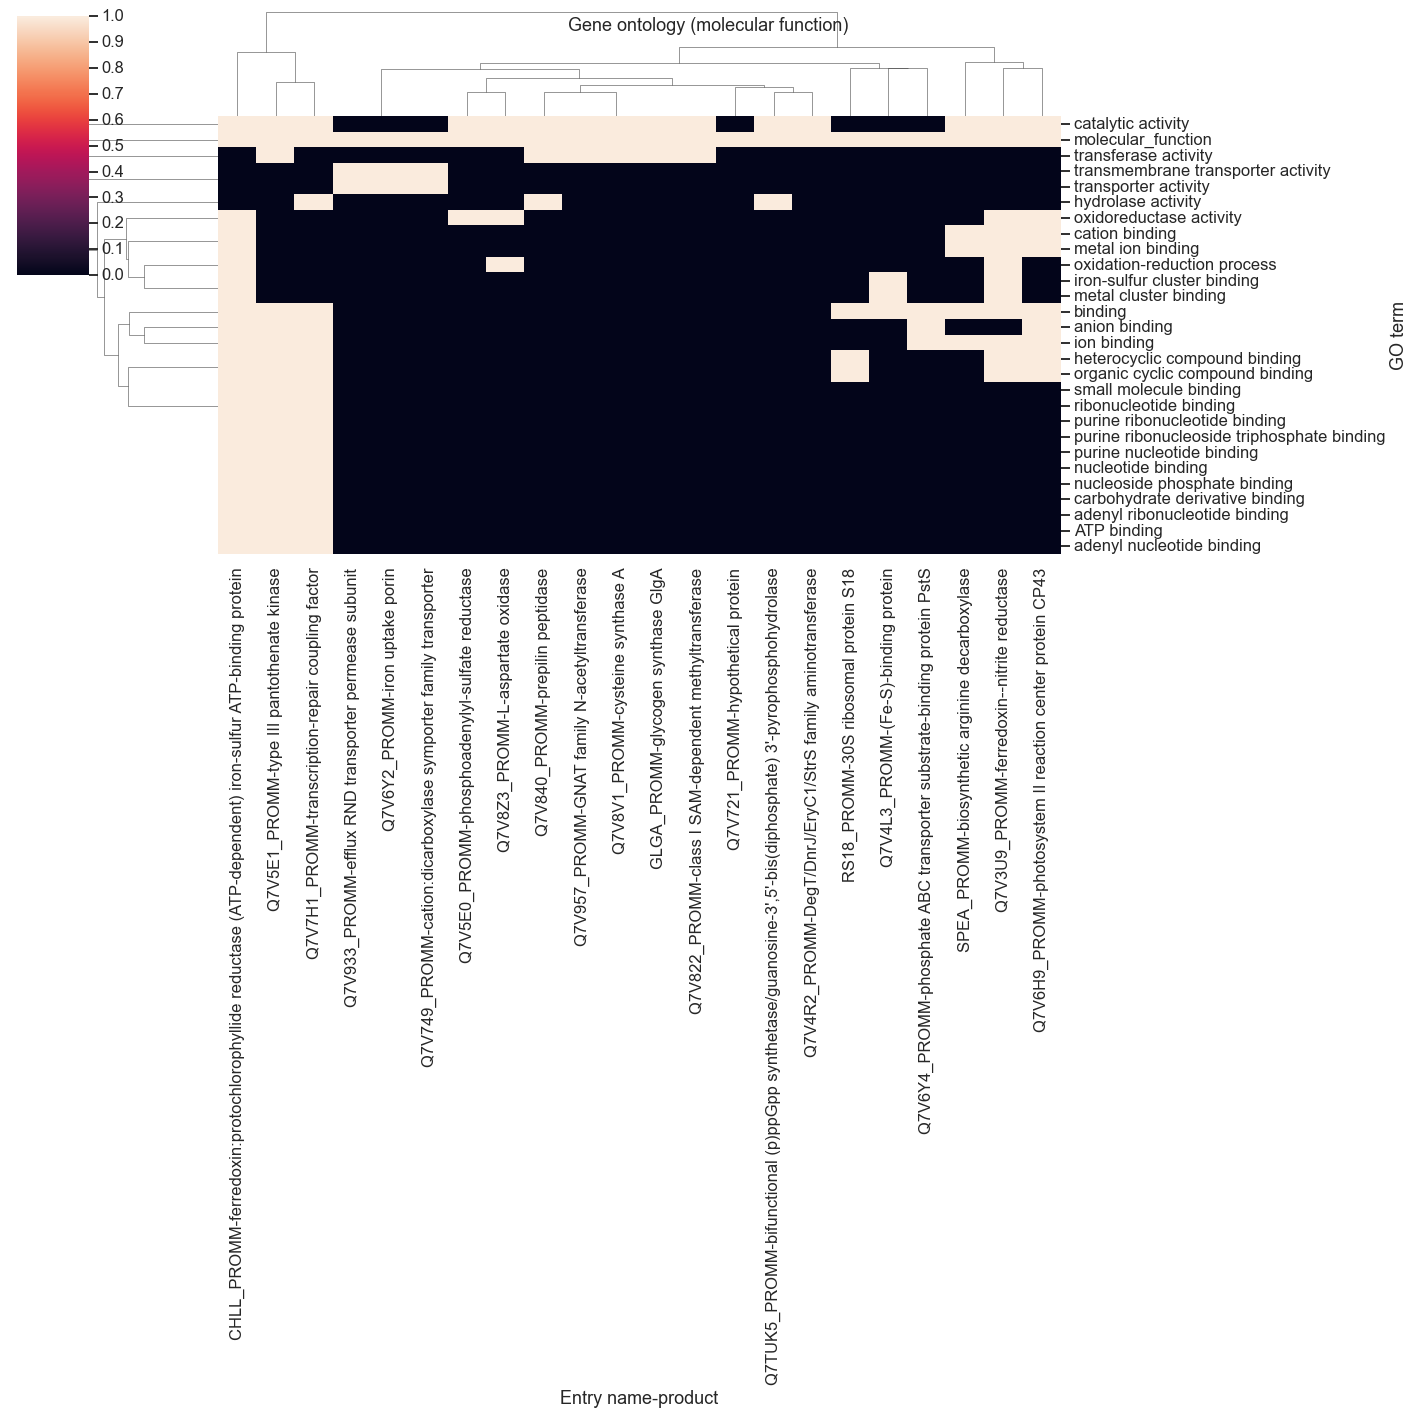

Gene ontology (cellular component) (26, 13)


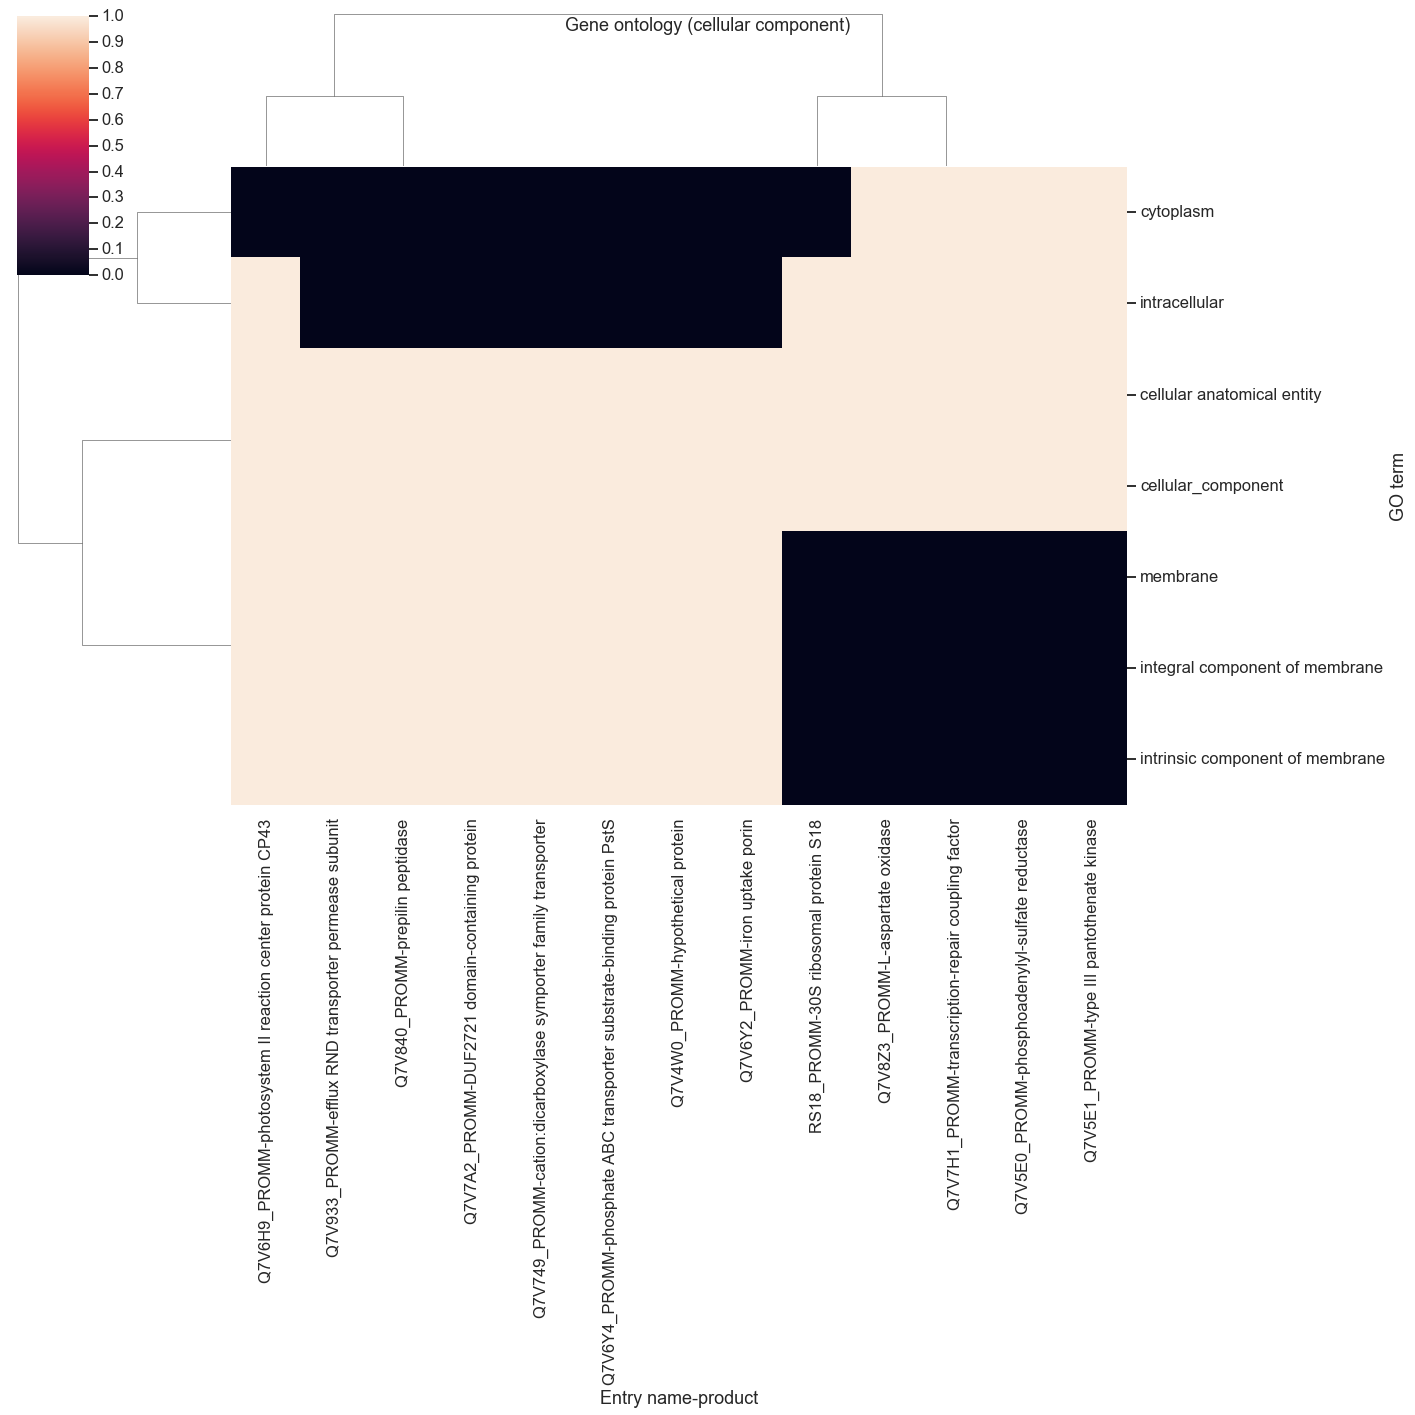

Gene ontology (biological process) (234, 17)


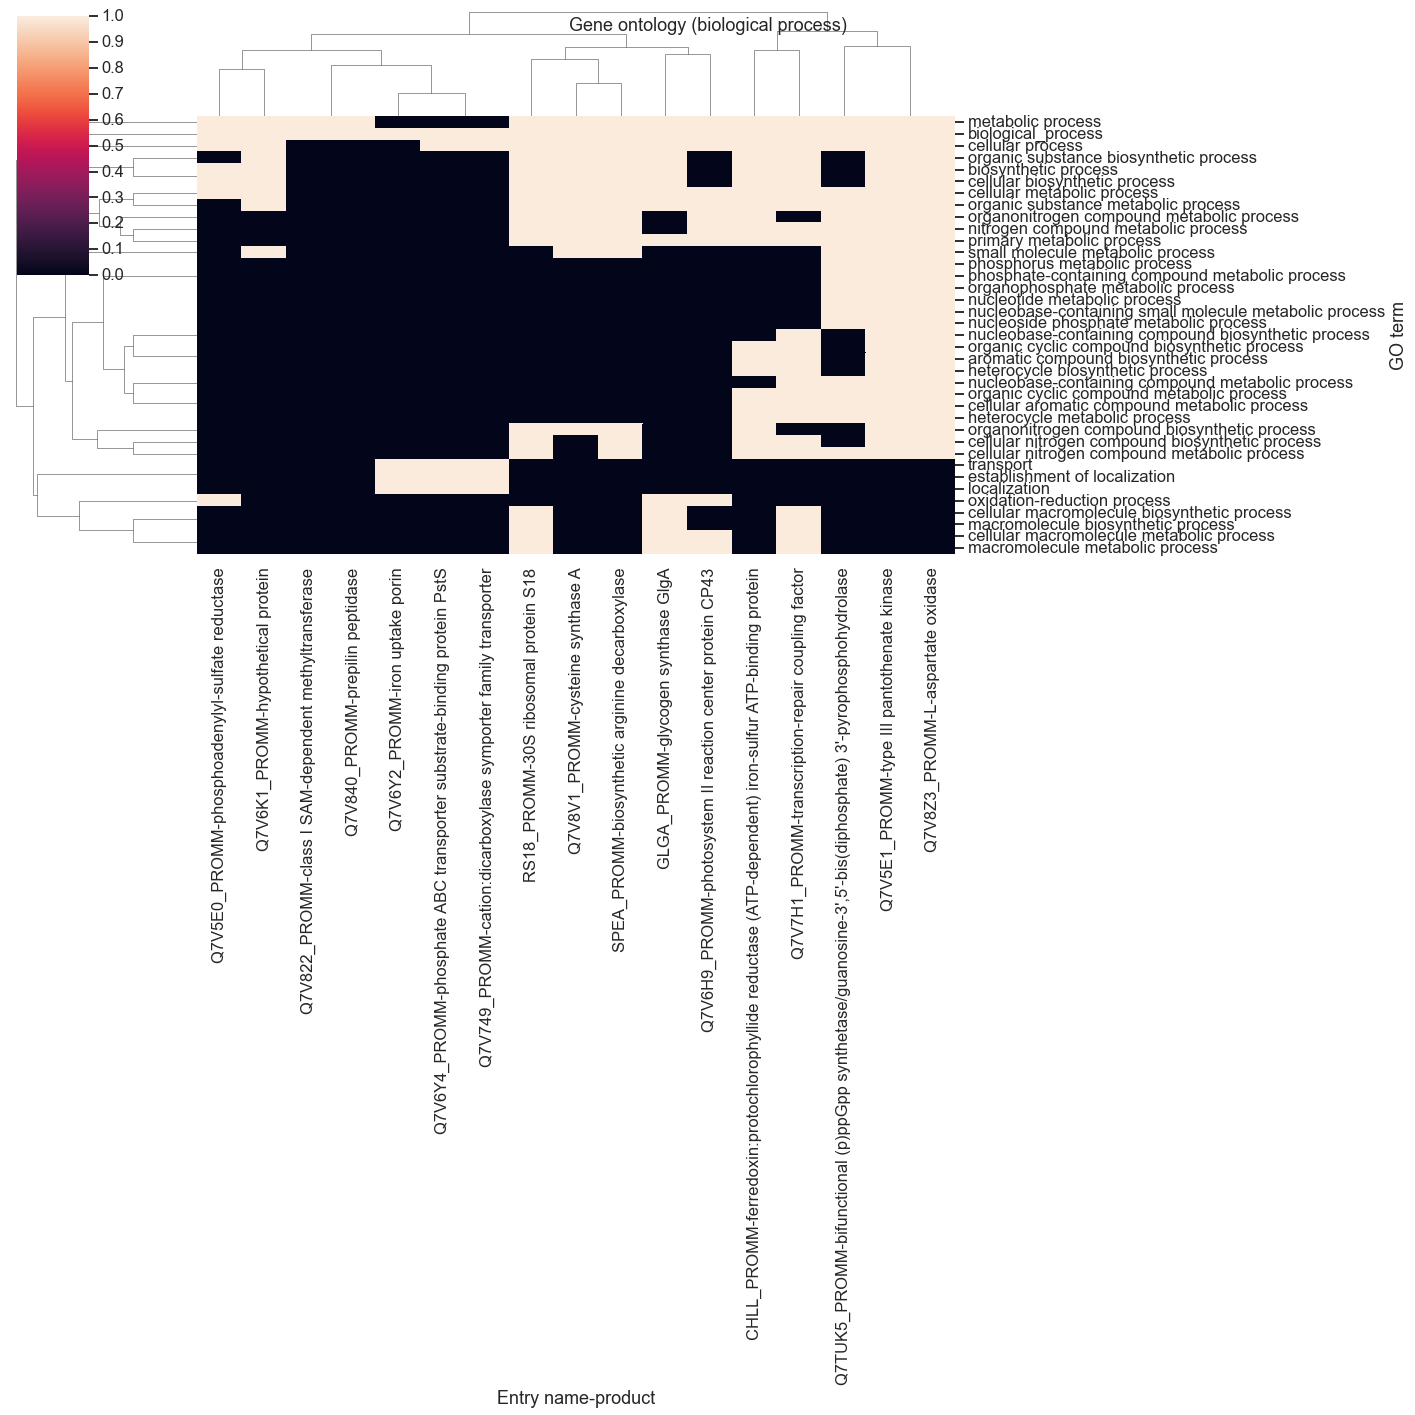

In [165]:
for i in found_goterms1['GO aspect'].dropna().unique():
    pvdf = found_goterms1.loc[found_goterms1['GO aspect'].isin([i])
                    ].pivot_table(index=[#'GO aspect',
                                                      'GO term'], 
                                               columns=['Entry name', 'product'], 
                                               values='GO aspect', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    sns.set_context('talk')
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1)>2], figsize=(20,20),) #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.suptitle(i)
    plt.show()

Gene ontology (molecular function) (118, 22)


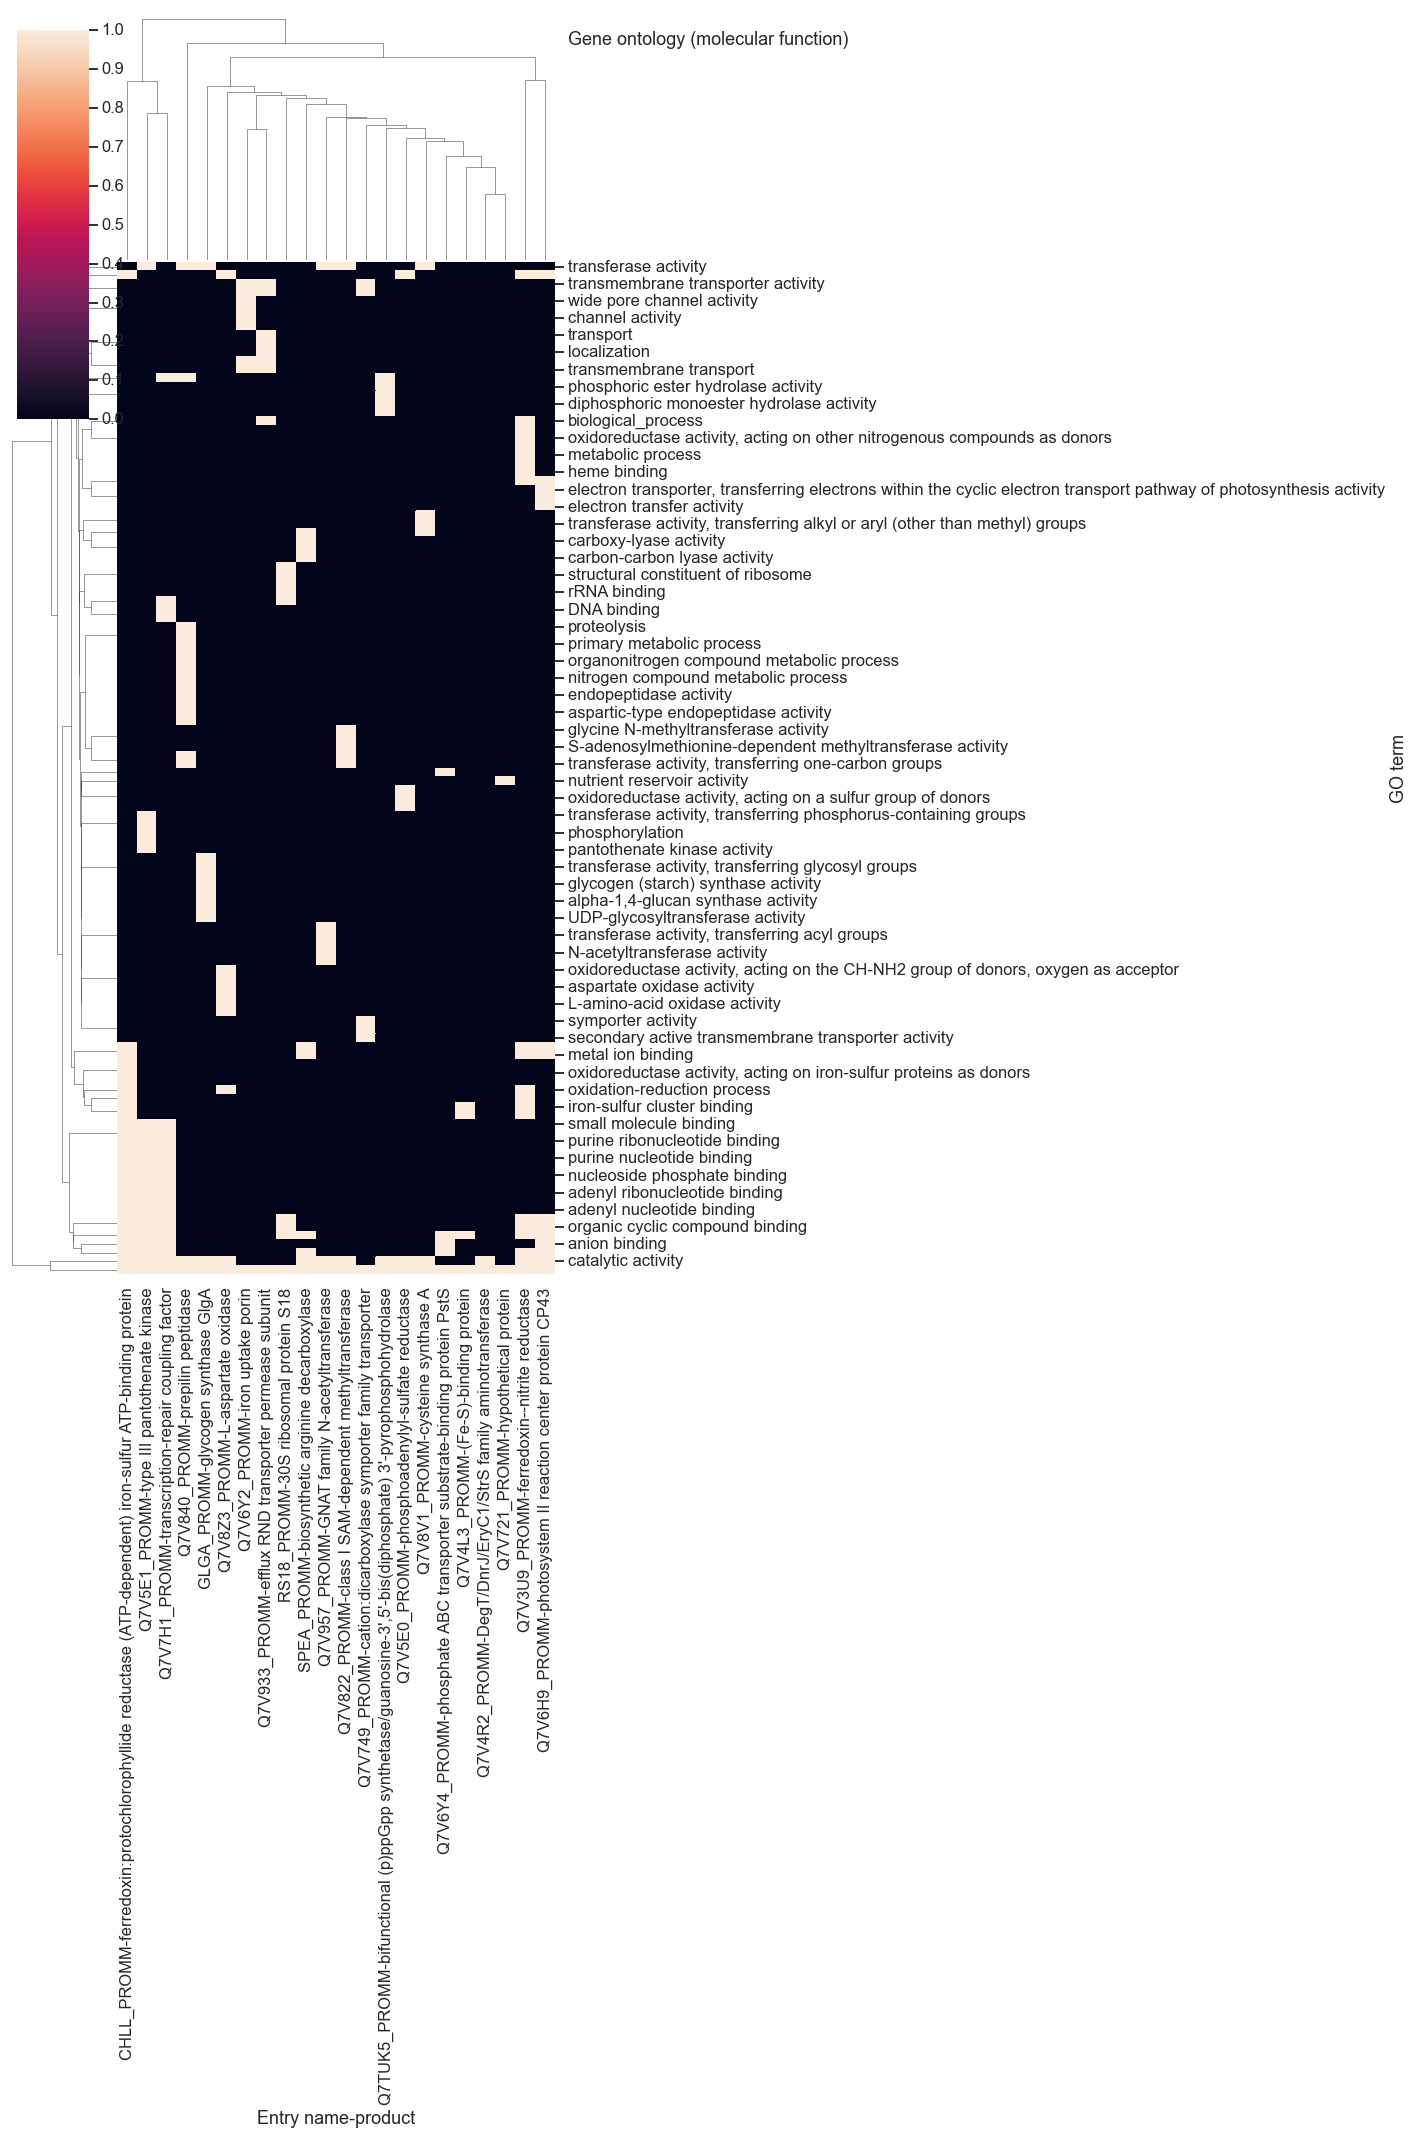

Gene ontology (cellular component) (26, 13)


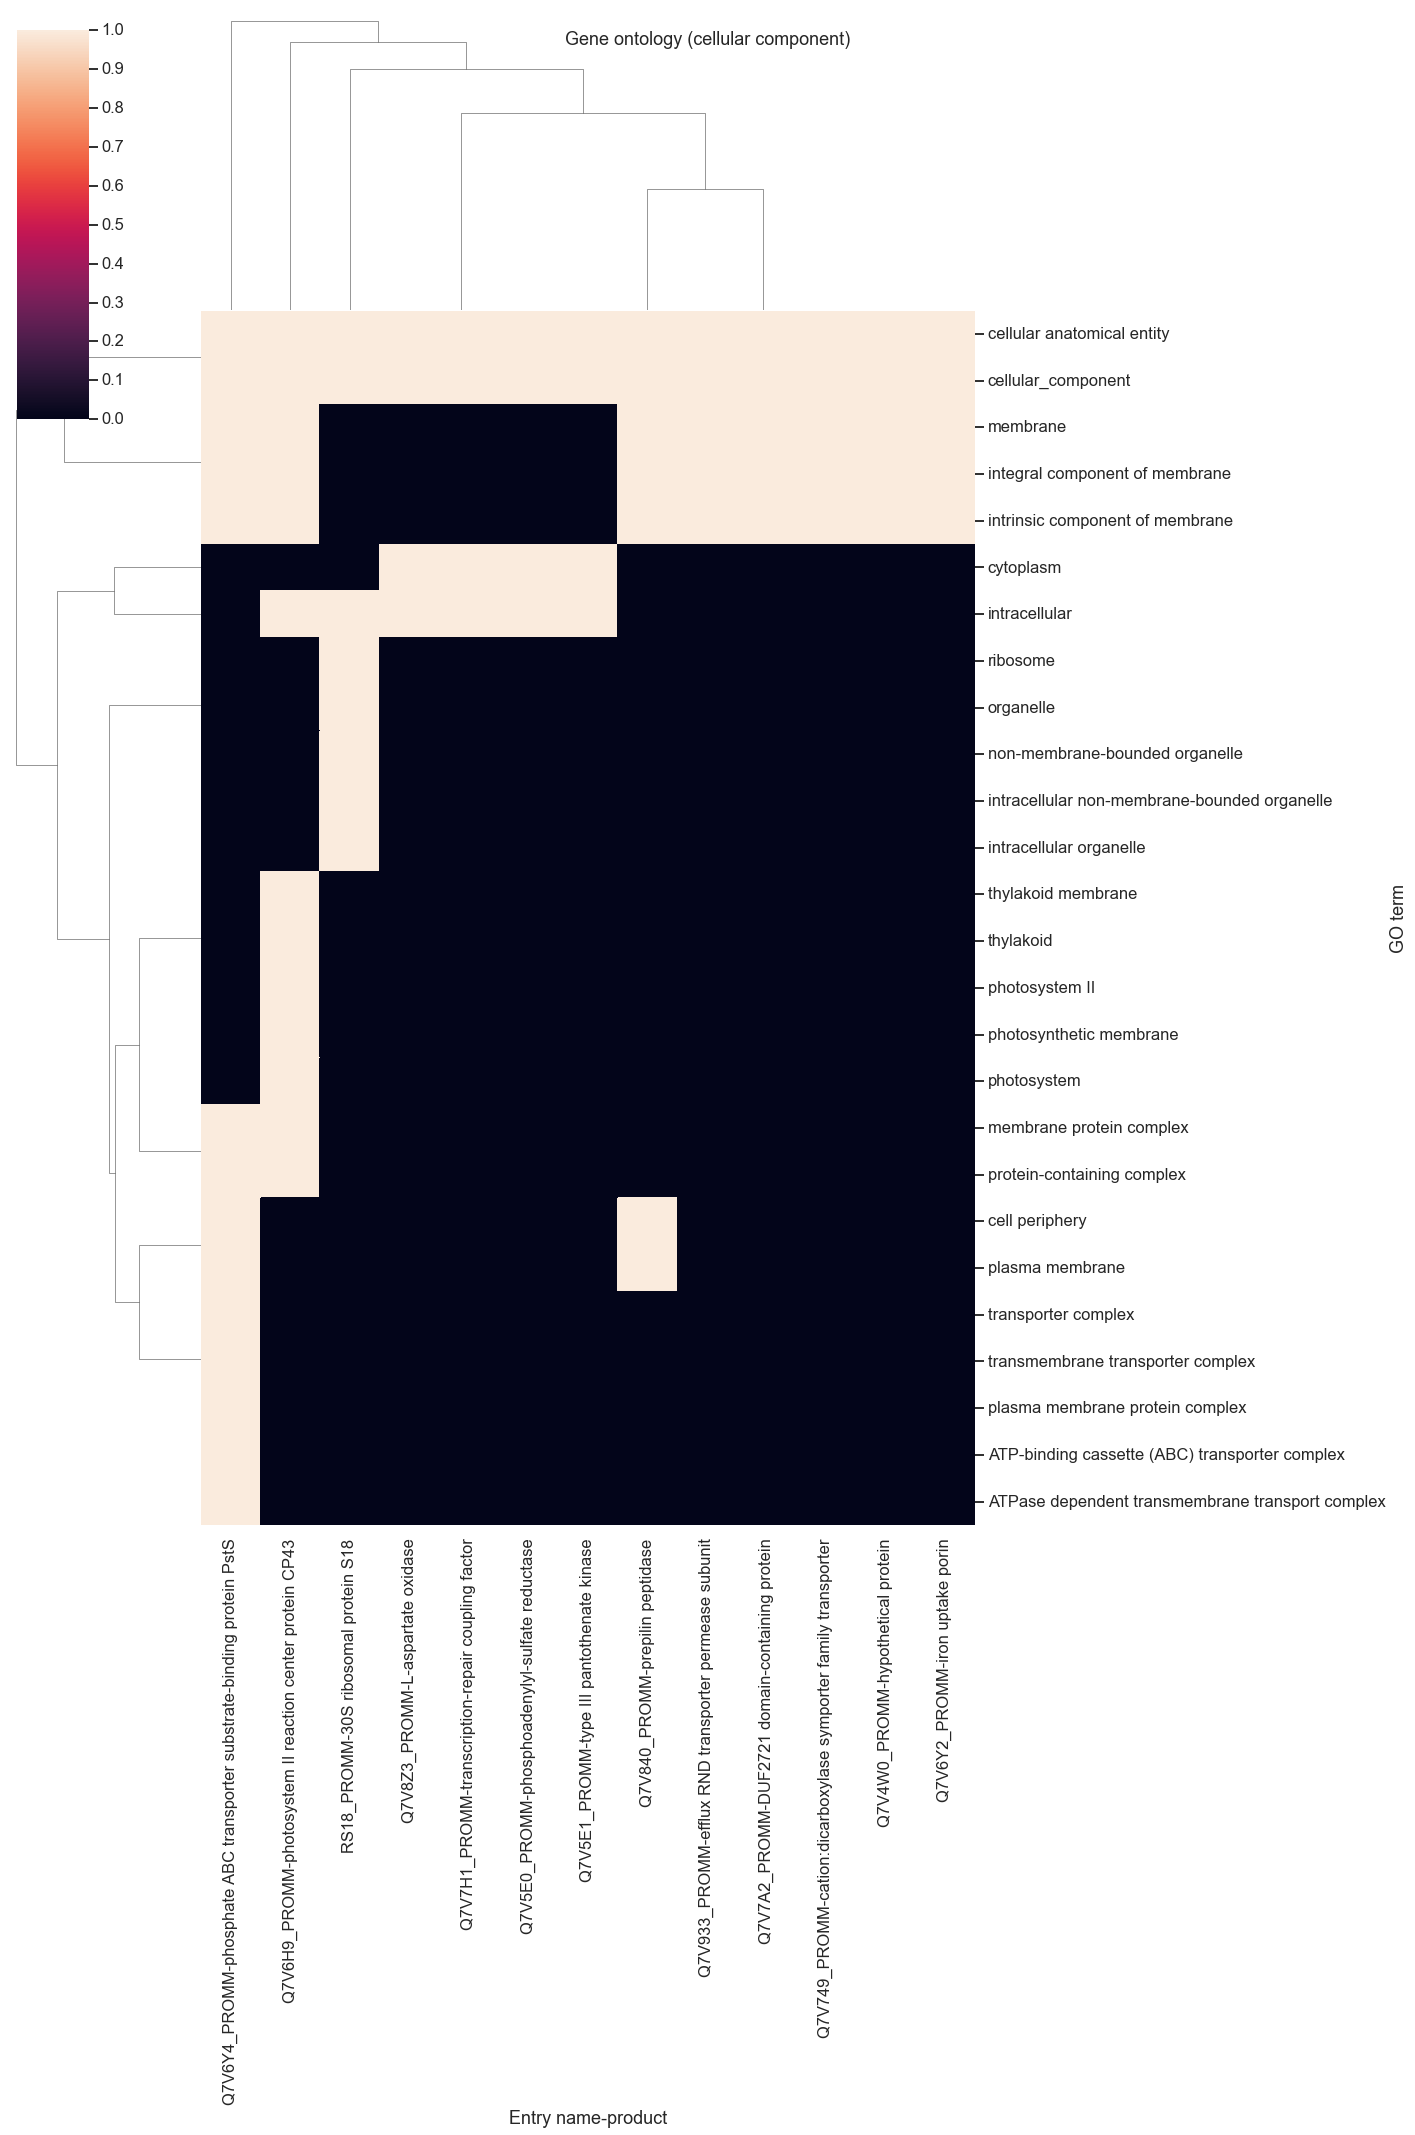

Gene ontology (biological process) (234, 17)


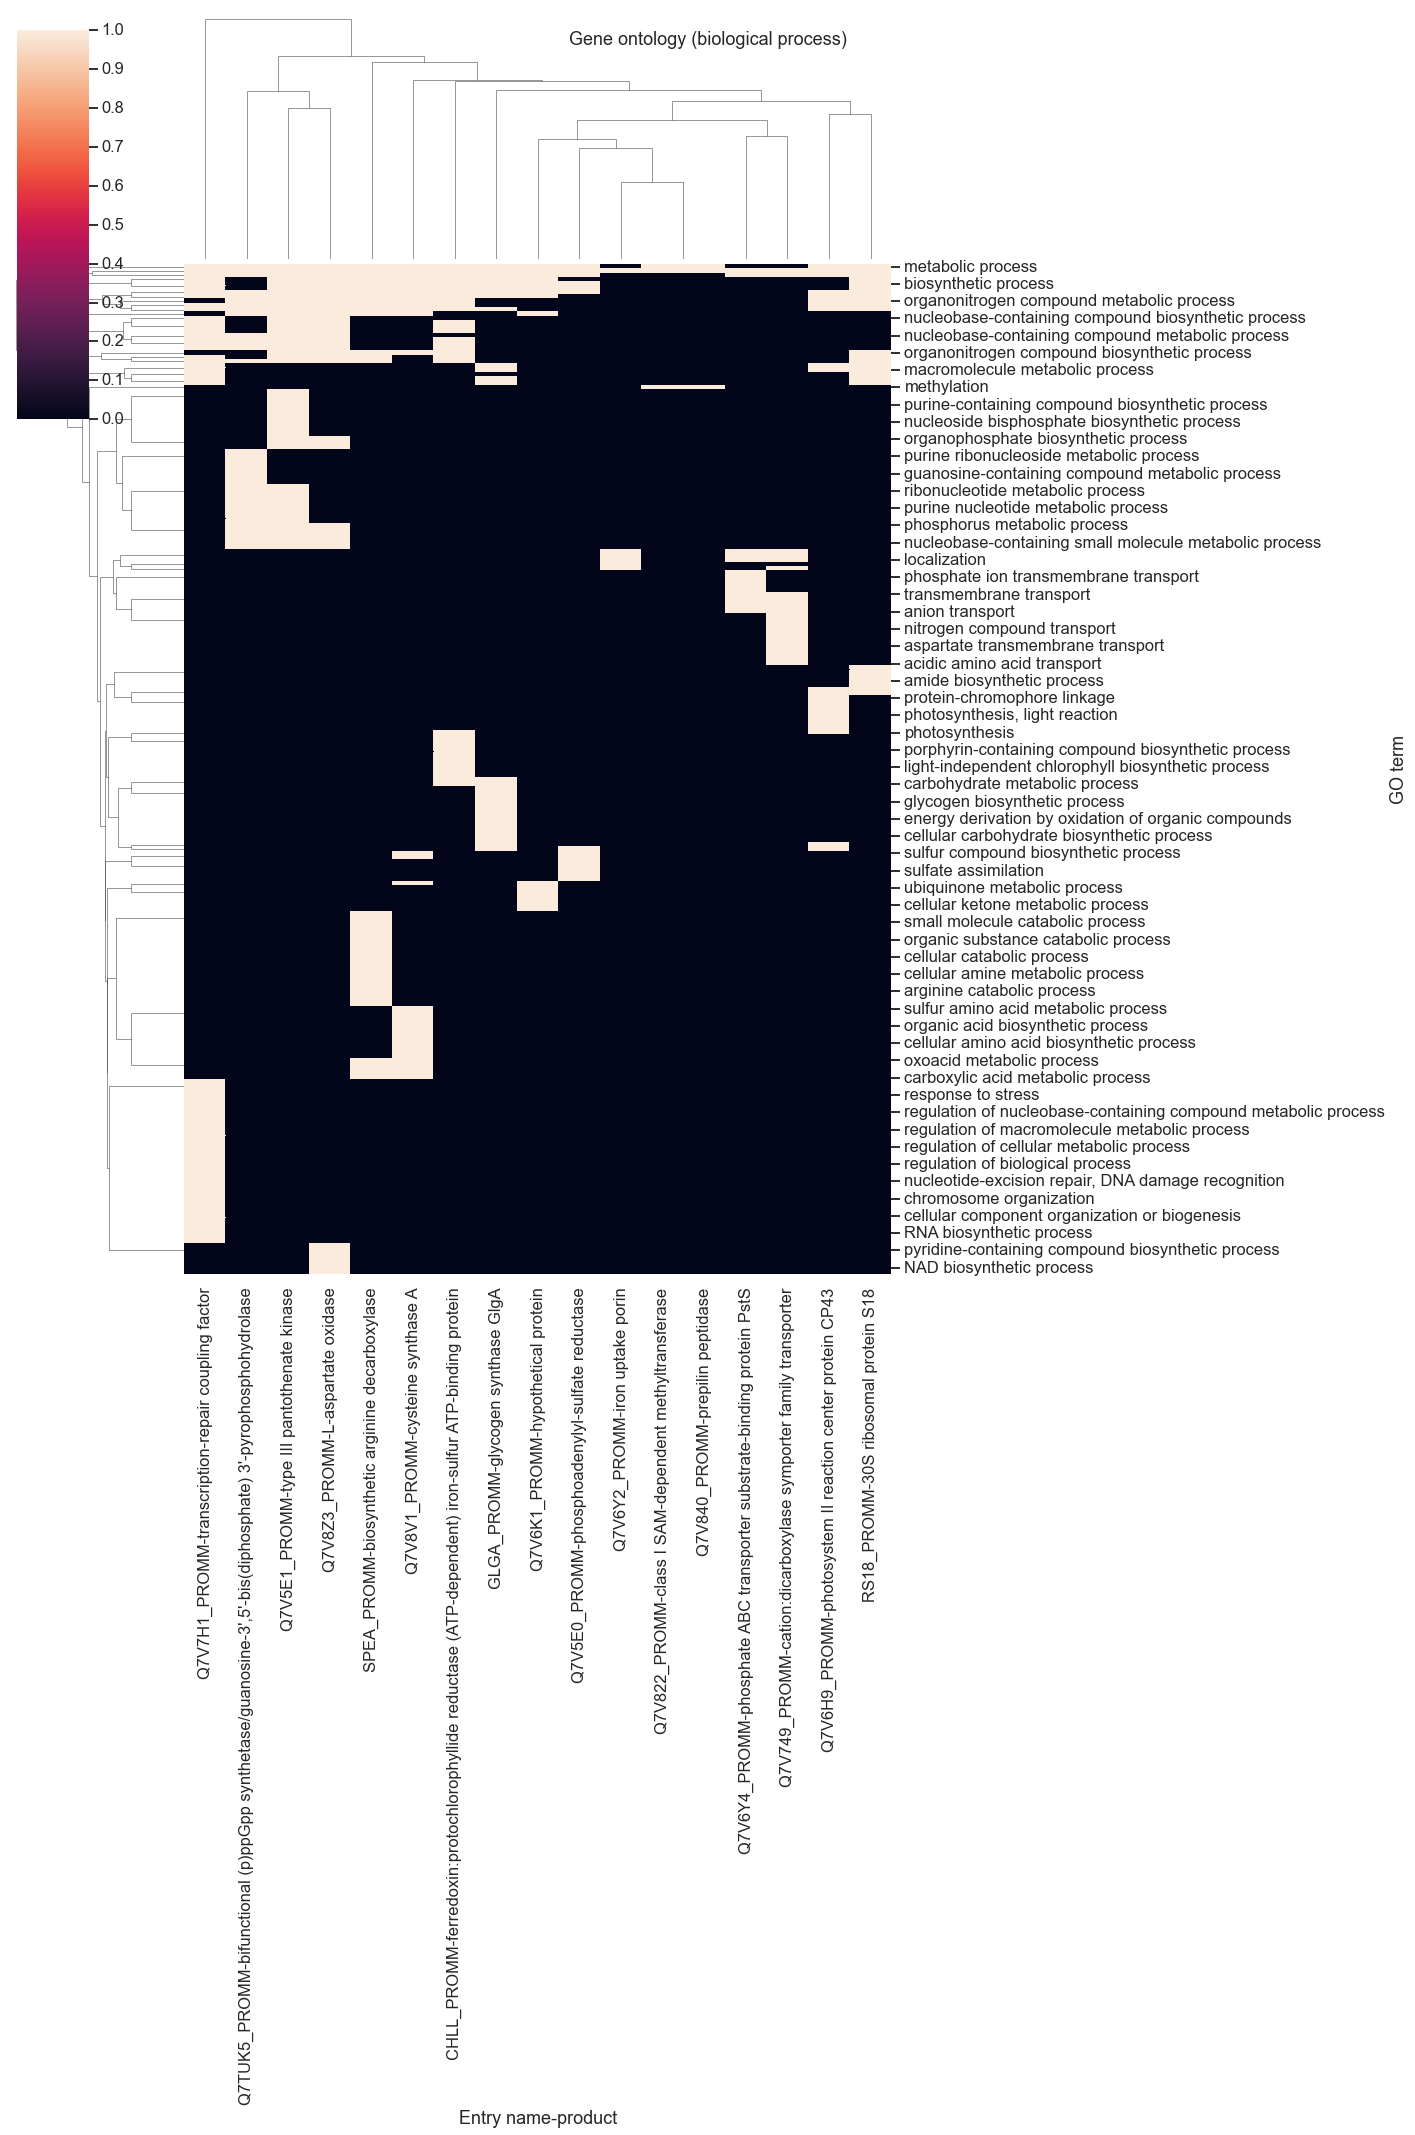

In [167]:
for i in found_goterms1['GO aspect'].dropna().unique():
    pvdf = found_goterms1.loc[found_goterms1['GO aspect'].isin([i])
                    ].pivot_table(index=[#'GO aspect',
                                                      'GO term'], 
                                               columns=['Entry name', 'product'], 
                                               values='GO aspect', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    sns.set_context('talk')
    sns.clustermap(data=pvdf, #.loc[pvdf.sum(axis=1)>2], 
                   figsize=(20,30),) #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.suptitle(i)
    plt.show()

In [172]:
pvdf.to_excel('varcall_goterms.xlsx')

In [177]:
go_df.groupby(['gene_id', 'actual_snp'])['Entry name'].first()

gene_id        actual_snp
AKG35_RS00470  False                  NaN
AKG35_RS00645  True          Q7V933_PROMM
AKG35_RS00885  True          Q7V8Z3_PROMM
AKG35_RS01190  True          Q7V8V1_PROMM
AKG35_RS01355  False         Q7V8S5_PROMM
AKG35_RS01365  False           LEPA_PROMM
AKG35_RS01440  False         Q7V8R1_PROMM
AKG35_RS01605  True                   NaN
AKG35_RS01805  False         Q7V8K6_PROMM
AKG35_RS01845  False         Q7V8J9_PROMM
AKG35_RS02150  True            GLGA_PROMM
AKG35_RS02260  False         Q7V8D1_PROMM
AKG35_RS02690  False         Q7V861_PROMM
AKG35_RS02805  True          Q7V840_PROMM
AKG35_RS02910  True          Q7V822_PROMM
AKG35_RS02915  True                   NaN
AKG35_RS02925  True                   NaN
AKG35_RS03695  True                   NaN
AKG35_RS03800  False         Q7TV00_PROMM
AKG35_RS03835  False                  NaN
AKG35_RS03855  True            RS18_PROMM
AKG35_RS04035  True          Q7V7H1_PROMM
AKG35_RS04060  False         Q7V7G6_PROMM
AKG35_RS

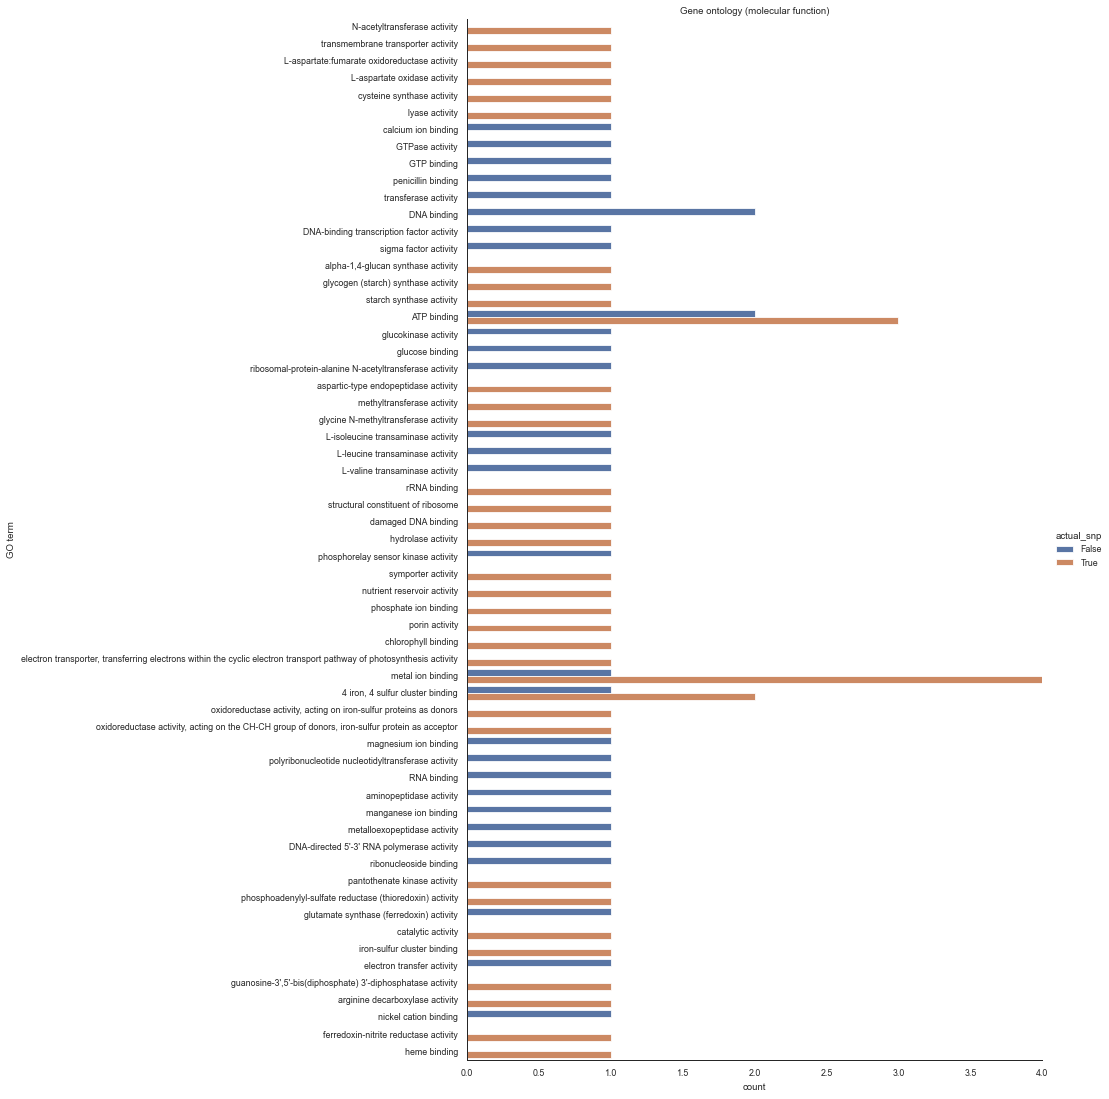

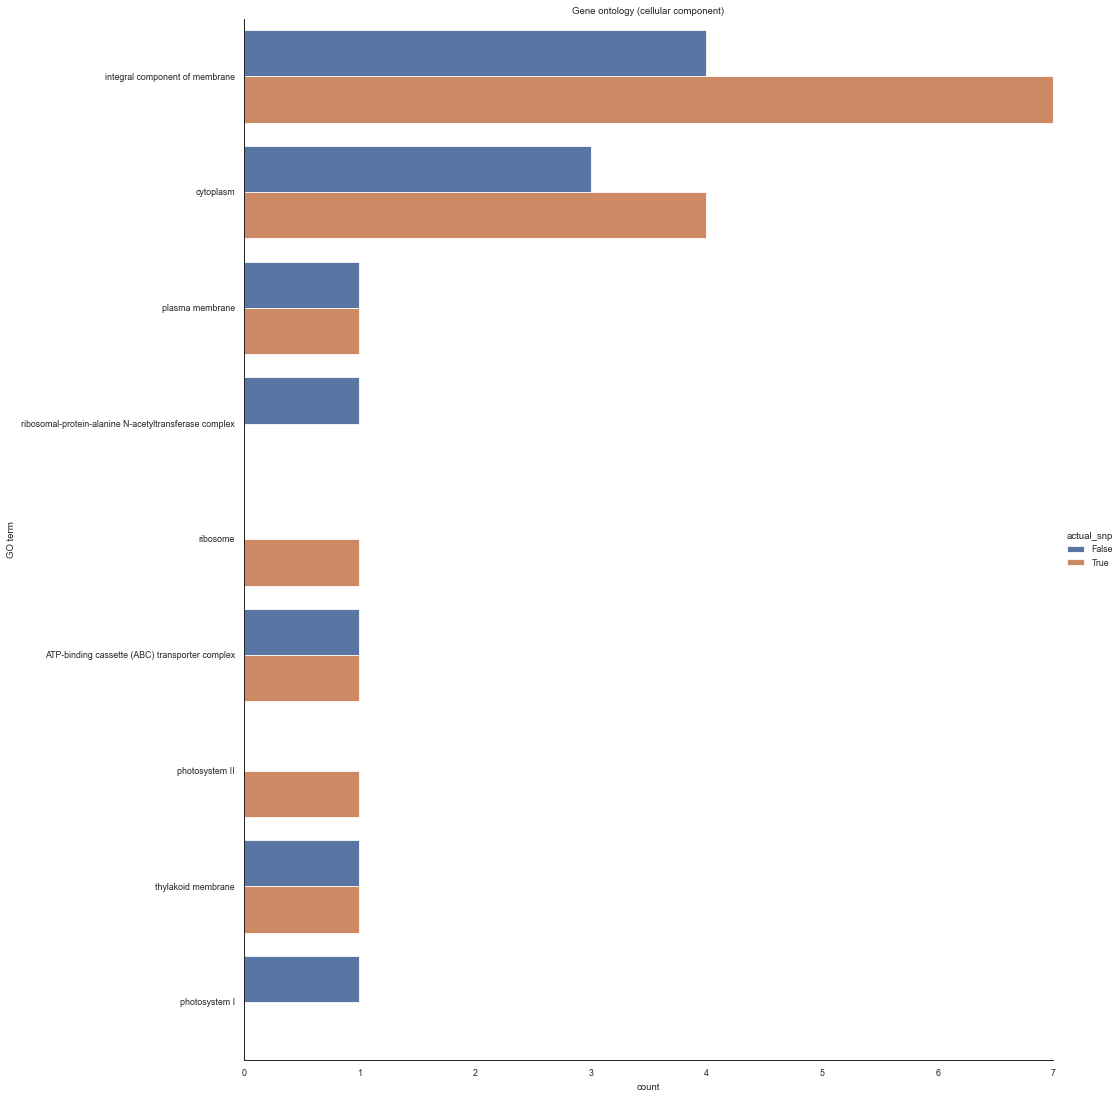

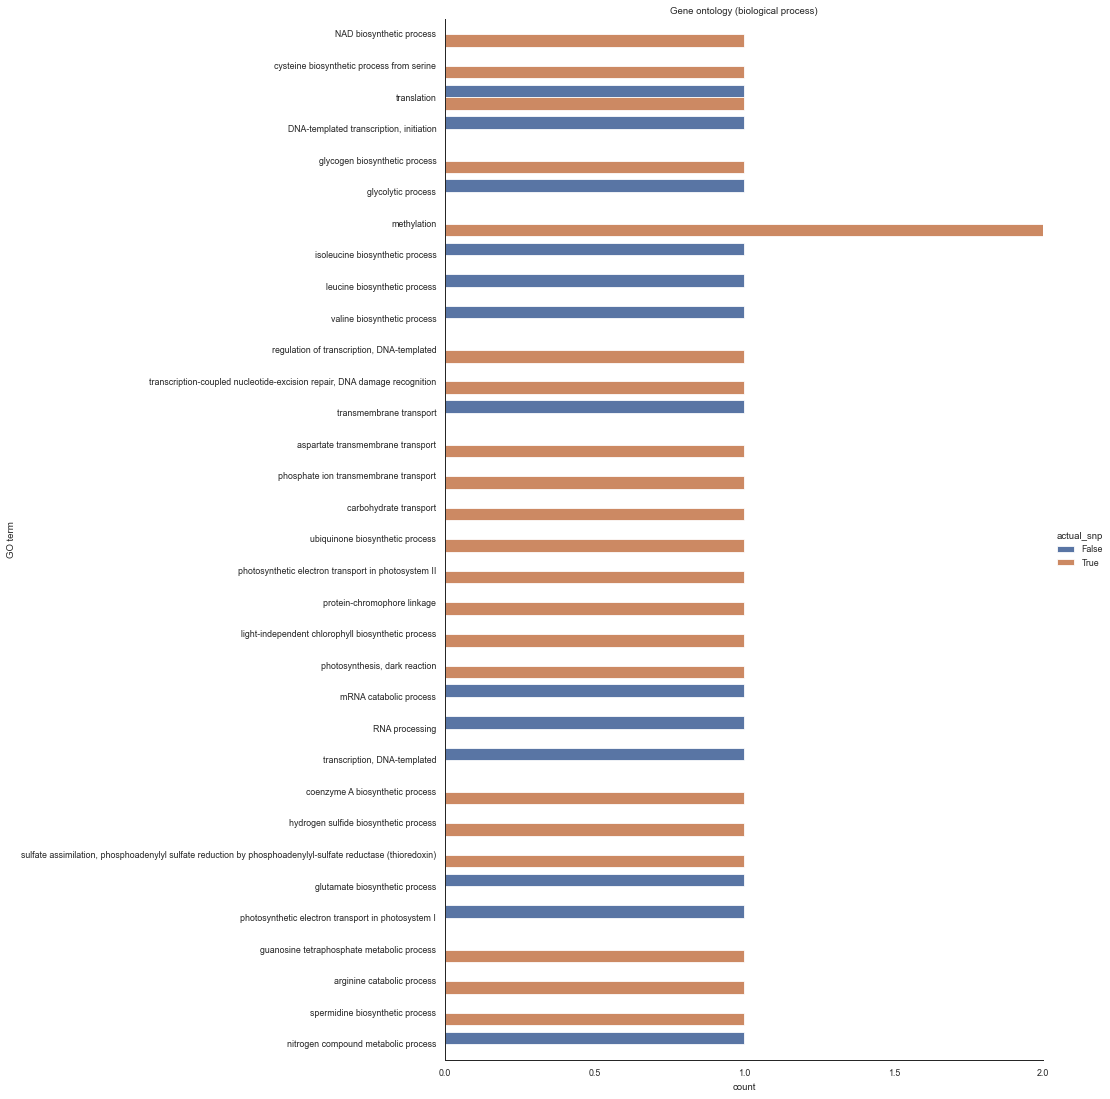

In [124]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term'])
    sns.set_context('paper')
    sns.catplot(data=pvdf, y='GO term', hue='actual_snp', kind='count', height=15)
    plt.title(i)
    plt.show()

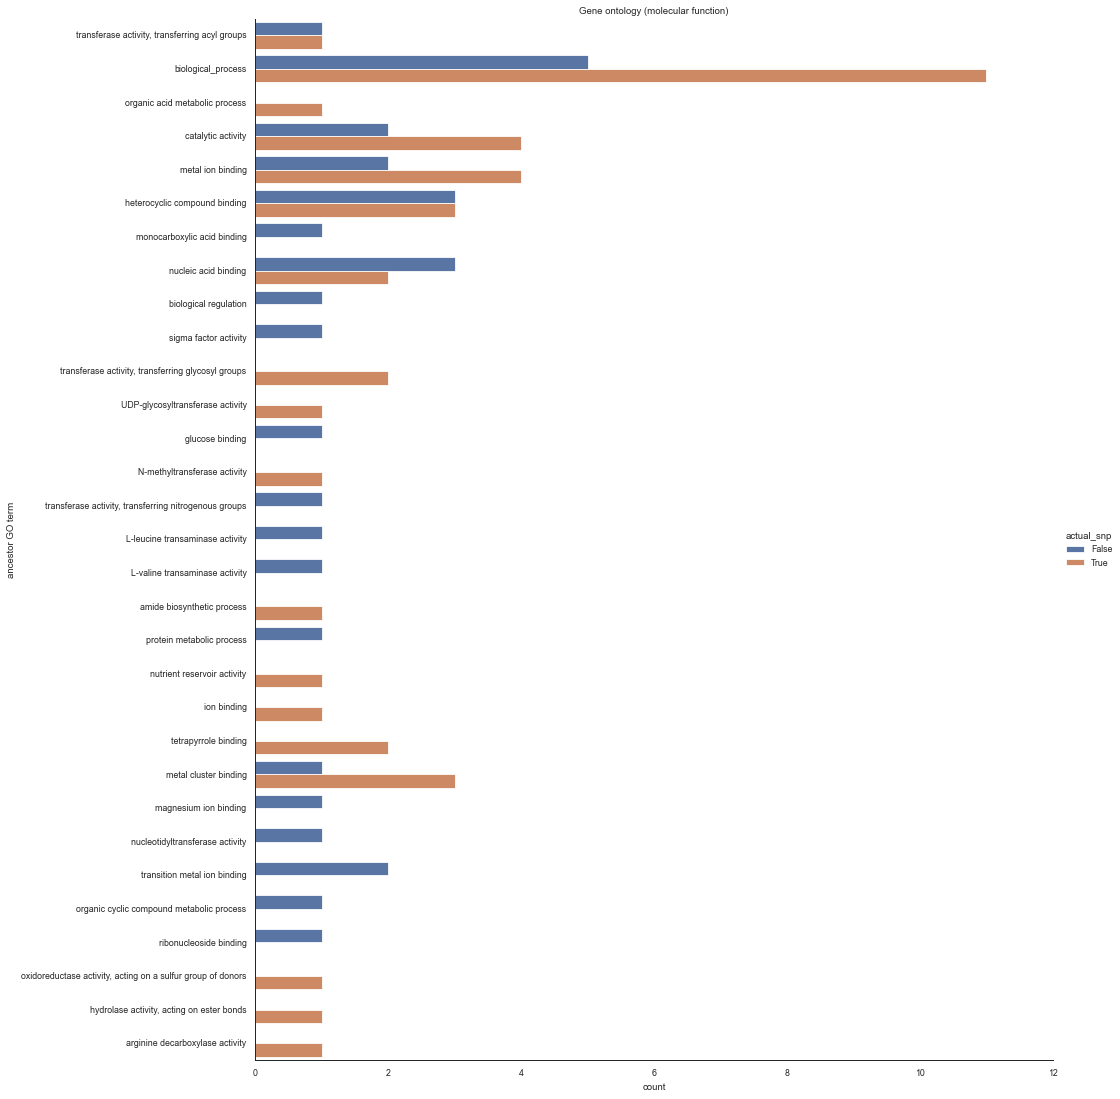

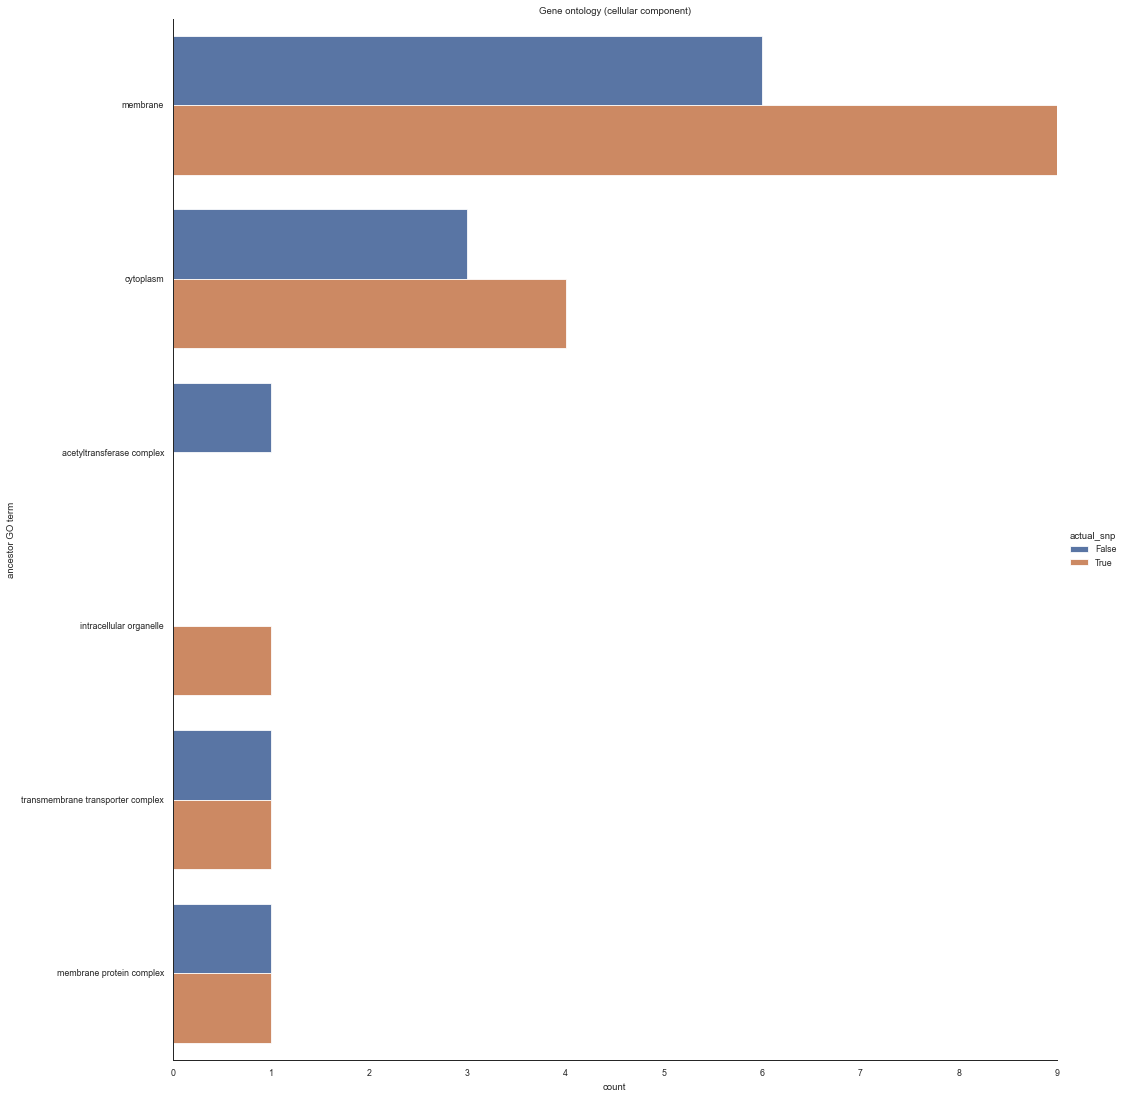

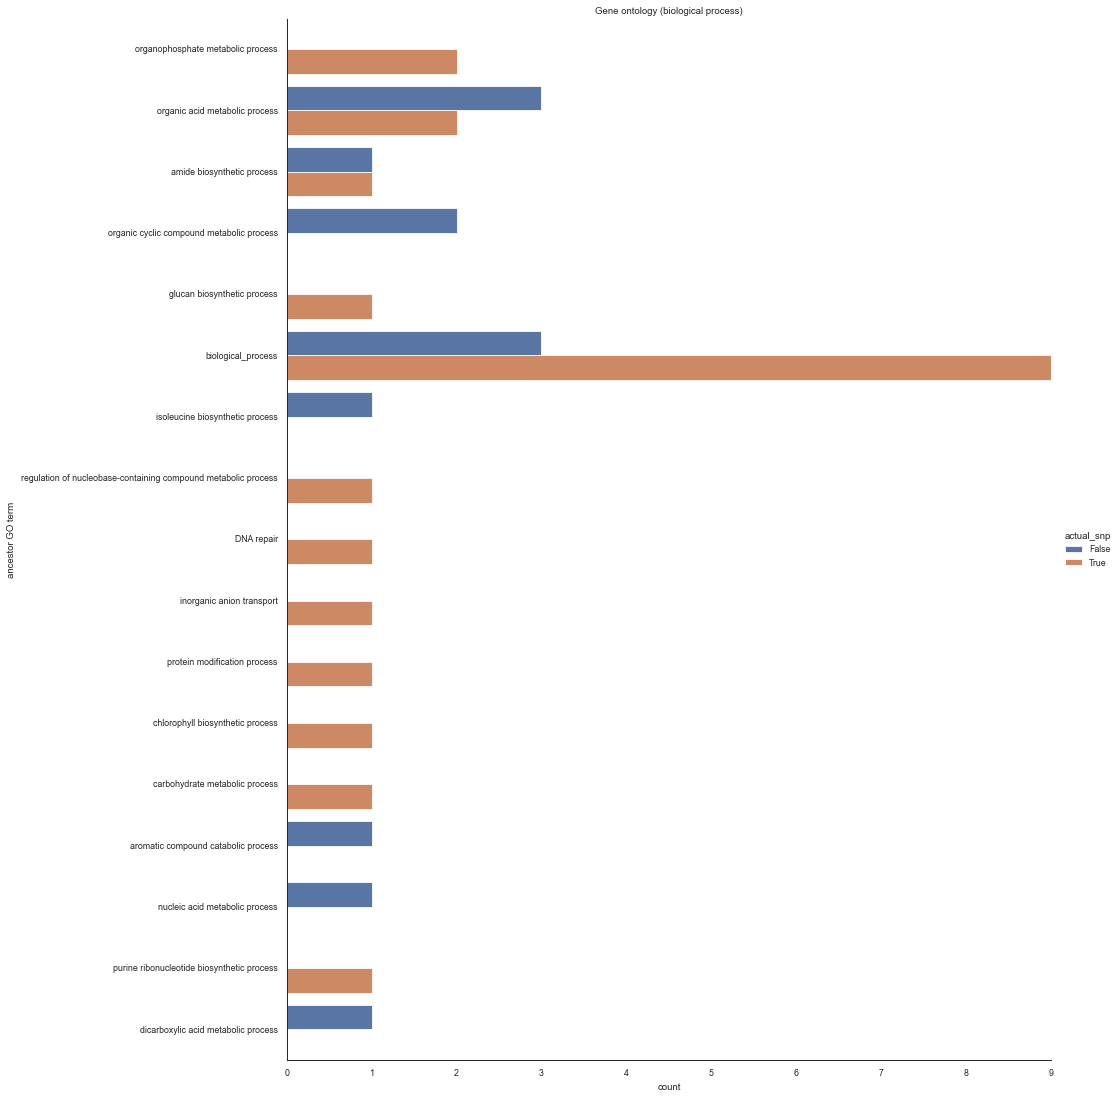

In [125]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term'])
    sns.set_context('paper')
    sns.catplot(data=pvdf, y='ancestor GO term', hue='actual_snp', kind='count', height=15)
    plt.title(i)
    plt.show()

Gene ontology (molecular function) (61, 36)


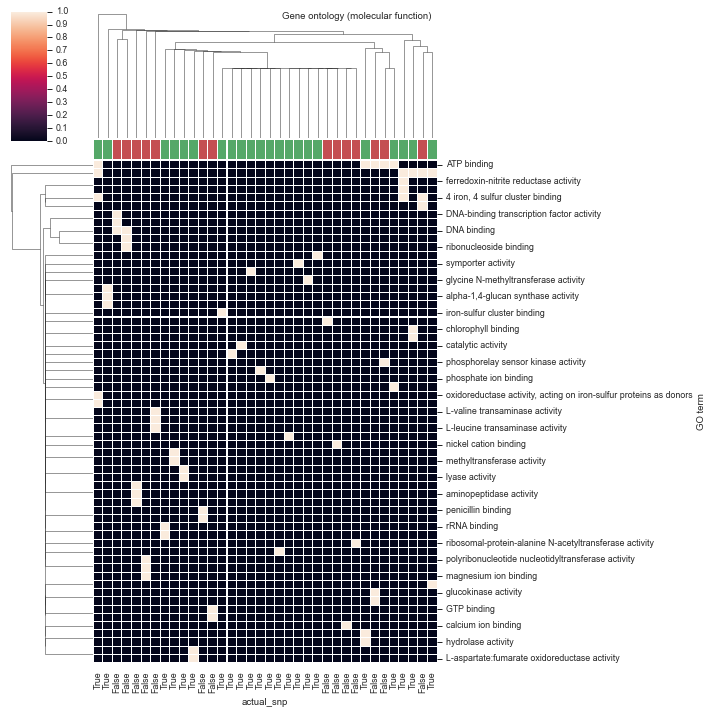

Gene ontology (cellular component) (9, 24)


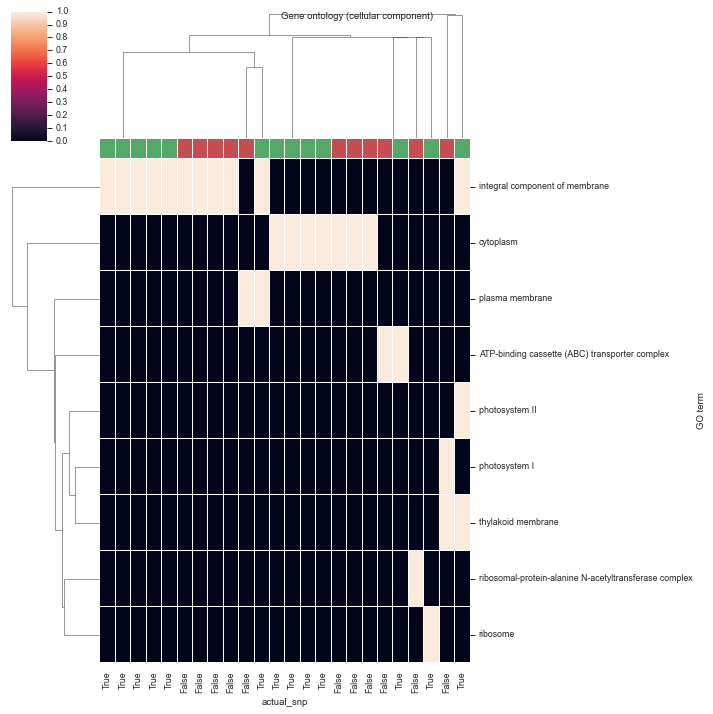

Gene ontology (biological process) (33, 27)


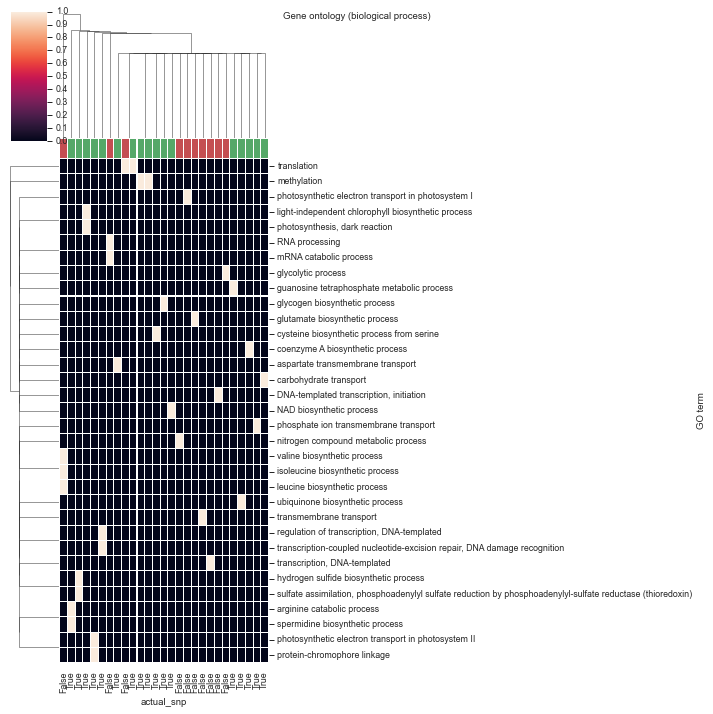

In [126]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'GO term'], 
                                               columns=['actual_snp','gene_id'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    lut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    col_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1) >0], 
                   linewidths=0.03, 
                  col_colors=col_colors
                  )
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.suptitle(i)
    plt.show()

Gene ontology (molecular function) (61, 36)


<Figure size 1080x576 with 0 Axes>

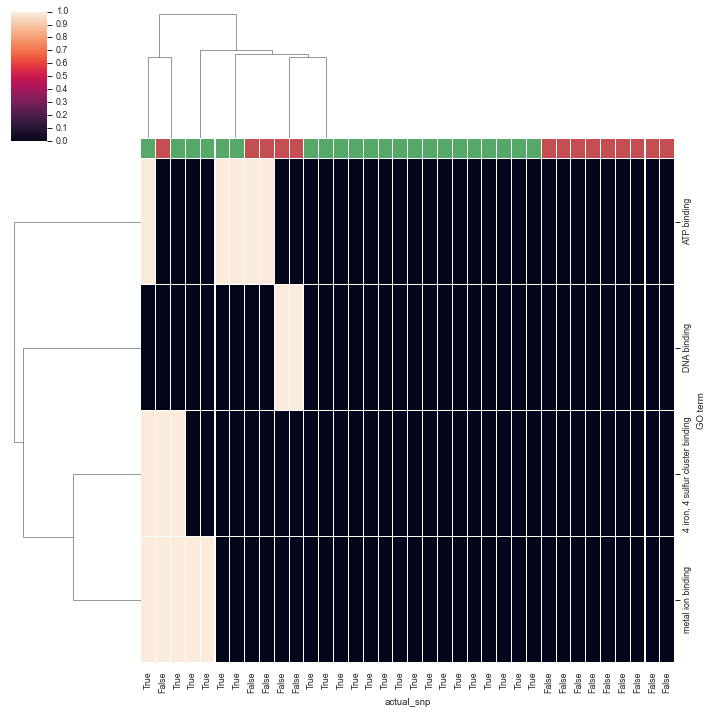

Gene ontology (cellular component) (9, 24)


<Figure size 1080x576 with 0 Axes>

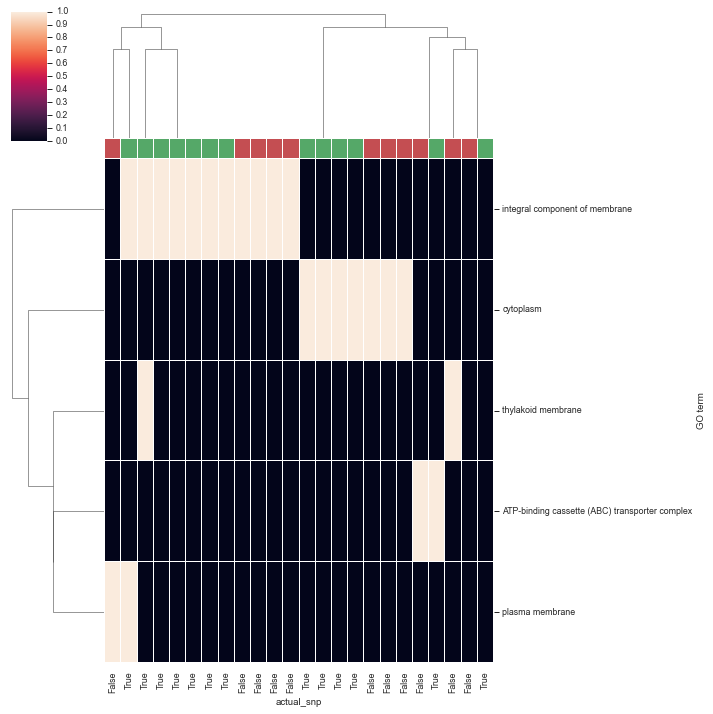

Gene ontology (biological process) (33, 27)


<Figure size 1080x576 with 0 Axes>

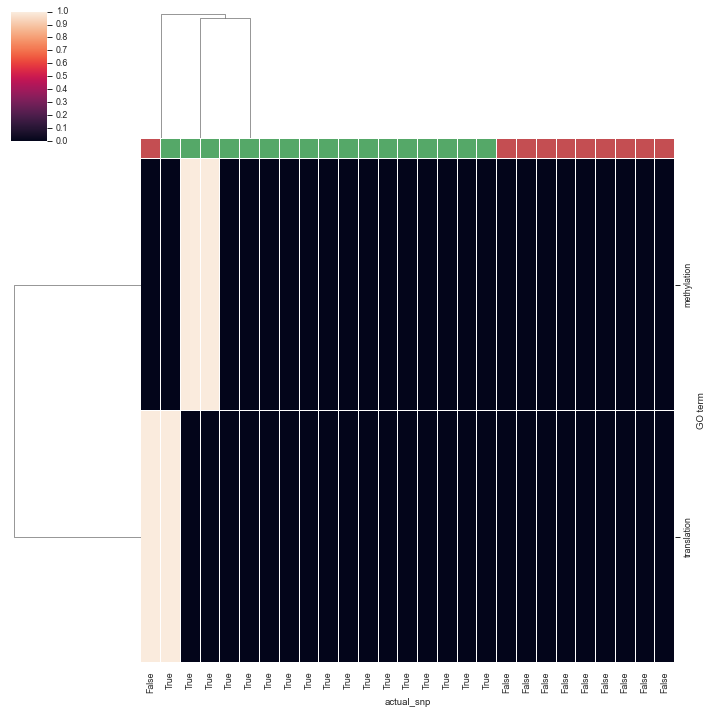

In [127]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'GO term'], 
                                               columns=['actual_snp','gene_id'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    plt.suptitle(i)
    lut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    col_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1) >1], 
                   linewidths=0.03, 
                  col_colors=col_colors
                  )
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.show()

Gene ontology (molecular function) (278, 36)


<Figure size 1080x576 with 0 Axes>

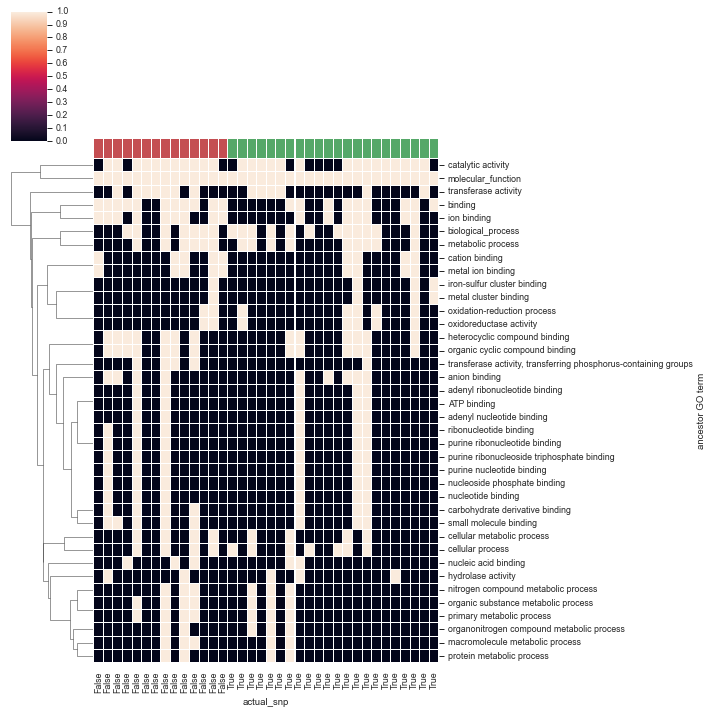

Gene ontology (cellular component) (32, 24)


<Figure size 1080x576 with 0 Axes>

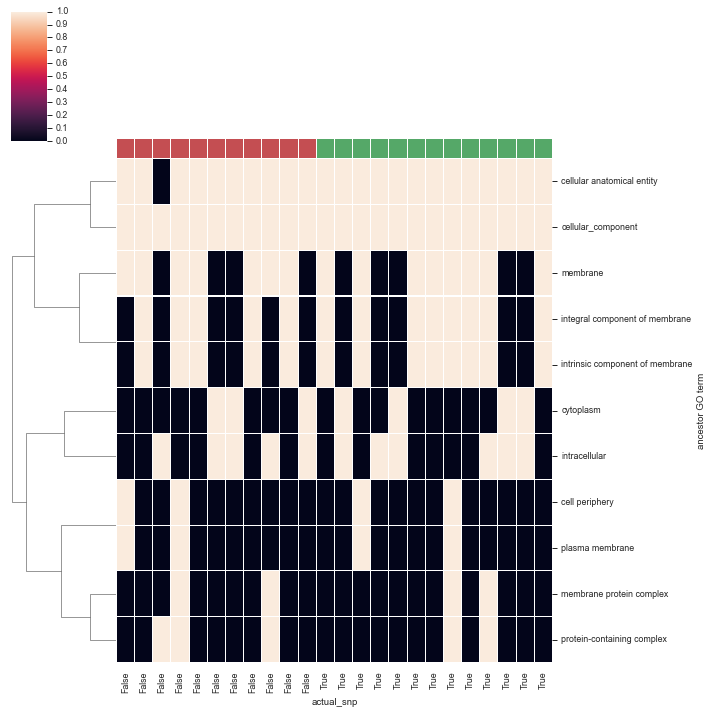

Gene ontology (biological process) (278, 27)


<Figure size 1080x576 with 0 Axes>

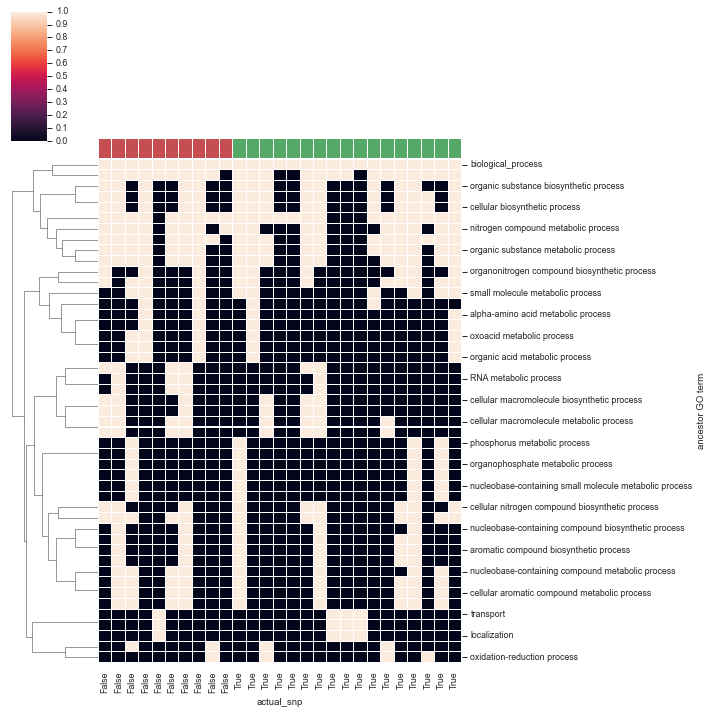

In [128]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','ancestor GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'ancestor GO term'], 
                                               columns=['actual_snp','gene_id'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    plt.suptitle(i)
    lut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    col_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1) >3], 
                   linewidths=0.03, 
                  col_colors=col_colors
                , col_cluster=False
                  )
    
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.show()

Gene ontology (molecular function) (165, 22)


<Figure size 1080x576 with 0 Axes>

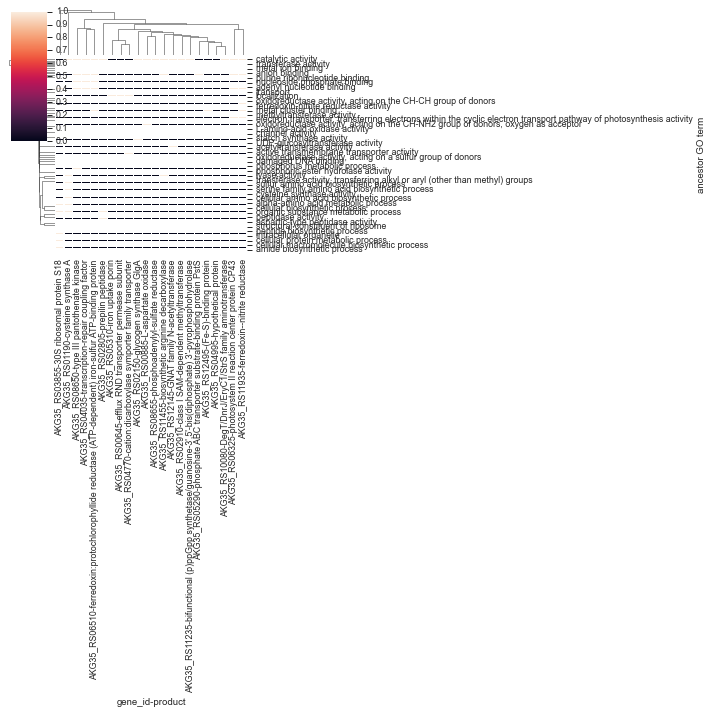

Gene ontology (cellular component) (26, 13)


<Figure size 1080x576 with 0 Axes>

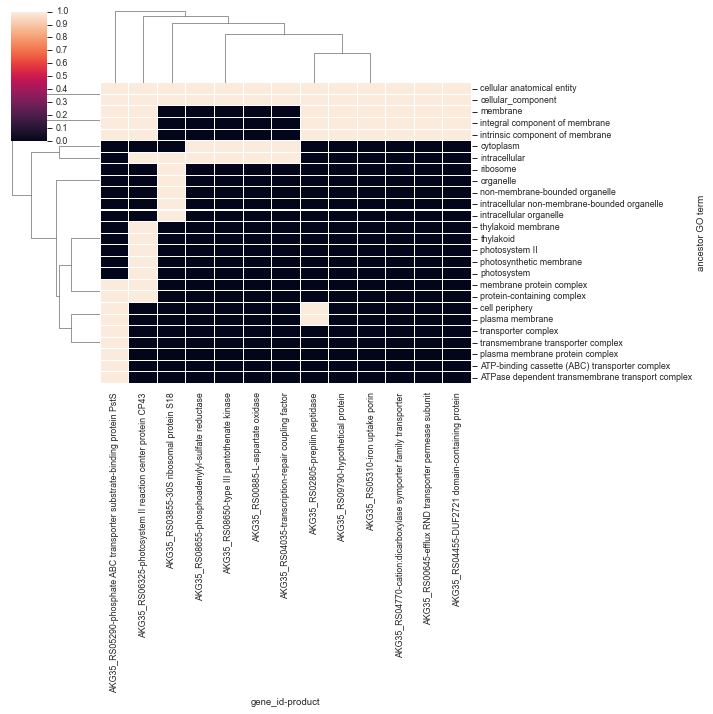

Gene ontology (biological process) (234, 17)


<Figure size 1080x576 with 0 Axes>

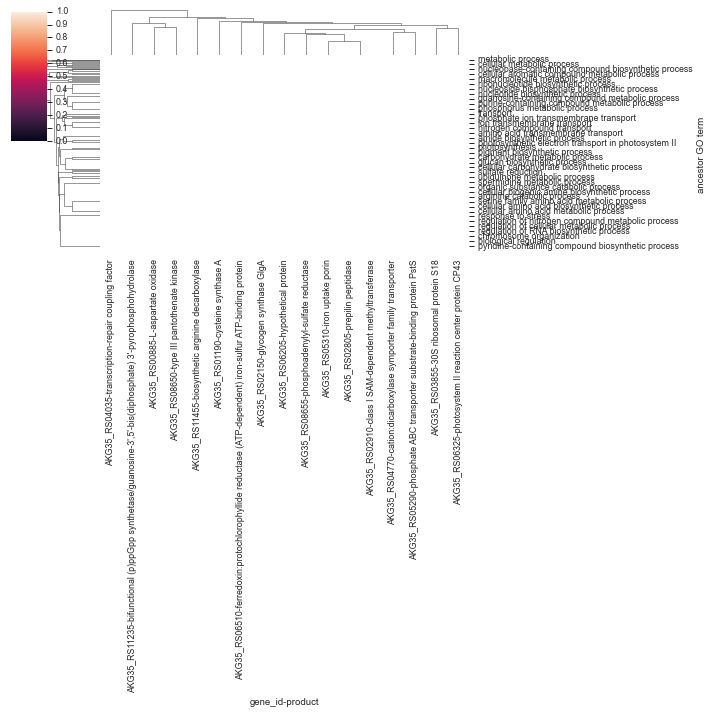

In [129]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i]) & go_df['actual_snp']
                    ].drop_duplicates(['gene_id', 'ancestor GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'ancestor GO term'], 
                                               columns=[#'actual_snp',
                                                        'gene_id', 'product'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    #pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    plt.suptitle(i)
    #ut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    #ol_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf, #.loc[pvdf.sum(axis=1) >3], 
                   linewidths=0.03, 
                   #col_colors=col_colors
                #, col_cluster=False
                  )
    
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.show()

In [131]:
pvdf.sum(axis=1) >3

ancestor GO term
C4-dicarboxylate transport         False
DNA metabolic process              False
DNA repair                         False
L-serine metabolic process         False
NAD biosynthetic process           False
                                   ...  
translation                        False
transmembrane transport            False
transport                          False
ubiquinone biosynthetic process    False
ubiquinone metabolic process       False
Length: 234, dtype: bool

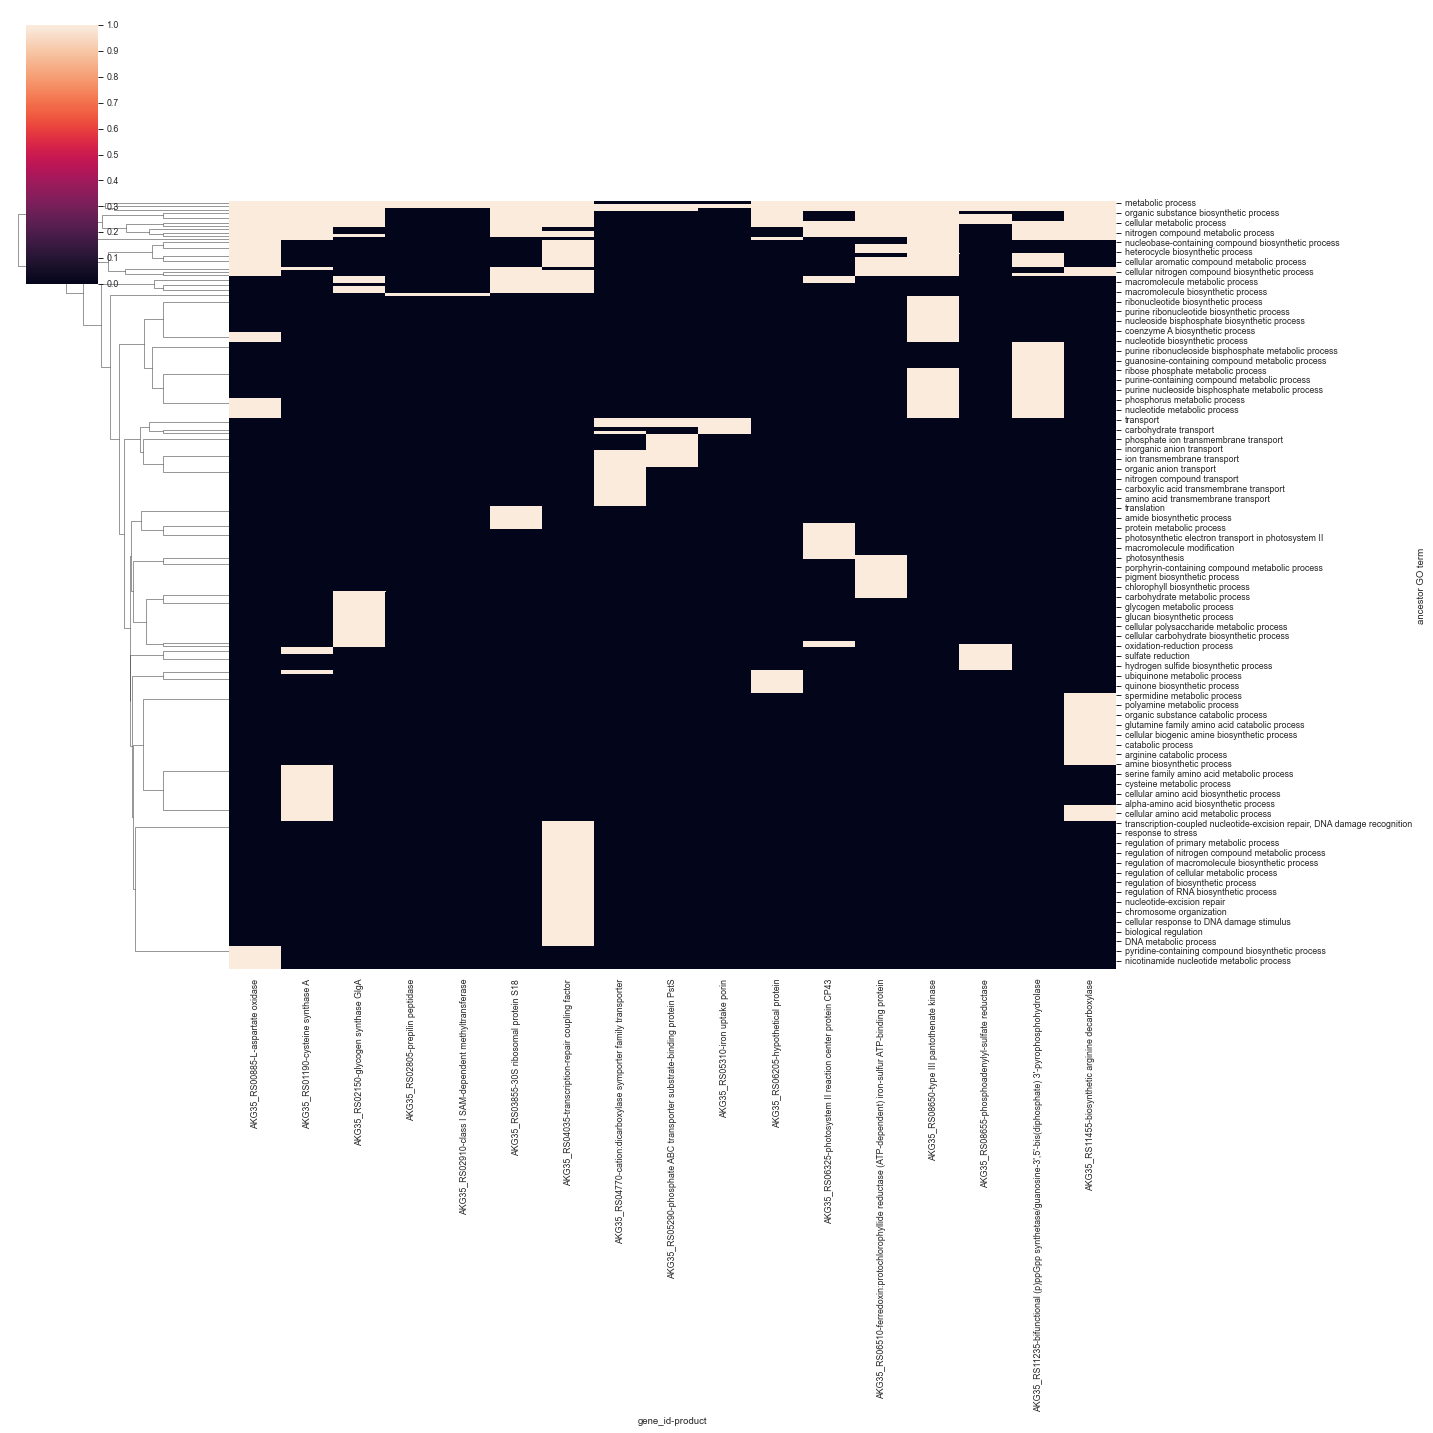

In [132]:
sns.set_context('paper')
sns.clustermap(data=pvdf, figsize=(20,20), col_cluster=False)

In [133]:
go_df.columns

Index([      'protein_id',          'gene_id',          'product',
                        0,                100,                100,
                      440,                440,       'actual_snp',
                   'From',               'To',            'Entry',
             'Entry name',    'Protein names',       'Gene names',
               'Organism',           'Length',        'GO aspect',
                'GO term',             'GOid',       'ancestorID',
       'ancestor GO term'],
      dtype='object')

In [134]:
pvdf.head()

gene_id                          AKG35_RS00885       AKG35_RS01190  \
product                    L-aspartate oxidase cysteine synthase A   
ancestor GO term                                                     
C4-dicarboxylate transport                   0                   0   
DNA metabolic process                        0                   0   
DNA repair                                   0                   0   
L-serine metabolic process                   0                   1   
NAD biosynthetic process                     1                   0   

gene_id                             AKG35_RS02150      AKG35_RS02805  \
product                    glycogen synthase GlgA prepilin peptidase   
ancestor GO term                                                       
C4-dicarboxylate transport                      0                  0   
DNA metabolic process                           0                  0   
DNA repair                                      0                  0   
L-serine metabolic process                      0                  0   
NAD biosynthetic process                        0                  0   

gene_id                                              AKG35_RS02910  \
product                    class I SAM-dependent methyltransferase   
ancestor GO term                                                     
C4-dicarboxylate transport                                       0   
DNA metabolic process                                            0   
DNA repair                                                       0   
L-serine metabolic process                                       0   
NAD biosynthetic process                                         0   

gene_id                                AKG35_RS03855  \
product                    30S ribosomal protein S18   
ancestor GO term                                       
C4-dicarboxylate transport                         0   
DNA metabolic process                              0   
DNA repair                                         0   
L-serine metabolic process                         0   
NAD biosynthetic process                           0   

gene_id                                           AKG35_RS04035  \
product                    transcription-repair coupling factor   
ancestor GO term                                                  
C4-dicarboxylate transport                                    0   
DNA metabolic process                                         1   
DNA repair                                                    1   
L-serine metabolic process                                    0   
NAD biosynthetic process                                      0   

gene_id                                                        AKG35_RS04770  \
product                    cation:dicarboxylase symporter family transporter   
ancestor GO term                                                               
C4-dicarboxylate transport                                                 1   
DNA metabolic process                                                      0   
DNA repair                                                                 0   
L-serine metabolic process                                                 0   
NAD biosynthetic process                                                   0   

gene_id                                                               AKG35_RS05290  \
product                    phosphate ABC transporter substrate-binding protein PstS   
ancestor GO term                                                                      
C4-dicarboxylate transport                                                  0         
DNA metabolic process                                                       0         
DNA repair                                                                  0         
L-serine metabolic process                                                  0         
NAD biosynthetic process                                         

# Unmapped BLAST

In [ ]:
unmapped_header = ['query id', 'subject id', '% identity', 'alignment length', 'mismatches', 'gap opens', 
                   'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score', 
                   'subject tax ids', 'subject sci names'
]
unmapped_df = pd.read_csv('contigs.fasta.nt.blastn', names=unmapped_header, sep='\t', comment='#')

In [ ]:
unmapped_df[['contig', 'contig length', 'contig coverage']] = unmapped_df['query id'].str.split('_', expand=True)[[1,3,5]]
unmapped_df['contig'] = pd.to_numeric(unmapped_df['contig'])

In [ ]:
unmapped_df.head()

In [ ]:
unmapped_df.groupby(['subject sci names']
                   ).agg ({'alignment length': 'sum', 'contig' : 'nunique', 'bit score': 'count'}).nlargest(20, 'alignment length')

In [ ]:
unmapped_header = ['query id', 'subject id', '% identity', 'alignment length', 'mismatches', 'gap opens', 
                   'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score', 
                   'subject tax ids', 'subject sci names'
]
unmapped_df = pd.read_csv(os.path.join('DNA', 'unmapped.axenic.nt.blastn'), names=unmapped_header, sep='\t', comment='#')
unmapped_df[['contig', 'contig length', 'contig coverage']] = unmapped_df['query id'].str.split('_', expand=True)[[1,3,5]]
unmapped_df['contig'] = pd.to_numeric(unmapped_df['contig'])

In [ ]:
unmapped_df.groupby(['subject sci names']
                   ).agg ({'alignment length': 'sum', 'contig' : 'nunique', 'bit score': 'count'}).nlargest(20, 'alignment length')

In [ ]:
data_dpath = os.path.join('DNA','kraken_unmapped')
def _parse_csv(i):
    fpath = os.path.join(data_dpath, f'{160000+i}.bracken.species.txt')
    df =  pd.read_csv(fpath, sep='\t') 
    df['sample_number'] = i
    return df
tmpdf = [_parse_csv(i) for i in [4] + list(range(10,22))]
kraken_unmapped_gdf =pd.concat(tmpdf)
kraken_unmapped_gdf = pd.merge(kraken_unmapped_gdf, meta_df, on='sample_number', how='left')

In [ ]:
kraken_unmapped_gdf.sample_number.value_counts().sort_index()

In [ ]:
kraken_unmapped_gdf.columns

In [ ]:
plt.figure(figsize=(20,7))
sns.set_context('talk')
common_names = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.fraction_total_reads>0.05, 'name']
pkraken_unmapped_gdf = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.name.isin(common_names)
                                              ].pivot_table(index='name', columns=['sample_number', 'ALT'], 
                                                       values='fraction_total_reads')
sns.heatmap(pkraken_unmapped_gdf*100, cmap='coolwarm', annot=True, vmax=30,
 fmt='.0f',
            linewidths=1, linecolor='white', cbar=False)           
plt.title('% unmapped reads', y=1)

In [ ]:
plt.figure(figsize=(20,7))
sns.set_context('talk')
common_names = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.fraction_total_reads>0.05, 'name']
pkraken_unmapped_gdf = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.name.isin(common_names)
                                              ].pivot_table(index='name', columns=['sample_number', 'ALT'], 
                                                       values='new_est_reads')
sns.heatmap(pkraken_unmapped_gdf, cmap='coolwarm', annot=True, vmax=5000,
 fmt='.0f',
            linewidths=1, linecolor='white', cbar=False)           
            
plt.title('unmapped reads', y=1)

# spades stats

In [ ]:
spades_header = ['Node', 'Length', 'Coverage']
df_spades_all = pd.read_csv(os.path.join('DNA', 'dnaseq', 'unmapped_contigs.txt'), names=spades_header)
df_spades_axenic = pd.read_csv(os.path.join('DNA', 'dnaseq', 'axenic_unmapped_contigs.txt'), names=spades_header)


Any chance it could be a bacteriophage? 
I would recommend performing a de novo assembly both on all the data and also on the unmapped data. 
It would be interesting to look at how the data plot 
(we plot **summed assembly length vs average coverage when sorted from highest coverage to lowest**).


In [ ]:
df_spades_all.sort_values(by='Coverage', ascending=False, inplace=True)
df_spades_all['Summed Assembly Length'] = df_spades_all['Length'].cumsum()
df_spades_all['Average Coverage'] = df_spades_all['Coverage'].expanding().mean()

In [ ]:
df_spades_axenic.sort_values(by='Coverage', ascending=False, inplace=True)
df_spades_axenic['Summed Assembly Length'] = df_spades_axenic['Length'].cumsum()
df_spades_axenic['Average Coverage'] = df_spades_axenic['Coverage'].expanding().mean()

In [ ]:
df_spades_all.head()

In [ ]:
sns.set_context('talk')
sns.relplot(data=df_spades_all, x='Summed Assembly Length', y='Average Coverage',
           kind='line', aspect=1.4)
plt.xlim(-0.1e7,1e7)
plt.ylim(-1000,8000)
plt.title('Unmapped MIT0604 Reads ')

In [ ]:
sns.set_context('talk')
sns.relplot(data=df_spades_axenic, x='Summed Assembly Length', y='Average Coverage', color='green',
           kind='line', aspect=1.4)
plt.xlim(-0.1e7,0.4e7)
plt.ylim(-100,600)
plt.title('Unmapped Axenic MIT0604 Reads ')

In [ ]:
df_spades_all.head(20)

In [ ]:
df_spades_axenic.head(20)

In [ ]:
unmapped_blastx_fpath = os.path.join('DNA', 'dnaseq', 'MIT0604 unmapped-Alignment.xml')
unmapped_axenic_blastx_fpath = os.path.join('DNA', 'dnaseq', 'MIT0604 unmapped axenic-Alignment.xml')

from Bio.Blast import NCBIXML
def _unmapped_blastx_to_rec(blast_rec):
    query_id = blast_rec.query.split('.')[0] #.replace(' unnamed protein product','').replace('lcl|','')
    node_id = int(query_id.split('_')[1])
    results = [{
        'query' : query_id,
        'Node' : node_id,
        'Subject' : a.hit_def,
        'Accession' : d.accession,
        'Qcov': np.round(np.mean([hsp.align_length / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        'Ident': np.round(np.mean([hsp.identities / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        }
        for d,a in zip(blast_rec.descriptions, blast_rec.alignments)
    ]
    return results
fh = open(unmapped_blastx_fpath)
blast_records = NCBIXML.parse(fh)
reslist = [_unmapped_blastx_to_rec(b) for b in blast_records]
unblastx_df = pd.DataFrame([i for lst in reslist for i in lst])
fh.close()
fh = open(unmapped_axenic_blastx_fpath )
blast_records = NCBIXML.parse(fh)
reslist = [_unmapped_blastx_to_rec(b) for b in blast_records]
axblastx_df = pd.DataFrame([i for lst in reslist for i in lst])
fh.close()

In [ ]:
unblastx_df.head()

In [ ]:
unblastx_df = pd.merge(df_spades_all.loc[df_spades_all.Coverage > 50], 
         unblastx_df.drop_duplicates(subset='Node', keep='first'),
         on='Node', how='left')
axblastx_df = pd.merge(df_spades_axenic.loc[df_spades_axenic.Coverage > 20], 
         axblastx_df.drop_duplicates(subset='Node', keep='first'),
         on='Node', how='left')

In [ ]:
with pd.option_context("display.max_colwidth", 100):

    display(unblastx_df[['Node', 'Length', 'Coverage',
        'Subject', 'Accession', 'Qcov', 'Ident']].fillna(''))


In [ ]:
with pd.option_context("display.max_colwidth", 100):

    display(axblastx_df[['Node', 'Length', 'Coverage',
        'Subject', 'Accession', 'Qcov', 'Ident']].fillna(''))


In [ ]:
unblastx_df.columns